LEAGUE OF LEGENDS by Santosh Yelavarthy
==================
Predicting who will win the game
---------------------------------------


# Outline
1. Introduction
2. Scraping Data
3. Organizing the Data
4. Further Organization
5. Popular Champions 
6. Match Ups 
7. Early game or Late game Champions
8. Objectives and their importance
9. Linear regression 



## Introduction

League of Legends (LoL) is a multi-player, fast-paced, and competitive online game that blends the speed and intensity of an RTS (Real-Time Strategy) with RPG (Role Playing Game) elements. Two teams of powerful champions, each with a unique design and playstyle, battle head-to-head across multiple battlefields and game modes. The last player statistics released by the company in 2016 showed League has 100 million active players each month. Outside companies estimate this number has continued to rise over the last 2 years. In League of Legends, players assume the role of a "summoner" who controls a "champion" with unique abilities. They battle against a team of other players or computer-controlled champions. The goal is usually to destroy the opposing team's "nexus", a structure that lies at the heart of a base protected by defensive structures, although other distinct game modes exist as well. Each League of Legends match has all champions starting off fairly weak but increasing in strength by accumulating items and experience. There are more objectives that will be talked about later on in the project. 

The game has risen in popularity to the point where the amount of viewers of 2017 finals for League of Legends had more then the NBA finals. This was a major step into esport and showed that there is a large consumer base for the game. This has lead to people doing many statistical analysis to give each team an advantage. 

In this notebook, I will first understand the champions and how they work. Then I will try to predict who would win a game of League of Legends based on the team factors.

In [969]:
#declares all the imports
import requests
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import csv 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

# Scraping Data

I first had to get a dataset to work with. So I went to developer.riotgames.com that had [Riot's API documentation](https://developer.riotgames.com/api-methods/) . I then applied to get a production key so that I may take more then 30000 requests/10 mins. This way I was able to obtain all this match data. I chose to only get data from the top 2% of the players since they would have the most knowledge about the game and how it should be played. There is a rank called Challenger which contain the top 200 players in the NA server. I looked at their match history and found people they have played with recently and got their match history too. This way I was able to get a lot of matches to improve teh quality of my dataset. Right now, I am only using a 1/3 of my data set due to the large amount of games. This portion of the data set is around 40,000 games. 

Look at Scraping Data notebook to see how I scrape the data from the RIOT API. 

I stored all the data I recievd into json and 1 csv file. I just imported them to this notebook so that the code looks cleaner and is more easiy to follow. 

In [149]:
#initializes the variable that is going to be used
sumtemp = {}
#the csv file stores the dictionary as a string to a string so I have to convert it back to an actual dictionary
with open('summoners.csv') as csv_file:
    reader = csv.reader(csv_file)
    sumtemp = dict(reader)

summoner = {}
#dealing with conversion form csv to a dict
for player in sumtemp:
    temp = {}
    d = sumtemp[player].split('\'')
    temp['accountId'] = d[3]
    temp['puuid'] = d[7]
    temp['lvl'] = d[10][2:]
    summoner[player] = temp
    
temp = {}
#the names are stored in a bit of a weird way, converting them to a dictionary so that I can easily change from ID to name
with open('champions.json') as json_data:
    temp = json.load(json_data)
champIdToName = {}
for index in temp:
    champIdToName[temp[index]['id']] = temp[index]

matchData = []
with open('newMatchData.json') as json_data:
    matchData = json.load(json_data)
    
champs = {}
for data in champIdToName:
    ID = data['id']
    temp = {}
    temp['name'] = data['name']
    champs[ID] = temp

Below is an example of the match data I was able to retrieve. This data does not tell every play that ever occured but tells you what happened in a 10 min interval period. 

In [982]:
matchData[0]

{'gameId': 2919948144,
 'platformId': 'NA1',
 'gameCreation': 1543377885176,
 'gameDuration': 859,
 'queueId': 420,
 'mapId': 11,
 'seasonId': 11,
 'gameVersion': '8.23.254.717',
 'gameMode': 'CLASSIC',
 'gameType': 'MATCHED_GAME',
 'teams': [{'teamId': 100,
   'win': 'Win',
   'firstBlood': True,
   'firstTower': True,
   'firstInhibitor': True,
   'firstBaron': False,
   'firstDragon': False,
   'firstRiftHerald': True,
   'towerKills': 9,
   'inhibitorKills': 2,
   'baronKills': 0,
   'dragonKills': 0,
   'vilemawKills': 0,
   'riftHeraldKills': 1,
   'dominionVictoryScore': 0,
   'bans': [{'championId': 104, 'pickTurn': 1},
    {'championId': 121, 'pickTurn': 2},
    {'championId': 5, 'pickTurn': 3},
    {'championId': 142, 'pickTurn': 4},
    {'championId': 39, 'pickTurn': 5}]},
  {'teamId': 200,
   'win': 'Fail',
   'firstBlood': False,
   'firstTower': False,
   'firstInhibitor': False,
   'firstBaron': False,
   'firstDragon': False,
   'firstRiftHerald': False,
   'towerKills'

## Organizing the Data 

Now that I have the match data I have to organize it into a dataframe that can be more easily translated. The problem with this is that each match has two teams of five players each. To account for this difference, I had two dataframes stored. This next cell is used to get data for each participant. The main index we used in this data frame is champID becuase this data was used to see how each champion does in the game. I also tidyied the data to check for missing values. Since the game can end before ten mins, that means that the game was remade. This result is due to someone not connecting to the game, however the game was still stored as a value. To tidy the data from these outliers, I had to drop NaN rows. This would occur since the xpPerMinDelta would have nothing since ten mins havent passed yet. 

In [405]:
m = 0
for match in matchData:
    m = m + 1
    team1Champs = []
    team2Champs = []
    #organize the 2 teams 
    for participant in match['participants']:
        champId = participant['championId']
        teamId = participant['teamId']
        if teamId == 100:
            team1Champs.append(champId)
        else:
            team2Champs.append(champId)
            
    #organizing all champion data from each match
    for teamData in match['teams']:
        #get which champions were banned
        for banned in teamData['bans']:
            champId = banned['championId']
            if 'bans' not in champs[champId]:
                champs[champId]['bans'] = 0
            champs[champId]['bans'] = champs[champId]['bans'] + 1
            
    #get the stats from each participant in the game
    for participant in match['participants']:
        champId = participant['championId']
        teamId = participant['teamId']
        if 'stats' not in champs[champId]:
            champs[champId]['stats'] = []
        temp = participant['stats']
        if teamId == 100:
            temp['opponents'] = team2Champs
        else:
            temp['opponents'] = team1Champs
        champs[champId]['stats'].append(temp)
        if 'timeline' not in champs[champId]:
            champs[champId]['timeline'] = []
        champs[champId]['timeline'].append(participant['timeline'])

## Further organizing 

The data I have now is all over the place. I have to condensce it into one dataframe so that I can do the proper statistics on it. I merege the two different dictionaries of the same game and participant. This results in a dataframe that will contain all the data that a specific champion has played in and their statistics in that match

In [409]:
champData = {}
#converting the dictionary I have on each champion to a DataFrame
for champId in champs:
    if 'stats' in champs[champId]:
        stats = pd.DataFrame.from_dict(champs[champId]['stats'])
        timeline = pd.DataFrame.from_dict(champs[champId]['timeline'])
        champData[champId] = pd.concat([stats, timeline], axis=1)


In [984]:
champData[5].head()

,assists,champLevel,combatPlayerScore,damageDealtToObjectives,damageDealtToTurrets,damageSelfMitigated,deaths,doubleKills,firstBloodAssist,firstBloodKill,firstInhibitorAssist,firstInhibitorKill,firstTowerAssist,firstTowerKill,goldEarned,goldSpent,inhibitorKills,item0,item1,item2,item3,item4,item5,item6,killingSprees,kills,largestCriticalStrike,largestKillingSpree,largestMultiKill,longestTimeSpentLiving,magicDamageDealt,magicDamageDealtToChampions,magicalDamageTaken,neutralMinionsKilled,neutralMinionsKilledEnemyJungle,neutralMinionsKilledTeamJungle,objectivePlayerScore,opponents,participantId,pentaKills,perk0,perk0Var1,perk0Var2,perk0Var3,perk1,perk1Var1,perk1Var2,perk1Var3,perk2,perk2Var1,perk2Var2,perk2Var3,perk3,perk3Var1,perk3Var2,perk3Var3,perk4,perk4Var1,perk4Var2,perk4Var3,perk5,perk5Var1,perk5Var2,perk5Var3,perkPrimaryStyle,perkSubStyle,physicalDamageDealt,physicalDamageDealtToChampions,physicalDamageTaken,playerScore0,playerScore1,playerScore2,playerScore3,playerScore4,playerScore5,playerScore6,playerScore7,playerScore8,playerScore9,quadraKills,sightWardsBoughtInGame,statPerk0,statPerk1,statPerk2,timeCCingOthers,totalDamageDealt,totalDamageDealtToChampions,totalDamageTaken,totalHeal,totalMinionsKilled,totalPlayerScore,totalScoreRank,totalTimeCrowdControlDealt,totalUnitsHealed,tripleKills,trueDamageDealt,trueDamageDealtToChampions,trueDamageTaken,turretKills,unrealKills,visionScore,visionWardsBoughtInGame,wardsKilled,wardsPlaced,win,creepsPerMinDeltas,csDiffPerMinDeltas,damageTakenDiffPerMinDeltas,damageTakenPerMinDeltas,goldPerMinDeltas,lane,participantId,role,xpDiffPerMinDeltas,xpPerMinDeltas
0,10,15,0,20356,1158,22747,3,0,False,False,False,False,False,True,10429,9000,0,2421,1412,0,3053,1031,3047,3364,0,1,0,0,1,911,15185,1367,9518,134,16,84,0,"[9, 6, 145, 7, 104]",5,0,8230.0,11.0,0.0,0.0,8224.0,726.0,0.0,0.0,8234.0,24.0,0.0,0.0,8232.0,6.0,40.0,0.0,9111.0,1148.0,220.0,0.0,9104.0,14.0,20.0,0.0,8200.0,8000.0,122865,9832,20560,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,19,145924,12338,30876,17071,37,0,0,715,1,0,7873,1138,797,1,0,41,8,12,9,False,"{'10-20': 0.8999999999999999, '0-10': 0.2, '20...",NaN,NaN,"{'10-20': 1010.9000000000001, '0-10': 404.7, '...","{'10-20': 395.4, '0-10': 255.6, '20-30': 292.5}",JUNGLE,5,NONE,NaN,"{'10-20': 565.2, '0-10': 273.6, '20-30': 522.2}"
1,3,12,0,3074,0,11160,4,0,False,False,False,False,False,False,8903,8700,0,1412,3052,0,3047,3071,1028,3364,2,6,0,3,1,430,10366,833,6764,99,0,76,0,"[6, 110, 34, 104, 16]",8,0,8230.0,9.0,0.0,0.0,8224.0,231.0,0.0,0.0,8234.0,21.0,0.0,0.0,8232.0,2.0,50.0,0.0,9104.0,16.0,20.0,0.0,8014.0,207.0,0.0,0.0,8200.0,8000.0,80707,9312,14189,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,14,95743,11098,21305,9411,18,0,0,520,1,0,4669,952,351,0,0,22,3,2,9,False,"{'10-20': 0.30000000000000004, '0-10': 1.1}","{'10-20': -3.5999999999999996, '0-10': 0.20000...","{'10-20': 255.10000000000002, '0-10': 24}","{'10-20': 935, '0-10': 681.3}","{'10-20': 432.1, '0-10': 293.5}",JUNGLE,8,NONE,"{'10-20': -217.90000000000003, '0-10': -49.8}","{'10-20': 490.4, '0-10': 305.7}"
2,4,10,0,2343,0,9253,6,0,False,False,False,False,False,False,7327,6733,0,2031,0,3078,1412,0,0,3364,1,4,0,2,1,507,8125,674,3292,71,11,47,0,"[145, 8, 412, 104, 126]",1,0,8230.0,10.0,0.0,0.0,8224.0,455.0,0.0,0.0,8234.0,16.0,0.0,0.0,8232.0,2.0,0.0,0.0,9111.0,195.0,160.0,0.0,9104.0,11.0,0.0,0.0,8200.0,8000.0,59149,6975,14841,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,11,71150,8552,18486,6420,32,0,0,470,1,0,3875,902,352,0,0,15,3,1,5,False,"{'10-20': 1.9000000000000001, '0-10': 1.3}","{'10-20': -2, '0-10': 0.20000000000000007}","{'10-20': 254.19999999999993, '0-10': 136.5}","{'10-20': 1047.3, '0-10': 590.3}","{'10-20': 294.5, '0-10': 341.3}",JUNGLE,1,NONE,"{'10-20': -420, '0-10': -104.5}","{'10-20': 344.5, '0-10': 355.5}"
3,10,15,0,21117,4017,16738,6,2,False,False,True,False,False,False,12977,10883,0,1412,3053,3111,3078,0,0,3364,3,11,0,4,2,308,13764,2195,10935,110,12,73,0,"[31, 236, 245, 30, 12]",7,0,8230.0,24.0,0.0,0.0,8224.0,559.0,0.0,0.0,8234.0,27.0

## Popular(Meta) Champions

We will try to see who are the most popular champions in the game and which champions people do not like to play agaisnt. I found the winrate/pickrate/banrate for each champion. This will give us a general idea of which champions are prefered over others. There is generally a reason to why these champions are better in the given "meta". 

In [410]:
#get winrate of each champion
winrate = {}
for champId in champData:
    c = 0
    for index, row in champData[champId].iterrows():
        if row.loc['win'] == True:
            c = c + 1
    winrate[champId] = c/len(champData[champId])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
48
50
51
53
54
55
56
57
58
59
60
61
62
63
64
67
68
69
72
74
75
76
77
78
79
80
81
82
83
84
85
86
89
90
91
92
96
98
99
101
102
103
104
105
106
107
110
111
112
113
114
115
117
119
120
121
122
126
127
131
133
134
136
141
142
143
145
150
154
157
161
163
164
201
202
203
222
223
236
238
240
245
254
266
267
268
412
420
421
427
429
432
497
498
516
518
555


In [411]:
rate = pd.DataFrame(columns=['Champion', 'Win Rate', 'Ban Rate', 'Pick Rate'])
x = 0
for champId in champIdToName:
    if champId != -1:
        res = {}
        res['Champion'] = champIdToName[champId]['name']
        res['Win Rate'] = winrate[champId]
        res['Ban Rate'] = champs[champId]['bans']/len(matchData)
        res['Pick Rate'] = len(champData[champId])/len(matchData)
        rate.loc[x] = res
        x = x + 1
rate

,Champion,Win Rate,Ban Rate,Pick Rate
0,Annie,0.535658,0.020595,0.055441
1,Olaf,0.493807,0.006452,0.026308
2,Galio,0.482548,0.018922,0.039213
3,Twisted Fate,0.500743,0.007408,0.073146
4,Xin Zhao,0.504742,0.083335,0.103083
5,Urgot,0.514802,0.157785,0.082922
6,LeBlanc,0.498930,0.286416,0.101497
7,Vladimir,0.504895,0.105972,0.073233
8,Fiddlesticks,0.481199,0.032239,0.042754
9,Kayle,0.514218,0.002303,0.018335


## Match ups 

Now that we know which champions are popular we can now delve deeper into the game. The game has 5 primary roles that each player fufills. There is a lot of background history to why these are the pre defined roles. There is 3 lanes and a jungle where neutral monions spawn. These monsters in the jungle do not attack you unless you attack them first. So to maximize the amount of gold and exp each person can get there were roles. BOT would have 1 squsihy champion that does a lot of damage but needs items to get that strong. MID is the role that can roam and help other lanes. This champion usually depends on levels to do damage and since mid lane is the shortest it is also the quickest to get exp. Then, top is a champion that can hold thier own and is either a bruiser or a tank. They often provide the front line in a team fight. Lastly, having a champion in the jungle clear the neutral minions. This champ often comes into lane and tries to kill the opponents or contest objectives to give their team a lead. 

In [426]:
#clean data and only keep data where there is an assigned lane for the champ
laneData = champData
for champ in laneData:
    laneData[champ] = laneData[champ][laneData[champ].lane != "NONE"]

Since the match data only specifies four roles in the game, I have used four dictionaries to represent each role. I add champions based on which role they played to each dictionary. 

In [606]:
mid = {}
jg = {}
top = {}
bot = {}
#sorting the roles out
for champ in laneData:
    for index,row in laneData[champ].iterrows():
        if row.loc['lane'] == "MIDDLE":
            if champ in mid:
                mid[champ] = mid[champ] + 1
            else:
                mid[champ] = 0
        elif row.loc['lane'] == "JUNGLE":
            if champ in jg:
                jg[champ] = jg[champ] + 1
            else:
                jg[champ] = 0
        elif row.loc['lane'] == "BOTTOM":
            if champ in bot:
                bot[champ] = bot[champ] + 1
            else:
                bot[champ] = 0
        else :
            if champ in top:
                top[champ] = top[champ] + 1
            else:
                top[champ] = 0

Now that I have assigned each champion to a lane, I now want to find out which champion is better into another champion. If a team can counter pick their lane opponent then they will have an easier time winning since the champion counters the kit the opponent has to offer. The next few cells I will create a heatmap of the most meta champions in each role. Meta is defined as a general consensus of how to play the game and which champions are the best in succedding that. To filter these champions, I only did a heatmap on champions that were played more then 1000 times. 

In [607]:
#dict that maps champId to who they played agaisnt and how many wins, played agaisnt
opp = {}
for champ in laneData:
    opp[champ] = {}

for champ in laneData:
    for index,row in laneData[champ].iterrows():
        win = False
        if row.loc['win'] == True:
            win = True
        for enemy in row.loc['opponents']:
            if enemy not in opp[champ]:
                opp[champ][enemy] = [0,0]
            if win:
                opp[champ][enemy][0] = opp[champ][enemy][0]+1
            opp[champ][enemy][1] = opp[champ][enemy][1]+1

In [985]:
#only get the "meta" champions, champions played more then 1000 games
def cleanRole(lane):
    print("before cleaning the data",len(lane))
    t = dict(lane)
    for id in t.keys():
        if t[id] < 1000:
            del lane[id]
    print("after cleaning the data", len(lane))
    
print("top")
cleanRole(top)
print("mid")
cleanRole(mid)
print("jg")
cleanRole(jg)
print("bot")
cleanRole(bot)

top
before cleaning the data 31
after cleaning the data 31
mid
before cleaning the data 29
after cleaning the data 29
jg
before cleaning the data 29
after cleaning the data 29
bot
before cleaning the data 38
after cleaning the data 38


In [986]:
#clean champion role position 
cmap = sns.diverging_palette(220,10, as_cmap=True)

#creates a heat map of the most popular champions based of which lane was given
def heatmap(lane):
    tempdf = pd.DataFrame(columns=['champion', 'opponent', 'winrate'])
    i = 0

    for id in lane:
        for oppid in lane:
            if oppid in opp[id]:
                tempdf.loc[i] = [champIdToName[id]['name'], champIdToName[oppid]['name'], opp[id][oppid][0]/opp[id][oppid][1]]
            else : 
                tempdf.loc[i] = [champIdToName[id]['name'], champIdToName[oppid]['name'], 0.5]
            i = i + 1
    pivot = tempdf.pivot("champion", "opponent", "winrate")
    sns.heatmap(pivot, cmap=cmap)


These heat maps can explain a lot about the game. For anyone that is playing the game, they can counter pick their lane opponent and have a favorable match up. This when "gnar" (left) is agaisnt "cho gath" (bottom), we see that gnar wins the matchup. This makes sense since gnar is a ranged champion that can easily poke at cho gath without ever being in danger. 

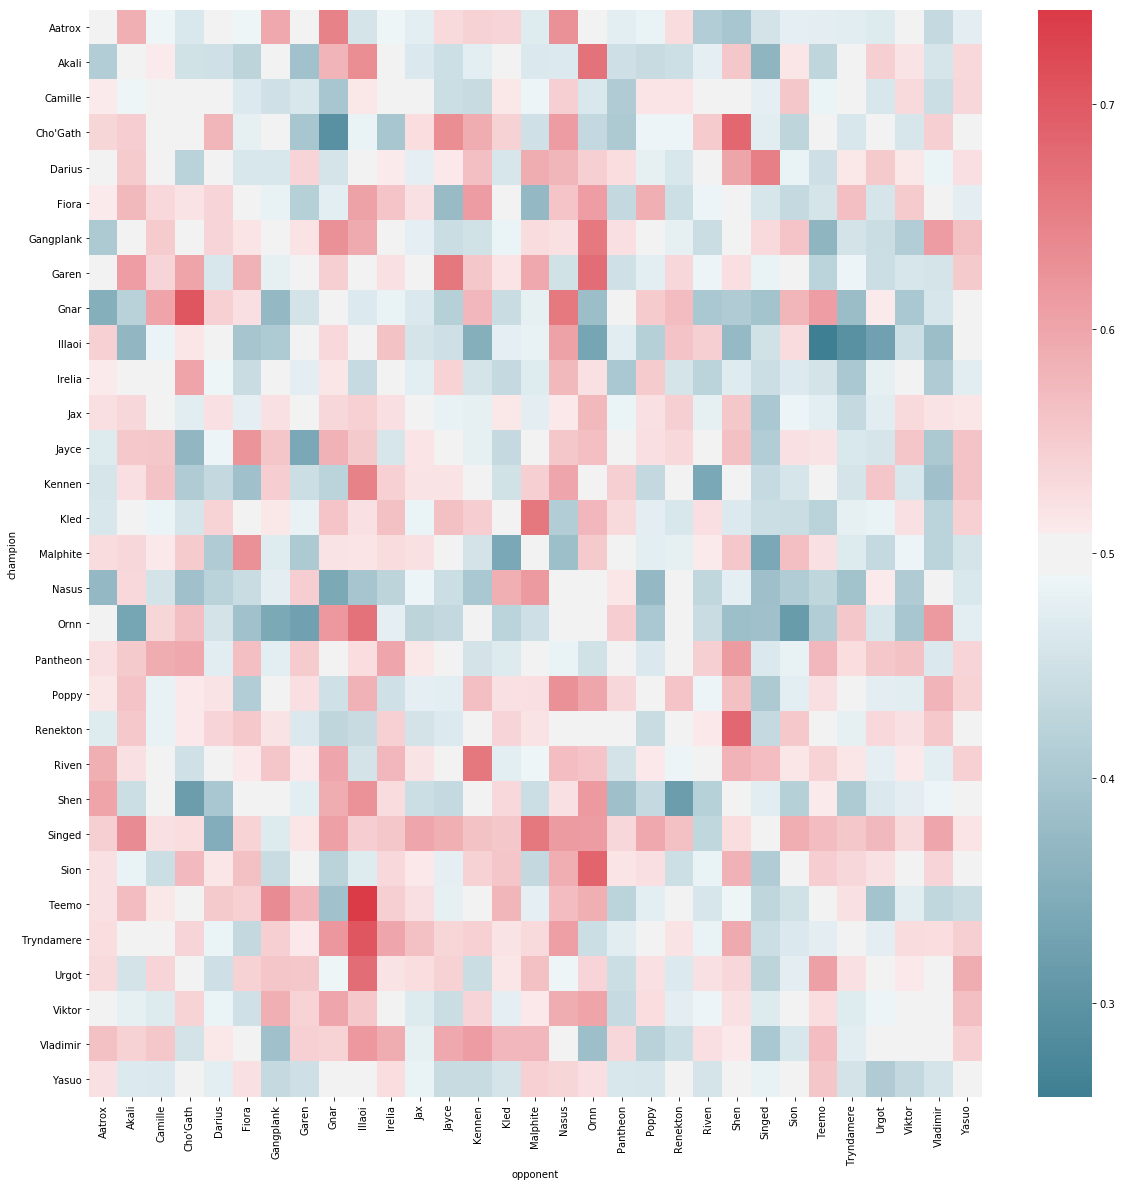

In [626]:
plt.figure(figsize=(20, 20))
heatmap(top)

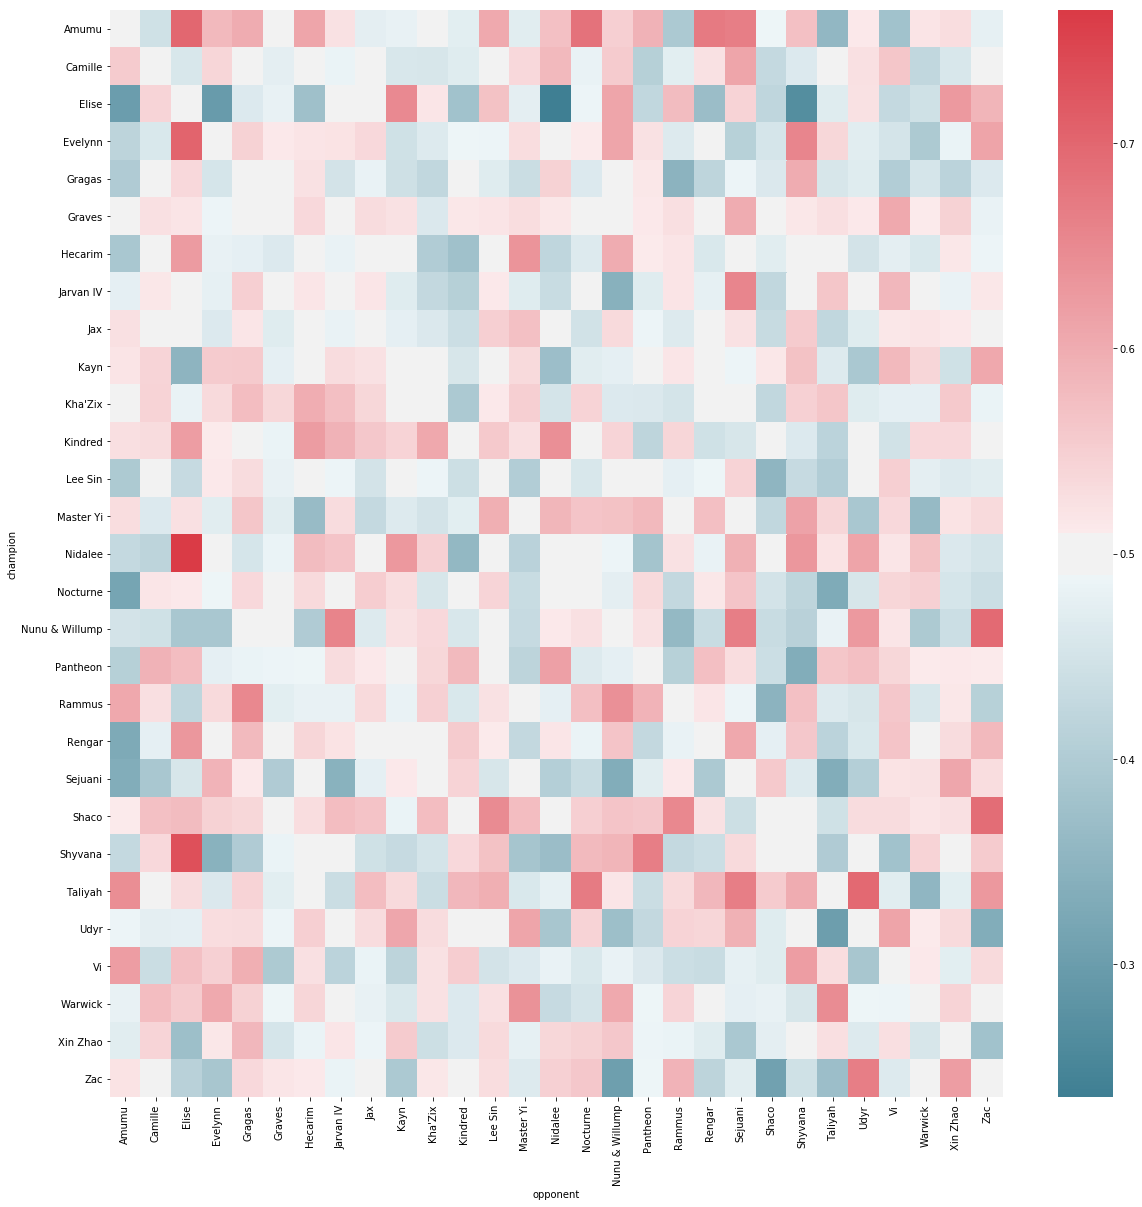

In [627]:
plt.figure(figsize=(20, 20))
heatmap(jg)

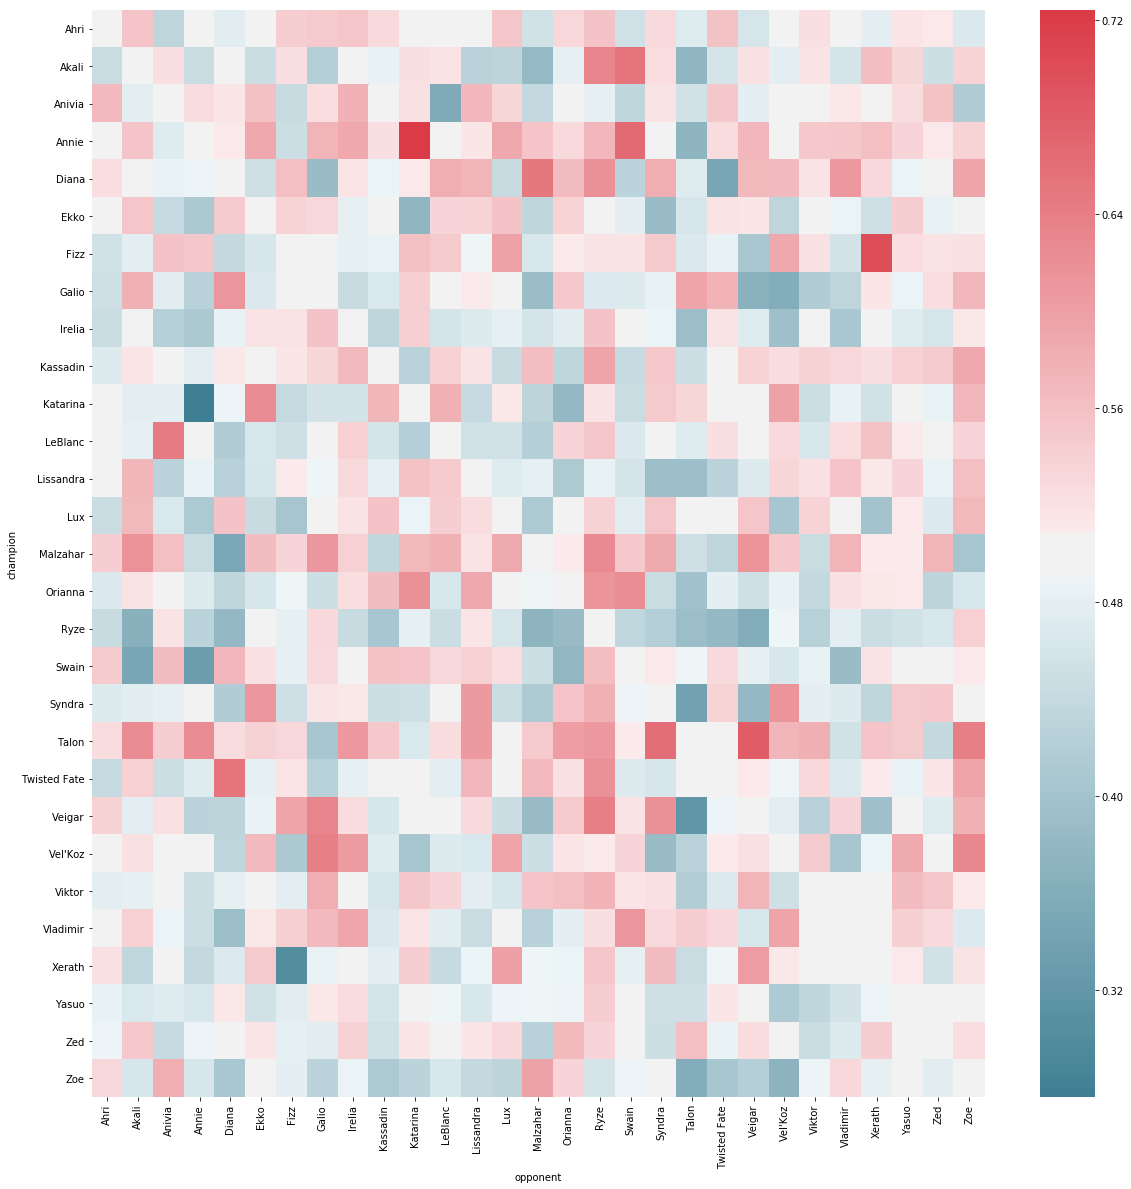

In [628]:
plt.figure(figsize=(20, 20))
heatmap(mid)

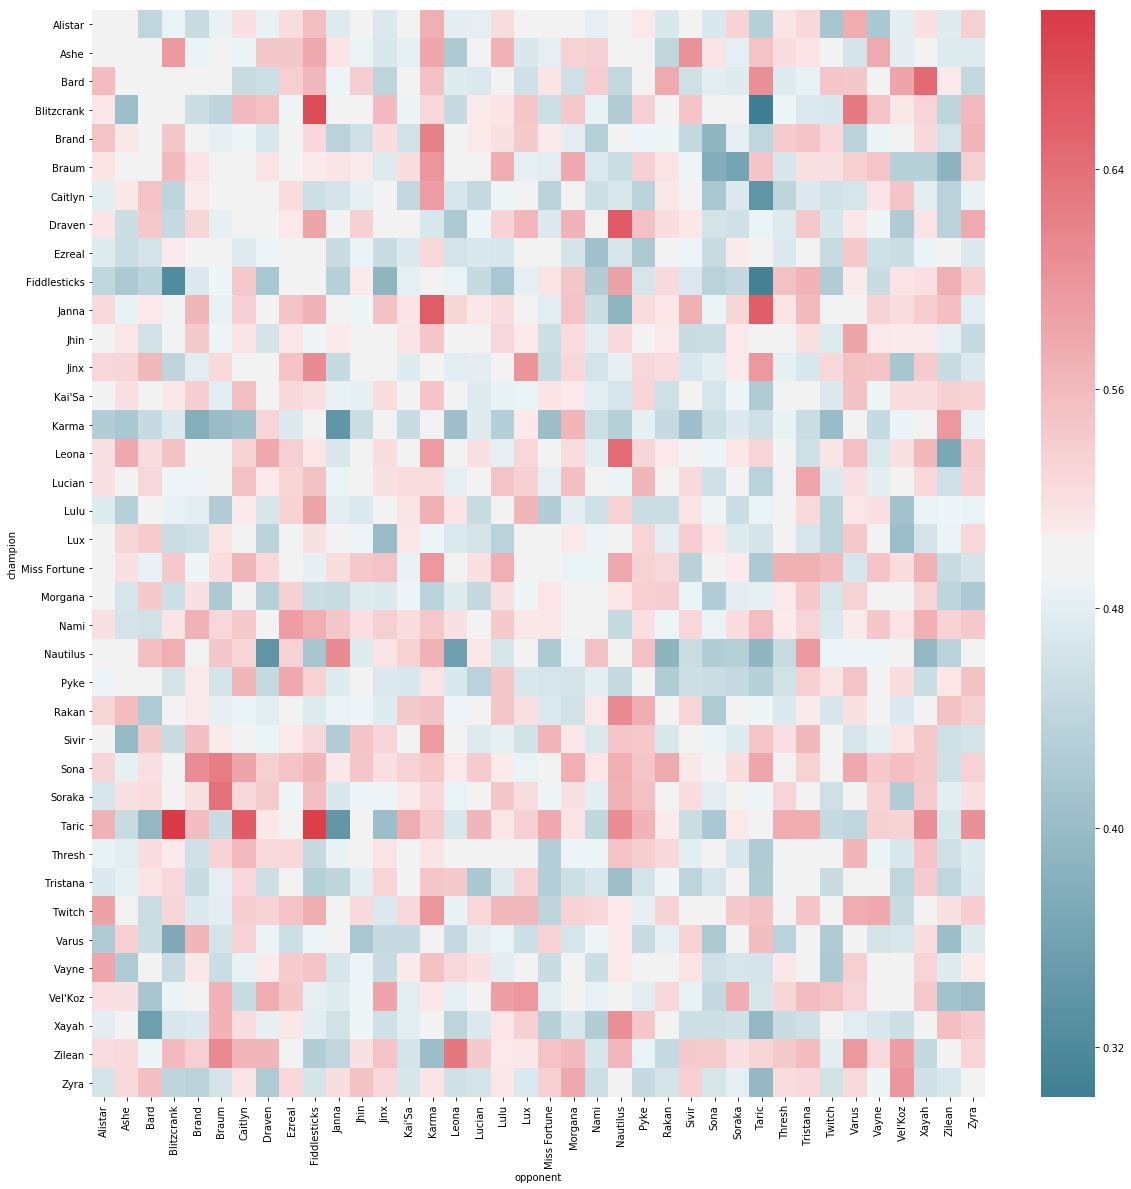

In [629]:
plt.figure(figsize=(20, 20))
heatmap(bot)

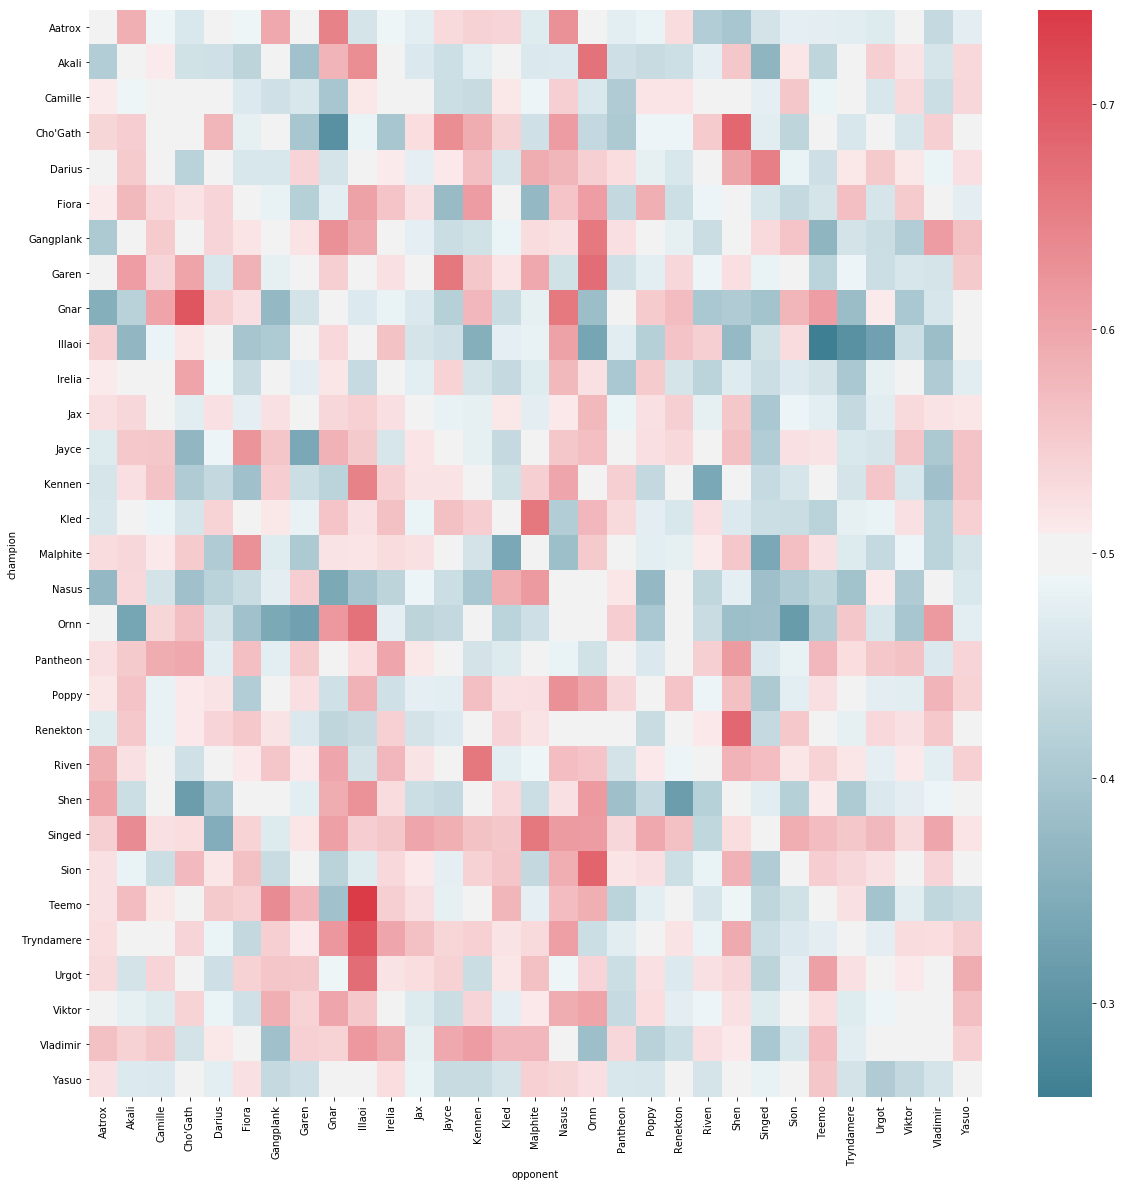

In [616]:
plt.figure(figsize=(20, 20))
sns.heatmap(pivot, cmap=cmap)

## Early Game or Late Game Champions

In addition to this, there are champions that scaled better. When I was talking about ADC (Attack Damage Carry) these champions often do better as the game gets longer and longer. I will find which champions excel in the early game and which excel at the end game. I find data to see how long a game lasted and see if that specific champion won. This way I can see if the game lasted long enough to get to "late game". Each champion has different powerspikes (when they are stronger then most other champions if they were in the same position) and knowing when a champion is strong can help people know who aggressivly or passively they should play. 

In [649]:
#get winrate over time
overTime = {}
for champId in champData:
    overTime[champId] = champData[champId].drop(champData[champId].columns.difference(['win','csDiffPerMinDeltas', 'xpDiffPerMinDeltas']), 1)
    overTime[champId] = overTime[champId].dropna()

In [950]:
WR = {}
for champId in overTime:
    temp = [[0,1],[0,0],[0,0],[0,0],[0,0]]
    for index, row in overTime[champId].iterrows():
        #print(index, len(row['csDiffPerMinDeltas']))
        if row['win'] == True:
            temp[len(row['csDiffPerMinDeltas'])][0] = temp[len(row['csDiffPerMinDeltas'])][0] + 1
        temp[len(row['csDiffPerMinDeltas'])][1] = temp[len(row['csDiffPerMinDeltas'])][1]+1
    WR[champId] = temp
    
WRperPhase = {}

for champId in WR:
    WRperPhase[champId] = []
    for index in WR[champId]:
        if index[1] != 0:
            WRperPhase[champId].append(index[0]/index[1])
    del WRperPhase[champId][0]

These graphs below show how certain champions can either get better or worse as the game continues. Galio would be considered an early game champ due to his high resistances that cannot be broken while olaf power spikes once he has lvl 6 and can be a menace to the opponents. These graph exemplify how each champions have different powerspikes and know when to exploit them. 

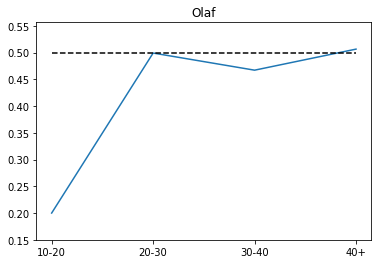

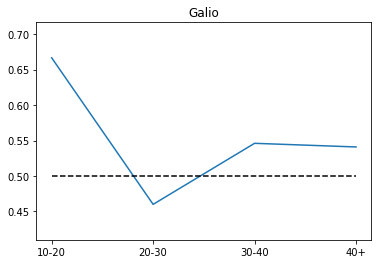

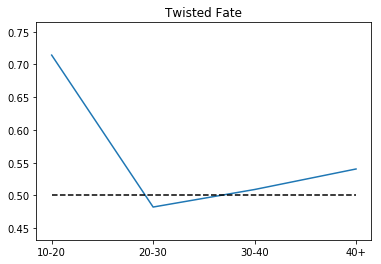

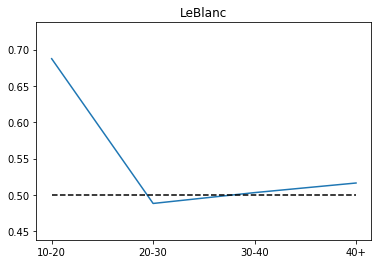

In [987]:
WRperTime(2)
WRperTime(3)
WRperTime(4)
WRperTime(7)

In [988]:
def WRperTime(id):
    #print(WRperPhase(id))
    #fig.suptitle(champIdToName[id]['name'], fontsize=16)
    plt.title(champIdToName[id]['name'])
    plt.plot(['10-20', '20-30', '30-40', '40+'],WRperPhase[id])
    plt.plot(['10-20', '20-30', '30-40', '40+'], [.5,.5,.5,.5], color='k', linestyle='--')
    plt.ylim([min(WRperPhase[id])-.05,max(WRperPhase[id])+.05])
    plt.show()

## Objectives and their importance

I will try to predict who wins a game of league of legends using linear regression. The main features that I am using to determine who would win a game is, baron kills, first blood, inhibitors taken, towers, dragons killed, kills, vision score, xp and creep score.

Baron is an objective that does a lot of damage however, the team that managaes to slay it gets a massive buff an dgives the team 1.5k gold. This is the most contested objective in the game and can be stolen away at any time. SO each team must prep the baron to make sure there is no chance of it being stolen.

Then to get to the nexus, a team has to destory 3 towers in any specific lane. These towers are always protected since each time one goes down, it means that the team is that much closer to losing and an exposed nexus. 

Inhibitors are placed inside the base and give the enemy team a buff. They spawn super minions that have more armor/health and do more damage. Having these super minions allows a team to get objectives on the map that much easier since they are alway pushing to the enemy base.

Lastly, there are dragons that give specific buffs based on which dragon is slayed. THe spawn of the dragon is random and no one knows which one is spawning but there is only 5 options, infernal, mountain, cloud, ocean, and elder. Elder only spawns after 36 mins and isnt alway part of every game however, before then it can be 1 of the 4 dragons I mentioned before. Infernal gives the team a stat boost on their offensive stats. Mountain allows the team to do more damage to stuctures and objectives. Cloud gives the team a movement speed boost when out of combat and lastly ocean gives the team a increased regen when out of combat.

All thesee objectives can influence the outcome of a game and are always highly contested, and with my analysis I will see which have the highest corellation to winning a game.

I originally added all the cs, xp, vision score and kills together however I felt like that does not give an accurate representation of the game since if a game goes longer a losing team can have a higher score for all categories just based on the fact that the game lasted long. So I ran two tests, 1 with pure data and 2 with the difference between the teams. 

In [930]:

predictDF = pd.DataFrame(columns=['teamId', 'win', 'baronKills', 'firstBlood', 'inhibitorKills', 'towerKills', 'dragonKills', 'kills', 'visionScore', 'xp', 'cs'])
diffDF = pd.DataFrame(columns=['teamId', 'win', 'baronKills', 'firstBlood', 'inhibitorKills', 'towerKills', 'dragonKills', 'kills', 'visionScore', 'xp', 'cs']) 
p = 0
x = 0
y = 0
z = 0
for match in matchData:
    t1 = []
    t0 = []
    tempdf = pd.DataFrame(columns=['teamId', 'kills', 'visionScore', 'xp', 'cs'])
    print("ID = "+str(match['gameId'])+" y = "+str(y))
    y = y + 1
    for part in match['participants']:
        temp = []
        teamId = 1    
        if part['teamId'] == 200:
            temp.append(0)
        else:
            temp.append(1)
        temp.append(part['stats']['kills'])
        temp.append(part['stats']['visionScore'])
        if 'xpPerMinDeltas' in part['timeline']:
            xpdif = part['timeline']['xpPerMinDeltas']
            dif = 0
            for key, value in xpdif.items():
                dif = dif + (value*10)
            temp.append(dif)
            xp[teamId] = xp[teamId] + dif
            dif = 0
            csdif = part['timeline']['creepsPerMinDeltas']
            for key, value in csdif.items():
                dif = dif + (value*10)
            temp.append(dif)
            cs[teamId] = cs[teamId] + dif
            tempdf.loc[p] = temp
            p = p + 1
    if 'xpPerMinDeltas' in match['participants'][0]['timeline']:
        for team in match['teams']:
            temp = []
            temp.append(team['teamId'])
            if team['win'] == "Fail":
                temp.append(0)
            else:
                temp.append(1)
            temp.append(team['baronKills'])
            if team['firstBlood'] == True:
                temp.append(1)
            else:
                temp.append(0)
            temp.append(team['inhibitorKills'])
            temp.append(team['towerKills'])
            temp.append(team['dragonKills'])  
            if (team['teamId'] == 100):
                temp = temp + tempdf[tempdf['teamId'] == 1].sum().drop('teamId').tolist()
                t1 = temp
            else: 
                temp = temp + tempdf[tempdf['teamId'] == 0].sum().drop('teamId').tolist()
                t2 = temp
            predictDF.loc[x] = temp
            x = x + 1
        d = []
        for idx, val in enumerate(t1):
            d.append(val-t2[idx])
        diffDF.loc[z] = d
        z = z + 1
        d = []
        for idx, val in enumerate(t2):
            d.append(val-t1[idx])
        diffDF.loc[z] = d
        z = z + 1


ID = 2919948144 y = 0
ID = 2919935444 y = 1
ID = 2919888468 y = 2
ID = 2919892369 y = 3
ID = 2919303150 y = 4
ID = 2919278309 y = 5
ID = 2918428185 y = 6
ID = 2918418196 y = 7
ID = 2918411138 y = 8
ID = 2908562929 y = 9
ID = 2908516777 y = 10
ID = 2908467778 y = 11
ID = 2908448083 y = 12
ID = 2908450226 y = 13
ID = 2908420792 y = 14
ID = 2908371655 y = 15
ID = 2908363591 y = 16
ID = 2908318029 y = 17
ID = 2908324270 y = 18
ID = 2908101922 y = 19
ID = 2908091782 y = 20
ID = 2908039360 y = 21
ID = 2908009606 y = 22
ID = 2907979588 y = 23
ID = 2907949870 y = 24
ID = 2907896950 y = 25
ID = 2907861147 y = 26
ID = 2907832187 y = 27
ID = 2907789260 y = 28
ID = 2907742966 y = 29
ID = 2907655963 y = 30
ID = 2907515937 y = 31
ID = 2907457449 y = 32
ID = 2907369657 y = 33
ID = 2907317964 y = 34
ID = 2907310672 y = 35
ID = 2907224553 y = 36
ID = 2906394438 y = 37
ID = 2906366608 y = 38
ID = 2905964982 y = 39
ID = 2905945182 y = 40
ID = 2905791083 y = 41
ID = 2905641993 y = 42
ID = 2905536919 y = 4

ID = 2902767576 y = 355
ID = 2884993554 y = 356
ID = 2884992024 y = 357
ID = 2884958613 y = 358
ID = 2884965024 y = 359
ID = 2884950935 y = 360
ID = 2884923343 y = 361
ID = 2884208593 y = 362
ID = 2884212242 y = 363
ID = 2871049405 y = 364
ID = 2865704788 y = 365
ID = 2628988779 y = 366
ID = 2627268184 y = 367
ID = 2606449979 y = 368
ID = 2606426163 y = 369
ID = 2606421849 y = 370
ID = 2606387997 y = 371
ID = 2584803730 y = 372
ID = 2561792453 y = 373
ID = 2540652161 y = 374
ID = 2519994392 y = 375
ID = 2498441227 y = 376
ID = 2475694667 y = 377
ID = 2452899365 y = 378
ID = 2427401692 y = 379
ID = 2426277900 y = 380
ID = 2426281661 y = 381
ID = 2417393323 y = 382
ID = 2417276705 y = 383
ID = 2417274980 y = 384
ID = 2417270401 y = 385
ID = 2416854972 y = 386
ID = 2416818723 y = 387
ID = 2416812456 y = 388
ID = 2415730296 y = 389
ID = 2415676076 y = 390
ID = 2415680847 y = 391
ID = 2414729167 y = 392
ID = 2414714043 y = 393
ID = 2414689268 y = 394
ID = 2414686066 y = 395
ID = 2393486107 

ID = 2703603801 y = 698
ID = 2703479622 y = 699
ID = 2702674360 y = 700
ID = 2702640633 y = 701
ID = 2700700896 y = 702
ID = 2700451274 y = 703
ID = 2618614830 y = 704
ID = 2618372907 y = 705
ID = 2616946716 y = 706
ID = 2927802437 y = 707
ID = 2927781074 y = 708
ID = 2926829395 y = 709
ID = 2926808712 y = 710
ID = 2926825942 y = 711
ID = 2926822322 y = 712
ID = 2926746277 y = 713
ID = 2926737568 y = 714
ID = 2926608606 y = 715
ID = 2926469462 y = 716
ID = 2925913059 y = 717
ID = 2925911052 y = 718
ID = 2925853500 y = 719
ID = 2925817193 y = 720
ID = 2925777737 y = 721
ID = 2924798934 y = 722
ID = 2924727121 y = 723
ID = 2924660840 y = 724
ID = 2924553082 y = 725
ID = 2924441083 y = 726
ID = 2924198419 y = 727
ID = 2924194066 y = 728
ID = 2924069892 y = 729
ID = 2923534508 y = 730
ID = 2923511774 y = 731
ID = 2923307920 y = 732
ID = 2923293026 y = 733
ID = 2923300901 y = 734
ID = 2923253129 y = 735
ID = 2923221582 y = 736
ID = 2923186634 y = 737
ID = 2922845477 y = 738
ID = 2922732797 

ID = 2627119005 y = 1046
ID = 2603509653 y = 1047
ID = 2602224759 y = 1048
ID = 2602188833 y = 1049
ID = 2602193194 y = 1050
ID = 2602128827 y = 1051
ID = 2602152271 y = 1052
ID = 2601615274 y = 1053
ID = 2601623838 y = 1054
ID = 2601613966 y = 1055
ID = 2601612852 y = 1056
ID = 2601620380 y = 1057
ID = 2601600679 y = 1058
ID = 2601599742 y = 1059
ID = 2601538018 y = 1060
ID = 2601535840 y = 1061
ID = 2601533227 y = 1062
ID = 2601509519 y = 1063
ID = 2601427024 y = 1064
ID = 2601440376 y = 1065
ID = 2601396123 y = 1066
ID = 2601381302 y = 1067
ID = 2601346661 y = 1068
ID = 2601084183 y = 1069
ID = 2601083406 y = 1070
ID = 2601101790 y = 1071
ID = 2601082203 y = 1072
ID = 2601100439 y = 1073
ID = 2601059485 y = 1074
ID = 2600871591 y = 1075
ID = 2600833852 y = 1076
ID = 2600788657 y = 1077
ID = 2600783798 y = 1078
ID = 2599916985 y = 1079
ID = 2599911073 y = 1080
ID = 2599865991 y = 1081
ID = 2599861637 y = 1082
ID = 2599799500 y = 1083
ID = 2599544224 y = 1084
ID = 2599561011 y = 1085


ID = 2819727816 y = 1376
ID = 2811306509 y = 1377
ID = 2797554865 y = 1378
ID = 2797524540 y = 1379
ID = 2797494054 y = 1380
ID = 2797468180 y = 1381
ID = 2797427683 y = 1382
ID = 2797421702 y = 1383
ID = 2795880774 y = 1384
ID = 2795752280 y = 1385
ID = 2794953696 y = 1386
ID = 2782284633 y = 1387
ID = 2779648287 y = 1388
ID = 2779592427 y = 1389
ID = 2779584727 y = 1390
ID = 2779580067 y = 1391
ID = 2779551052 y = 1392
ID = 2779516262 y = 1393
ID = 2779487172 y = 1394
ID = 2779465405 y = 1395
ID = 2778367179 y = 1396
ID = 2778375231 y = 1397
ID = 2778373994 y = 1398
ID = 2778363760 y = 1399
ID = 2778371002 y = 1400
ID = 2778348475 y = 1401
ID = 2778326675 y = 1402
ID = 2778342840 y = 1403
ID = 2778320655 y = 1404
ID = 2778295118 y = 1405
ID = 2778287832 y = 1406
ID = 2778265069 y = 1407
ID = 2778238772 y = 1408
ID = 2778067277 y = 1409
ID = 2777942665 y = 1410
ID = 2777610438 y = 1411
ID = 2776642382 y = 1412
ID = 2774202517 y = 1413
ID = 2774108914 y = 1414
ID = 2773626105 y = 1415


ID = 2916938212 y = 1711
ID = 2916925801 y = 1712
ID = 2916862748 y = 1713
ID = 2916845187 y = 1714
ID = 2916806879 y = 1715
ID = 2916774095 y = 1716
ID = 2916746657 y = 1717
ID = 2916295939 y = 1718
ID = 2916300887 y = 1719
ID = 2916267378 y = 1720
ID = 2916252410 y = 1721
ID = 2916223985 y = 1722
ID = 2913921633 y = 1723
ID = 2913907378 y = 1724
ID = 2913913266 y = 1725
ID = 2913890298 y = 1726
ID = 2913873047 y = 1727
ID = 2913797424 y = 1728
ID = 2913764653 y = 1729
ID = 2913716835 y = 1730
ID = 2913453045 y = 1731
ID = 2913342100 y = 1732
ID = 2913166599 y = 1733
ID = 2913116989 y = 1734
ID = 2913096615 y = 1735
ID = 2913048364 y = 1736
ID = 2912956235 y = 1737
ID = 2912857151 y = 1738
ID = 2912860163 y = 1739
ID = 2912529779 y = 1740
ID = 2911470851 y = 1741
ID = 2911407323 y = 1742
ID = 2911315352 y = 1743
ID = 2911292601 y = 1744
ID = 2911018533 y = 1745
ID = 2909136929 y = 1746
ID = 2896219580 y = 1747
ID = 2896188454 y = 1748
ID = 2896018630 y = 1749
ID = 2896002980 y = 1750


ID = 2894498991 y = 2041
ID = 2894489764 y = 2042
ID = 2894466152 y = 2043
ID = 2894463854 y = 2044
ID = 2894302954 y = 2045
ID = 2894266887 y = 2046
ID = 2893368574 y = 2047
ID = 2893317658 y = 2048
ID = 2893301034 y = 2049
ID = 2893270334 y = 2050
ID = 2892933428 y = 2051
ID = 2892911406 y = 2052
ID = 2892894052 y = 2053
ID = 2892879000 y = 2054
ID = 2892750379 y = 2055
ID = 2892726564 y = 2056
ID = 2892711722 y = 2057
ID = 2891977753 y = 2058
ID = 2891960038 y = 2059
ID = 2891932444 y = 2060
ID = 2891895108 y = 2061
ID = 2891877406 y = 2062
ID = 2890454325 y = 2063
ID = 2890155600 y = 2064
ID = 2890153576 y = 2065
ID = 2888562712 y = 2066
ID = 2888550242 y = 2067
ID = 2888525358 y = 2068
ID = 2817537840 y = 2069
ID = 2812201741 y = 2070
ID = 2812176304 y = 2071
ID = 2812171388 y = 2072
ID = 2812144795 y = 2073
ID = 2805510753 y = 2074
ID = 2805488171 y = 2075
ID = 2805501842 y = 2076
ID = 2805466229 y = 2077
ID = 2707481005 y = 2078
ID = 2707472615 y = 2079
ID = 2707424195 y = 2080


ID = 2901965220 y = 2373
ID = 2901925346 y = 2374
ID = 2901886075 y = 2375
ID = 2901891085 y = 2376
ID = 2901871175 y = 2377
ID = 2901140202 y = 2378
ID = 2899999176 y = 2379
ID = 2900000532 y = 2380
ID = 2899973831 y = 2381
ID = 2899928076 y = 2382
ID = 2899016215 y = 2383
ID = 2899031760 y = 2384
ID = 2899010751 y = 2385
ID = 2898966382 y = 2386
ID = 2898955722 y = 2387
ID = 2898964165 y = 2388
ID = 2898962834 y = 2389
ID = 2898361010 y = 2390
ID = 2898341377 y = 2391
ID = 2898294176 y = 2392
ID = 2898264196 y = 2393
ID = 2898255124 y = 2394
ID = 2898202785 y = 2395
ID = 2898164574 y = 2396
ID = 2898124257 y = 2397
ID = 2898106754 y = 2398
ID = 2898092237 y = 2399
ID = 2897677350 y = 2400
ID = 2896951508 y = 2401
ID = 2896921894 y = 2402
ID = 2896888640 y = 2403
ID = 2896856299 y = 2404
ID = 2896740684 y = 2405
ID = 2896692051 y = 2406
ID = 2896662831 y = 2407
ID = 2896644144 y = 2408
ID = 2896126871 y = 2409
ID = 2896094897 y = 2410
ID = 2896086734 y = 2411
ID = 2896058605 y = 2412


ID = 2895726879 y = 2704
ID = 2895659177 y = 2705
ID = 2895643475 y = 2706
ID = 2895486158 y = 2707
ID = 2895386202 y = 2708
ID = 2895346044 y = 2709
ID = 2895326876 y = 2710
ID = 2895277675 y = 2711
ID = 2895267229 y = 2712
ID = 2894603238 y = 2713
ID = 2894555728 y = 2714
ID = 2894539465 y = 2715
ID = 2892335056 y = 2716
ID = 2892332466 y = 2717
ID = 2892324711 y = 2718
ID = 2892321838 y = 2719
ID = 2892299544 y = 2720
ID = 2892296858 y = 2721
ID = 2892286270 y = 2722
ID = 2891777464 y = 2723
ID = 2891759292 y = 2724
ID = 2891696372 y = 2725
ID = 2891693343 y = 2726
ID = 2891690310 y = 2727
ID = 2891675430 y = 2728
ID = 2890838441 y = 2729
ID = 2890831520 y = 2730
ID = 2890813400 y = 2731
ID = 2890797617 y = 2732
ID = 2890190395 y = 2733
ID = 2890180903 y = 2734
ID = 2890167469 y = 2735
ID = 2890165621 y = 2736
ID = 2890163785 y = 2737
ID = 2890144842 y = 2738
ID = 2890138761 y = 2739
ID = 2890118611 y = 2740
ID = 2880279697 y = 2741
ID = 2880284313 y = 2742
ID = 2880248651 y = 2743


ID = 2807717057 y = 3039
ID = 2807689274 y = 3040
ID = 2807700913 y = 3041
ID = 2807675673 y = 3042
ID = 2807637925 y = 3043
ID = 2807622679 y = 3044
ID = 2807596988 y = 3045
ID = 2807357521 y = 3046
ID = 2807354651 y = 3047
ID = 2807371155 y = 3048
ID = 2807322399 y = 3049
ID = 2807248887 y = 3050
ID = 2807176999 y = 3051
ID = 2807061810 y = 3052
ID = 2806864803 y = 3053
ID = 2806864262 y = 3054
ID = 2806843755 y = 3055
ID = 2806205471 y = 3056
ID = 2806077164 y = 3057
ID = 2806035003 y = 3058
ID = 2805865853 y = 3059
ID = 2805832083 y = 3060
ID = 2805806014 y = 3061
ID = 2805770014 y = 3062
ID = 2805723437 y = 3063
ID = 2805549306 y = 3064
ID = 2805545860 y = 3065
ID = 2805322651 y = 3066
ID = 2805176245 y = 3067
ID = 2805161787 y = 3068
ID = 2804771185 y = 3069
ID = 2804750514 y = 3070
ID = 2804789819 y = 3071
ID = 2804720056 y = 3072
ID = 2804655350 y = 3073
ID = 2804629152 y = 3074
ID = 2803950792 y = 3075
ID = 2803813258 y = 3076
ID = 2803800195 y = 3077
ID = 2803763099 y = 3078


ID = 2743979054 y = 3370
ID = 2743963403 y = 3371
ID = 2743722744 y = 3372
ID = 2741649493 y = 3373
ID = 2741232301 y = 3374
ID = 2741229528 y = 3375
ID = 2741216328 y = 3376
ID = 2741196522 y = 3377
ID = 2740751239 y = 3378
ID = 2927846285 y = 3379
ID = 2920644807 y = 3380
ID = 2920634262 y = 3381
ID = 2919306992 y = 3382
ID = 2919321522 y = 3383
ID = 2918586525 y = 3384
ID = 2918583989 y = 3385
ID = 2918582229 y = 3386
ID = 2918568709 y = 3387
ID = 2918564446 y = 3388
ID = 2918551999 y = 3389
ID = 2918559802 y = 3390
ID = 2918527694 y = 3391
ID = 2916804278 y = 3392
ID = 2916765617 y = 3393
ID = 2912510473 y = 3394
ID = 2912494282 y = 3395
ID = 2910280231 y = 3396
ID = 2903195752 y = 3397
ID = 2903185391 y = 3398
ID = 2902865505 y = 3399
ID = 2902766616 y = 3400
ID = 2902700095 y = 3401
ID = 2902287486 y = 3402
ID = 2896674632 y = 3403
ID = 2896658656 y = 3404
ID = 2896081633 y = 3405
ID = 2896035022 y = 3406
ID = 2896020609 y = 3407
ID = 2895952628 y = 3408
ID = 2894464320 y = 3409


ID = 2905370206 y = 3700
ID = 2905327613 y = 3701
ID = 2905344588 y = 3702
ID = 2905322734 y = 3703
ID = 2904699561 y = 3704
ID = 2904707901 y = 3705
ID = 2904696673 y = 3706
ID = 2904695207 y = 3707
ID = 2900006330 y = 3708
ID = 2899213350 y = 3709
ID = 2898837454 y = 3710
ID = 2898459791 y = 3711
ID = 2898419329 y = 3712
ID = 2898416955 y = 3713
ID = 2897067882 y = 3714
ID = 2895932818 y = 3715
ID = 2894728235 y = 3716
ID = 2894327828 y = 3717
ID = 2894333745 y = 3718
ID = 2894331770 y = 3719
ID = 2894300049 y = 3720
ID = 2894244805 y = 3721
ID = 2894207488 y = 3722
ID = 2894177161 y = 3723
ID = 2894179881 y = 3724
ID = 2894078537 y = 3725
ID = 2894082217 y = 3726
ID = 2893582629 y = 3727
ID = 2893568160 y = 3728
ID = 2893171894 y = 3729
ID = 2893144069 y = 3730
ID = 2893064047 y = 3731
ID = 2892741008 y = 3732
ID = 2892493822 y = 3733
ID = 2892457693 y = 3734
ID = 2892450654 y = 3735
ID = 2892417530 y = 3736
ID = 2892420038 y = 3737
ID = 2892378568 y = 3738
ID = 2892383344 y = 3739


ID = 2780910649 y = 4034
ID = 2780886008 y = 4035
ID = 2779243941 y = 4036
ID = 2778437278 y = 4037
ID = 2706600961 y = 4038
ID = 2706409261 y = 4039
ID = 2706369062 y = 4040
ID = 2706381922 y = 4041
ID = 2706271962 y = 4042
ID = 2706244671 y = 4043
ID = 2706250599 y = 4044
ID = 2704604572 y = 4045
ID = 2701509303 y = 4046
ID = 2696989501 y = 4047
ID = 2625390320 y = 4048
ID = 2625352445 y = 4049
ID = 2625323216 y = 4050
ID = 2625266776 y = 4051
ID = 2625252679 y = 4052
ID = 2620877320 y = 4053
ID = 2620843198 y = 4054
ID = 2620803111 y = 4055
ID = 2620760314 y = 4056
ID = 2620741525 y = 4057
ID = 2620724558 y = 4058
ID = 2620549826 y = 4059
ID = 2620531889 y = 4060
ID = 2620494933 y = 4061
ID = 2618708419 y = 4062
ID = 2618720940 y = 4063
ID = 2618675028 y = 4064
ID = 2618648594 y = 4065
ID = 2603937537 y = 4066
ID = 2603863867 y = 4067
ID = 2603850801 y = 4068
ID = 2566371855 y = 4069
ID = 2565221291 y = 4070
ID = 2565211354 y = 4071
ID = 2565157854 y = 4072
ID = 2565173134 y = 4073


ID = 2894876475 y = 4370
ID = 2894860648 y = 4371
ID = 2894824319 y = 4372
ID = 2894796908 y = 4373
ID = 2894800452 y = 4374
ID = 2894783286 y = 4375
ID = 2894713121 y = 4376
ID = 2894585695 y = 4377
ID = 2894573183 y = 4378
ID = 2894526751 y = 4379
ID = 2894521367 y = 4380
ID = 2894514477 y = 4381
ID = 2894510495 y = 4382
ID = 2894363407 y = 4383
ID = 2894336479 y = 4384
ID = 2894320727 y = 4385
ID = 2894284319 y = 4386
ID = 2894113457 y = 4387
ID = 2894101134 y = 4388
ID = 2894094341 y = 4389
ID = 2893982667 y = 4390
ID = 2893951413 y = 4391
ID = 2893948916 y = 4392
ID = 2893569270 y = 4393
ID = 2893572708 y = 4394
ID = 2893508423 y = 4395
ID = 2893503168 y = 4396
ID = 2893429670 y = 4397
ID = 2893420507 y = 4398
ID = 2893035378 y = 4399
ID = 2893002271 y = 4400
ID = 2892926137 y = 4401
ID = 2892912515 y = 4402
ID = 2892904797 y = 4403
ID = 2892863485 y = 4404
ID = 2892463070 y = 4405
ID = 2892436591 y = 4406
ID = 2892426939 y = 4407
ID = 2892420637 y = 4408
ID = 2892411718 y = 4409


ID = 2843309257 y = 4703
ID = 2843134218 y = 4704
ID = 2843132268 y = 4705
ID = 2843109483 y = 4706
ID = 2842085636 y = 4707
ID = 2842052134 y = 4708
ID = 2842041330 y = 4709
ID = 2841687151 y = 4710
ID = 2841685426 y = 4711
ID = 2838808949 y = 4712
ID = 2838788629 y = 4713
ID = 2838755446 y = 4714
ID = 2838723170 y = 4715
ID = 2838690761 y = 4716
ID = 2838619898 y = 4717
ID = 2838329238 y = 4718
ID = 2910646004 y = 4719
ID = 2910639871 y = 4720
ID = 2901333015 y = 4721
ID = 2899734266 y = 4722
ID = 2899687803 y = 4723
ID = 2899679044 y = 4724
ID = 2899653249 y = 4725
ID = 2899625739 y = 4726
ID = 2898647004 y = 4727
ID = 2898641582 y = 4728
ID = 2897086830 y = 4729
ID = 2897094028 y = 4730
ID = 2897069311 y = 4731
ID = 2897057604 y = 4732
ID = 2897051225 y = 4733
ID = 2897042979 y = 4734
ID = 2897019929 y = 4735
ID = 2897002077 y = 4736
ID = 2895659410 y = 4737
ID = 2895667044 y = 4738
ID = 2895499612 y = 4739
ID = 2894926099 y = 4740
ID = 2894915385 y = 4741
ID = 2894933259 y = 4742


ID = 2926049040 y = 5034
ID = 2919328144 y = 5035
ID = 2918532282 y = 5036
ID = 2918489398 y = 5037
ID = 2917936740 y = 5038
ID = 2917933434 y = 5039
ID = 2917897322 y = 5040
ID = 2917905051 y = 5041
ID = 2917869102 y = 5042
ID = 2917862022 y = 5043
ID = 2917214010 y = 5044
ID = 2917199752 y = 5045
ID = 2917083111 y = 5046
ID = 2917071393 y = 5047
ID = 2916999174 y = 5048
ID = 2906370087 y = 5049
ID = 2906307127 y = 5050
ID = 2906295922 y = 5051
ID = 2906304292 y = 5052
ID = 2906312104 y = 5053
ID = 2905299909 y = 5054
ID = 2904703085 y = 5055
ID = 2904688863 y = 5056
ID = 2904668371 y = 5057
ID = 2903921101 y = 5058
ID = 2903840493 y = 5059
ID = 2903806255 y = 5060
ID = 2903200742 y = 5061
ID = 2902320912 y = 5062
ID = 2902309805 y = 5063
ID = 2902297803 y = 5064
ID = 2902293230 y = 5065
ID = 2902281185 y = 5066
ID = 2897120779 y = 5067
ID = 2897089295 y = 5068
ID = 2892282138 y = 5069
ID = 2892290361 y = 5070
ID = 2889388961 y = 5071
ID = 2889399752 y = 5072
ID = 2888898357 y = 5073


ID = 2740404581 y = 5365
ID = 2739505856 y = 5366
ID = 2739468383 y = 5367
ID = 2739227236 y = 5368
ID = 2739039388 y = 5369
ID = 2738948208 y = 5370
ID = 2738927150 y = 5371
ID = 2738919820 y = 5372
ID = 2738902244 y = 5373
ID = 2737533999 y = 5374
ID = 2737461383 y = 5375
ID = 2737440686 y = 5376
ID = 2737422702 y = 5377
ID = 2737386348 y = 5378
ID = 2736349414 y = 5379
ID = 2736008232 y = 5380
ID = 2735958640 y = 5381
ID = 2735131994 y = 5382
ID = 2728781090 y = 5383
ID = 2728755575 y = 5384
ID = 2645639052 y = 5385
ID = 2645640519 y = 5386
ID = 2635924515 y = 5387
ID = 2635884073 y = 5388
ID = 2635844575 y = 5389
ID = 2635816779 y = 5390
ID = 2635804639 y = 5391
ID = 2635318874 y = 5392
ID = 2635314654 y = 5393
ID = 2635311598 y = 5394
ID = 2635218480 y = 5395
ID = 2635092713 y = 5396
ID = 2634805379 y = 5397
ID = 2634771518 y = 5398
ID = 2634734398 y = 5399
ID = 2634706661 y = 5400
ID = 2634700419 y = 5401
ID = 2634166670 y = 5402
ID = 2634151630 y = 5403
ID = 2633809721 y = 5404


ID = 2890082641 y = 5701
ID = 2889837329 y = 5702
ID = 2884998846 y = 5703
ID = 2885007204 y = 5704
ID = 2884986331 y = 5705
ID = 2884983997 y = 5706
ID = 2884982012 y = 5707
ID = 2884955826 y = 5708
ID = 2884300086 y = 5709
ID = 2880922930 y = 5710
ID = 2880919943 y = 5711
ID = 2880639034 y = 5712
ID = 2880626009 y = 5713
ID = 2880639799 y = 5714
ID = 2880567175 y = 5715
ID = 2879240177 y = 5716
ID = 2879205362 y = 5717
ID = 2861641085 y = 5718
ID = 2909358669 y = 5719
ID = 2909339944 y = 5720
ID = 2898696817 y = 5721
ID = 2884050929 y = 5722
ID = 2871796010 y = 5723
ID = 2871783836 y = 5724
ID = 2870299844 y = 5725
ID = 2870281642 y = 5726
ID = 2866290298 y = 5727
ID = 2864684575 y = 5728
ID = 2864626000 y = 5729
ID = 2864564900 y = 5730
ID = 2864529668 y = 5731
ID = 2864503246 y = 5732
ID = 2864427153 y = 5733
ID = 2864412644 y = 5734
ID = 2864365377 y = 5735
ID = 2862921682 y = 5736
ID = 2862907544 y = 5737
ID = 2862895152 y = 5738
ID = 2862235640 y = 5739
ID = 2861726554 y = 5740


ID = 2926745007 y = 6033
ID = 2926316366 y = 6034
ID = 2926290450 y = 6035
ID = 2926261349 y = 6036
ID = 2925868917 y = 6037
ID = 2925866614 y = 6038
ID = 2925872516 y = 6039
ID = 2925844039 y = 6040
ID = 2925807256 y = 6041
ID = 2925799912 y = 6042
ID = 2925762194 y = 6043
ID = 2925698899 y = 6044
ID = 2925672382 y = 6045
ID = 2925616324 y = 6046
ID = 2925564724 y = 6047
ID = 2925550905 y = 6048
ID = 2924976241 y = 6049
ID = 2924903966 y = 6050
ID = 2924227866 y = 6051
ID = 2924234228 y = 6052
ID = 2924222432 y = 6053
ID = 2924230397 y = 6054
ID = 2924142175 y = 6055
ID = 2924087941 y = 6056
ID = 2923689252 y = 6057
ID = 2923659273 y = 6058
ID = 2923661917 y = 6059
ID = 2923638651 y = 6060
ID = 2923617355 y = 6061
ID = 2923577374 y = 6062
ID = 2923025863 y = 6063
ID = 2923013002 y = 6064
ID = 2923020727 y = 6065
ID = 2922941193 y = 6066
ID = 2922828064 y = 6067
ID = 2922820704 y = 6068
ID = 2922556905 y = 6069
ID = 2922514355 y = 6070
ID = 2922068732 y = 6071
ID = 2922067341 y = 6072


ID = 2892777625 y = 6369
ID = 2892775253 y = 6370
ID = 2892759473 y = 6371
ID = 2892748910 y = 6372
ID = 2892744219 y = 6373
ID = 2892727211 y = 6374
ID = 2892634276 y = 6375
ID = 2892621563 y = 6376
ID = 2888730248 y = 6377
ID = 2888702278 y = 6378
ID = 2888666349 y = 6379
ID = 2888654894 y = 6380
ID = 2888630067 y = 6381
ID = 2888585633 y = 6382
ID = 2888580051 y = 6383
ID = 2886910075 y = 6384
ID = 2886878401 y = 6385
ID = 2886220697 y = 6386
ID = 2875340457 y = 6387
ID = 2875320241 y = 6388
ID = 2874597869 y = 6389
ID = 2874582637 y = 6390
ID = 2874465598 y = 6391
ID = 2873711813 y = 6392
ID = 2873680496 y = 6393
ID = 2844380166 y = 6394
ID = 2829193654 y = 6395
ID = 2825661147 y = 6396
ID = 2923585831 y = 6397
ID = 2921542558 y = 6398
ID = 2913870320 y = 6399
ID = 2900548889 y = 6400
ID = 2900533852 y = 6401
ID = 2898925701 y = 6402
ID = 2897838893 y = 6403
ID = 2897817528 y = 6404
ID = 2896317361 y = 6405
ID = 2896301656 y = 6406
ID = 2894359645 y = 6407
ID = 2894356929 y = 6408


ID = 2926802198 y = 6701
ID = 2926798608 y = 6702
ID = 2926795480 y = 6703
ID = 2926773720 y = 6704
ID = 2926767675 y = 6705
ID = 2926740622 y = 6706
ID = 2926704034 y = 6707
ID = 2926595839 y = 6708
ID = 2924219204 y = 6709
ID = 2924193863 y = 6710
ID = 2924168605 y = 6711
ID = 2924159486 y = 6712
ID = 2924132758 y = 6713
ID = 2923361191 y = 6714
ID = 2923344446 y = 6715
ID = 2923306941 y = 6716
ID = 2921935395 y = 6717
ID = 2920357122 y = 6718
ID = 2911010920 y = 6719
ID = 2910946427 y = 6720
ID = 2909926400 y = 6721
ID = 2909920346 y = 6722
ID = 2909902996 y = 6723
ID = 2909632238 y = 6724
ID = 2909303936 y = 6725
ID = 2909230165 y = 6726
ID = 2907028391 y = 6727
ID = 2906892749 y = 6728
ID = 2906284567 y = 6729
ID = 2906261587 y = 6730
ID = 2906204973 y = 6731
ID = 2906179004 y = 6732
ID = 2906191088 y = 6733
ID = 2905626923 y = 6734
ID = 2905567814 y = 6735
ID = 2905285976 y = 6736
ID = 2904817069 y = 6737
ID = 2904315505 y = 6738
ID = 2904276540 y = 6739
ID = 2904259605 y = 6740


ID = 2919176715 y = 7030
ID = 2919149757 y = 7031
ID = 2919140647 y = 7032
ID = 2919117805 y = 7033
ID = 2919049176 y = 7034
ID = 2918604194 y = 7035
ID = 2918540884 y = 7036
ID = 2918033385 y = 7037
ID = 2918031212 y = 7038
ID = 2917967786 y = 7039
ID = 2917944523 y = 7040
ID = 2917916601 y = 7041
ID = 2917925617 y = 7042
ID = 2917914460 y = 7043
ID = 2917004791 y = 7044
ID = 2916993895 y = 7045
ID = 2917001487 y = 7046
ID = 2916568618 y = 7047
ID = 2916440910 y = 7048
ID = 2916405557 y = 7049
ID = 2916328668 y = 7050
ID = 2915953115 y = 7051
ID = 2915937319 y = 7052
ID = 2915931635 y = 7053
ID = 2915750333 y = 7054
ID = 2915718762 y = 7055
ID = 2915737178 y = 7056
ID = 2915119246 y = 7057
ID = 2915099542 y = 7058
ID = 2914964045 y = 7059
ID = 2914841068 y = 7060
ID = 2914808836 y = 7061
ID = 2914777699 y = 7062
ID = 2914795038 y = 7063
ID = 2914260830 y = 7064
ID = 2914017970 y = 7065
ID = 2913931918 y = 7066
ID = 2913917821 y = 7067
ID = 2913516136 y = 7068
ID = 2913499647 y = 7069


ID = 2884888237 y = 7359
ID = 2884870131 y = 7360
ID = 2884829933 y = 7361
ID = 2884774684 y = 7362
ID = 2884754685 y = 7363
ID = 2884725076 y = 7364
ID = 2884705761 y = 7365
ID = 2884689838 y = 7366
ID = 2884677542 y = 7367
ID = 2883697610 y = 7368
ID = 2883683995 y = 7369
ID = 2883673152 y = 7370
ID = 2883637187 y = 7371
ID = 2883597904 y = 7372
ID = 2883579405 y = 7373
ID = 2883009348 y = 7374
ID = 2882992439 y = 7375
ID = 2882950261 y = 7376
ID = 2882886990 y = 7377
ID = 2882813054 y = 7378
ID = 2882669040 y = 7379
ID = 2882672227 y = 7380
ID = 2881858002 y = 7381
ID = 2881833528 y = 7382
ID = 2881796981 y = 7383
ID = 2881751264 y = 7384
ID = 2881726364 y = 7385
ID = 2881714524 y = 7386
ID = 2881669006 y = 7387
ID = 2881680702 y = 7388
ID = 2881643922 y = 7389
ID = 2881621647 y = 7390
ID = 2879977597 y = 7391
ID = 2879957669 y = 7392
ID = 2879951401 y = 7393
ID = 2879909532 y = 7394
ID = 2879880753 y = 7395
ID = 2908125321 y = 7396
ID = 2908086647 y = 7397
ID = 2908051064 y = 7398


ID = 2889308081 y = 7689
ID = 2889277252 y = 7690
ID = 2881275986 y = 7691
ID = 2881257485 y = 7692
ID = 2881236988 y = 7693
ID = 2881214133 y = 7694
ID = 2881196891 y = 7695
ID = 2927673560 y = 7696
ID = 2927604762 y = 7697
ID = 2927578088 y = 7698
ID = 2927411020 y = 7699
ID = 2927373127 y = 7700
ID = 2927345894 y = 7701
ID = 2927324458 y = 7702
ID = 2927285265 y = 7703
ID = 2927264190 y = 7704
ID = 2927181974 y = 7705
ID = 2927132509 y = 7706
ID = 2927077985 y = 7707
ID = 2926977136 y = 7708
ID = 2926953203 y = 7709
ID = 2926948261 y = 7710
ID = 2926924000 y = 7711
ID = 2926893493 y = 7712
ID = 2926890100 y = 7713
ID = 2926730883 y = 7714
ID = 2926270247 y = 7715
ID = 2926241729 y = 7716
ID = 2925805185 y = 7717
ID = 2925797864 y = 7718
ID = 2922450629 y = 7719
ID = 2922422004 y = 7720
ID = 2918722321 y = 7721
ID = 2918618089 y = 7722
ID = 2918602068 y = 7723
ID = 2918339239 y = 7724
ID = 2916680755 y = 7725
ID = 2916662285 y = 7726
ID = 2916525733 y = 7727
ID = 2916519854 y = 7728


ID = 2906918148 y = 8018
ID = 2906875722 y = 8019
ID = 2906855658 y = 8020
ID = 2906812734 y = 8021
ID = 2906746608 y = 8022
ID = 2906693866 y = 8023
ID = 2906664708 y = 8024
ID = 2906313587 y = 8025
ID = 2906311164 y = 8026
ID = 2906269119 y = 8027
ID = 2906274293 y = 8028
ID = 2906281020 y = 8029
ID = 2906247570 y = 8030
ID = 2906240378 y = 8031
ID = 2906223234 y = 8032
ID = 2906158273 y = 8033
ID = 2906115609 y = 8034
ID = 2906092946 y = 8035
ID = 2906048359 y = 8036
ID = 2906008444 y = 8037
ID = 2905989128 y = 8038
ID = 2905938296 y = 8039
ID = 2905803266 y = 8040
ID = 2905569094 y = 8041
ID = 2905559411 y = 8042
ID = 2905309889 y = 8043
ID = 2905286643 y = 8044
ID = 2905275759 y = 8045
ID = 2905263101 y = 8046
ID = 2905257844 y = 8047
ID = 2905253329 y = 8048
ID = 2905207547 y = 8049
ID = 2905199186 y = 8050
ID = 2905180361 y = 8051
ID = 2905165257 y = 8052
ID = 2905113838 y = 8053
ID = 2905080390 y = 8054
ID = 2905047755 y = 8055
ID = 2904998345 y = 8056
ID = 2904978358 y = 8057


ID = 2888104310 y = 8351
ID = 2886656302 y = 8352
ID = 2886638815 y = 8353
ID = 2886614088 y = 8354
ID = 2885711550 y = 8355
ID = 2885301628 y = 8356
ID = 2885220228 y = 8357
ID = 2885194353 y = 8358
ID = 2885187409 y = 8359
ID = 2884757754 y = 8360
ID = 2884718383 y = 8361
ID = 2884719869 y = 8362
ID = 2883995675 y = 8363
ID = 2883972613 y = 8364
ID = 2882905014 y = 8365
ID = 2882439385 y = 8366
ID = 2882364833 y = 8367
ID = 2882313343 y = 8368
ID = 2882265825 y = 8369
ID = 2882073577 y = 8370
ID = 2882027684 y = 8371
ID = 2881997771 y = 8372
ID = 2881719202 y = 8373
ID = 2881712913 y = 8374
ID = 2880997745 y = 8375
ID = 2880957248 y = 8376
ID = 2880559794 y = 8377
ID = 2880458727 y = 8378
ID = 2880451845 y = 8379
ID = 2880424507 y = 8380
ID = 2880290800 y = 8381
ID = 2880159855 y = 8382
ID = 2879970040 y = 8383
ID = 2879950405 y = 8384
ID = 2879880753 y = 8385
ID = 2879853527 y = 8386
ID = 2879834716 y = 8387
ID = 2879727325 y = 8388
ID = 2879704490 y = 8389
ID = 2879696573 y = 8390


ID = 2884831747 y = 8681
ID = 2884823351 y = 8682
ID = 2864604031 y = 8683
ID = 2864542765 y = 8684
ID = 2862071261 y = 8685
ID = 2862059197 y = 8686
ID = 2857806982 y = 8687
ID = 2857778771 y = 8688
ID = 2857747040 y = 8689
ID = 2857731528 y = 8690
ID = 2857367247 y = 8691
ID = 2857384281 y = 8692
ID = 2857372488 y = 8693
ID = 2857350078 y = 8694
ID = 2857315810 y = 8695
ID = 2906001890 y = 8696
ID = 2905949029 y = 8697
ID = 2905805417 y = 8698
ID = 2905021460 y = 8699
ID = 2903780264 y = 8700
ID = 2899522445 y = 8701
ID = 2899466887 y = 8702
ID = 2899376787 y = 8703
ID = 2899359964 y = 8704
ID = 2899212975 y = 8705
ID = 2896356190 y = 8706
ID = 2896314147 y = 8707
ID = 2896290949 y = 8708
ID = 2893152372 y = 8709
ID = 2893066519 y = 8710
ID = 2893009401 y = 8711
ID = 2892998830 y = 8712
ID = 2889390525 y = 8713
ID = 2889377689 y = 8714
ID = 2889382293 y = 8715
ID = 2886732205 y = 8716
ID = 2886712101 y = 8717
ID = 2886694200 y = 8718
ID = 2886665212 y = 8719
ID = 2886638905 y = 8720


ID = 2894497516 y = 9010
ID = 2894504255 y = 9011
ID = 2893997828 y = 9012
ID = 2893982050 y = 9013
ID = 2892973695 y = 9014
ID = 2892956153 y = 9015
ID = 2892514376 y = 9016
ID = 2892500407 y = 9017
ID = 2892010699 y = 9018
ID = 2891977726 y = 9019
ID = 2891822343 y = 9020
ID = 2891773806 y = 9021
ID = 2891754530 y = 9022
ID = 2890907035 y = 9023
ID = 2890323011 y = 9024
ID = 2889727013 y = 9025
ID = 2889693759 y = 9026
ID = 2888977447 y = 9027
ID = 2888964142 y = 9028
ID = 2888504855 y = 9029
ID = 2888493539 y = 9030
ID = 2887991592 y = 9031
ID = 2887087360 y = 9032
ID = 2886458879 y = 9033
ID = 2886443364 y = 9034
ID = 2885692800 y = 9035
ID = 2885656340 y = 9036
ID = 2885247406 y = 9037
ID = 2884757754 y = 9038
ID = 2883971702 y = 9039
ID = 2883453920 y = 9040
ID = 2882588450 y = 9041
ID = 2881706529 y = 9042
ID = 2881121722 y = 9043
ID = 2880372226 y = 9044
ID = 2879747780 y = 9045
ID = 2879293089 y = 9046
ID = 2878349020 y = 9047
ID = 2877242749 y = 9048
ID = 2876255460 y = 9049


ID = 2835984394 y = 9342
ID = 2835991506 y = 9343
ID = 2827737782 y = 9344
ID = 2805249168 y = 9345
ID = 2805240543 y = 9346
ID = 2805222729 y = 9347
ID = 2805206402 y = 9348
ID = 2805202190 y = 9349
ID = 2805155577 y = 9350
ID = 2805151118 y = 9351
ID = 2805146925 y = 9352
ID = 2796181090 y = 9353
ID = 2796166288 y = 9354
ID = 2796141927 y = 9355
ID = 2796126000 y = 9356
ID = 2796131499 y = 9357
ID = 2796089201 y = 9358
ID = 2794594013 y = 9359
ID = 2794581985 y = 9360
ID = 2794570702 y = 9361
ID = 2794548781 y = 9362
ID = 2794545437 y = 9363
ID = 2794124491 y = 9364
ID = 2794140586 y = 9365
ID = 2794108556 y = 9366
ID = 2794095436 y = 9367
ID = 2794111251 y = 9368
ID = 2794069222 y = 9369
ID = 2794076092 y = 9370
ID = 2793309597 y = 9371
ID = 2793303793 y = 9372
ID = 2793298057 y = 9373
ID = 2793271347 y = 9374
ID = 2793266614 y = 9375
ID = 2793260877 y = 9376
ID = 2793217684 y = 9377
ID = 2790647293 y = 9378
ID = 2790640688 y = 9379
ID = 2790597463 y = 9380
ID = 2790592295 y = 9381


ID = 2871673448 y = 9671
ID = 2870566647 y = 9672
ID = 2870583834 y = 9673
ID = 2870564111 y = 9674
ID = 2870561313 y = 9675
ID = 2870548374 y = 9676
ID = 2870536356 y = 9677
ID = 2863749525 y = 9678
ID = 2863747646 y = 9679
ID = 2862909868 y = 9680
ID = 2862907364 y = 9681
ID = 2862874710 y = 9682
ID = 2862838426 y = 9683
ID = 2862827544 y = 9684
ID = 2862824548 y = 9685
ID = 2862822095 y = 9686
ID = 2850435711 y = 9687
ID = 2910339369 y = 9688
ID = 2910332205 y = 9689
ID = 2910340292 y = 9690
ID = 2910315229 y = 9691
ID = 2910149652 y = 9692
ID = 2910123125 y = 9693
ID = 2908978784 y = 9694
ID = 2908991923 y = 9695
ID = 2908990473 y = 9696
ID = 2908947087 y = 9697
ID = 2908950273 y = 9698
ID = 2903502613 y = 9699
ID = 2903444112 y = 9700
ID = 2903397601 y = 9701
ID = 2903351425 y = 9702
ID = 2903317593 y = 9703
ID = 2903304268 y = 9704
ID = 2903289293 y = 9705
ID = 2903270929 y = 9706
ID = 2900711681 y = 9707
ID = 2900671703 y = 9708
ID = 2900645570 y = 9709
ID = 2900622089 y = 9710


ID = 2907919950 y = 10000
ID = 2907862977 y = 10001
ID = 2907814155 y = 10002
ID = 2907763407 y = 10003
ID = 2907220212 y = 10004
ID = 2907190220 y = 10005
ID = 2907158377 y = 10006
ID = 2907060573 y = 10007
ID = 2907034459 y = 10008
ID = 2906987042 y = 10009
ID = 2906966804 y = 10010
ID = 2906946228 y = 10011
ID = 2906870231 y = 10012
ID = 2906809402 y = 10013
ID = 2906796750 y = 10014
ID = 2906754048 y = 10015
ID = 2906720832 y = 10016
ID = 2906517858 y = 10017
ID = 2906496538 y = 10018
ID = 2906459559 y = 10019
ID = 2906443507 y = 10020
ID = 2906437303 y = 10021
ID = 2905554060 y = 10022
ID = 2905508329 y = 10023
ID = 2905479289 y = 10024
ID = 2905492800 y = 10025
ID = 2905455222 y = 10026
ID = 2905418390 y = 10027
ID = 2905422319 y = 10028
ID = 2905382684 y = 10029
ID = 2905368129 y = 10030
ID = 2905354500 y = 10031
ID = 2905360710 y = 10032
ID = 2905328230 y = 10033
ID = 2905336207 y = 10034
ID = 2905321423 y = 10035
ID = 2905329783 y = 10036
ID = 2905094437 y = 10037
ID = 2905055

ID = 2863265775 y = 10316
ID = 2862801188 y = 10317
ID = 2860824472 y = 10318
ID = 2860787322 y = 10319
ID = 2860177099 y = 10320
ID = 2859937393 y = 10321
ID = 2859567603 y = 10322
ID = 2859562115 y = 10323
ID = 2859253904 y = 10324
ID = 2859204824 y = 10325
ID = 2857072956 y = 10326
ID = 2857051846 y = 10327
ID = 2855036632 y = 10328
ID = 2851260058 y = 10329
ID = 2851228556 y = 10330
ID = 2849008281 y = 10331
ID = 2848992067 y = 10332
ID = 2848778186 y = 10333
ID = 2848766171 y = 10334
ID = 2847885952 y = 10335
ID = 2847859676 y = 10336
ID = 2847872767 y = 10337
ID = 2847826097 y = 10338
ID = 2847807364 y = 10339
ID = 2847786762 y = 10340
ID = 2847755736 y = 10341
ID = 2847730307 y = 10342
ID = 2847263478 y = 10343
ID = 2915773672 y = 10344
ID = 2915721935 y = 10345
ID = 2915709199 y = 10346
ID = 2904437870 y = 10347
ID = 2904397480 y = 10348
ID = 2904378416 y = 10349
ID = 2904307749 y = 10350
ID = 2903638263 y = 10351
ID = 2903618628 y = 10352
ID = 2903610288 y = 10353
ID = 2903591

ID = 2902232112 y = 10637
ID = 2898646426 y = 10638
ID = 2898631879 y = 10639
ID = 2898607095 y = 10640
ID = 2898437693 y = 10641
ID = 2898433923 y = 10642
ID = 2898405722 y = 10643
ID = 2898382177 y = 10644
ID = 2898322782 y = 10645
ID = 2897867136 y = 10646
ID = 2897835911 y = 10647
ID = 2897799123 y = 10648
ID = 2897769138 y = 10649
ID = 2897008069 y = 10650
ID = 2896968249 y = 10651
ID = 2895770680 y = 10652
ID = 2895725552 y = 10653
ID = 2895659210 y = 10654
ID = 2895307873 y = 10655
ID = 2895293000 y = 10656
ID = 2895130709 y = 10657
ID = 2895095233 y = 10658
ID = 2894397396 y = 10659
ID = 2890422739 y = 10660
ID = 2890387265 y = 10661
ID = 2890298456 y = 10662
ID = 2890302277 y = 10663
ID = 2890158918 y = 10664
ID = 2890156922 y = 10665
ID = 2889859069 y = 10666
ID = 2889836392 y = 10667
ID = 2889093790 y = 10668
ID = 2889058512 y = 10669
ID = 2889049805 y = 10670
ID = 2888966985 y = 10671
ID = 2888980349 y = 10672
ID = 2885031150 y = 10673
ID = 2885020273 y = 10674
ID = 2885008

ID = 2771640585 y = 10957
ID = 2771624980 y = 10958
ID = 2771458868 y = 10959
ID = 2771400015 y = 10960
ID = 2771381474 y = 10961
ID = 2771126475 y = 10962
ID = 2771111413 y = 10963
ID = 2770430043 y = 10964
ID = 2770395371 y = 10965
ID = 2770380014 y = 10966
ID = 2770355901 y = 10967
ID = 2770190259 y = 10968
ID = 2770182774 y = 10969
ID = 2769903992 y = 10970
ID = 2769900022 y = 10971
ID = 2769864069 y = 10972
ID = 2769847211 y = 10973
ID = 2769695693 y = 10974
ID = 2769667823 y = 10975
ID = 2769646663 y = 10976
ID = 2769401597 y = 10977
ID = 2768551993 y = 10978
ID = 2768509081 y = 10979
ID = 2768523970 y = 10980
ID = 2768522758 y = 10981
ID = 2767873989 y = 10982
ID = 2767863194 y = 10983
ID = 2767088765 y = 10984
ID = 2767078520 y = 10985
ID = 2767075642 y = 10986
ID = 2767082378 y = 10987
ID = 2767046542 y = 10988
ID = 2767040659 y = 10989
ID = 2767015401 y = 10990
ID = 2766999414 y = 10991
ID = 2766912042 y = 10992
ID = 2766886495 y = 10993
ID = 2766858260 y = 10994
ID = 2766850

ID = 2926916353 y = 11279
ID = 2926903195 y = 11280
ID = 2926316561 y = 11281
ID = 2925796044 y = 11282
ID = 2925743944 y = 11283
ID = 2925710065 y = 11284
ID = 2925680227 y = 11285
ID = 2925638895 y = 11286
ID = 2921932740 y = 11287
ID = 2920732955 y = 11288
ID = 2920543136 y = 11289
ID = 2919271374 y = 11290
ID = 2919254563 y = 11291
ID = 2919186015 y = 11292
ID = 2919156891 y = 11293
ID = 2919137582 y = 11294
ID = 2919048361 y = 11295
ID = 2918555013 y = 11296
ID = 2918414231 y = 11297
ID = 2918362887 y = 11298
ID = 2906047534 y = 11299
ID = 2905998984 y = 11300
ID = 2905973468 y = 11301
ID = 2905952950 y = 11302
ID = 2905629108 y = 11303
ID = 2905564714 y = 11304
ID = 2905555487 y = 11305
ID = 2905508059 y = 11306
ID = 2905488609 y = 11307
ID = 2904866789 y = 11308
ID = 2904860761 y = 11309
ID = 2904662366 y = 11310
ID = 2903783952 y = 11311
ID = 2903759404 y = 11312
ID = 2903774008 y = 11313
ID = 2903749413 y = 11314
ID = 2903724588 y = 11315
ID = 2903697847 y = 11316
ID = 2903674

ID = 2868895134 y = 11601
ID = 2868867659 y = 11602
ID = 2864631867 y = 11603
ID = 2864609873 y = 11604
ID = 2864567368 y = 11605
ID = 2864497126 y = 11606
ID = 2863689898 y = 11607
ID = 2863682129 y = 11608
ID = 2863632410 y = 11609
ID = 2863624017 y = 11610
ID = 2863596826 y = 11611
ID = 2863557380 y = 11612
ID = 2863519558 y = 11613
ID = 2861427416 y = 11614
ID = 2861411121 y = 11615
ID = 2861390748 y = 11616
ID = 2861363859 y = 11617
ID = 2861336144 y = 11618
ID = 2860974346 y = 11619
ID = 2860971410 y = 11620
ID = 2860938476 y = 11621
ID = 2860924859 y = 11622
ID = 2860918909 y = 11623
ID = 2860903107 y = 11624
ID = 2860887917 y = 11625
ID = 2860855007 y = 11626
ID = 2860818044 y = 11627
ID = 2860819834 y = 11628
ID = 2860774630 y = 11629
ID = 2860738389 y = 11630
ID = 2860721380 y = 11631
ID = 2859211904 y = 11632
ID = 2859193138 y = 11633
ID = 2859142917 y = 11634
ID = 2859133594 y = 11635
ID = 2857326999 y = 11636
ID = 2857312368 y = 11637
ID = 2857275033 y = 11638
ID = 2857245

ID = 2904775867 y = 11918
ID = 2904762805 y = 11919
ID = 2904287713 y = 11920
ID = 2904290880 y = 11921
ID = 2904164189 y = 11922
ID = 2903353225 y = 11923
ID = 2903309443 y = 11924
ID = 2903313986 y = 11925
ID = 2903184799 y = 11926
ID = 2903190256 y = 11927
ID = 2903175749 y = 11928
ID = 2903161893 y = 11929
ID = 2903145651 y = 11930
ID = 2903119701 y = 11931
ID = 2902310869 y = 11932
ID = 2902274618 y = 11933
ID = 2902272376 y = 11934
ID = 2901677719 y = 11935
ID = 2901659605 y = 11936
ID = 2901640473 y = 11937
ID = 2901612282 y = 11938
ID = 2901596295 y = 11939
ID = 2901585601 y = 11940
ID = 2901552710 y = 11941
ID = 2901550049 y = 11942
ID = 2901536817 y = 11943
ID = 2901535598 y = 11944
ID = 2901534021 y = 11945
ID = 2901531494 y = 11946
ID = 2901518877 y = 11947
ID = 2901507005 y = 11948
ID = 2901504304 y = 11949
ID = 2901492141 y = 11950
ID = 2901475866 y = 11951
ID = 2901461952 y = 11952
ID = 2900487964 y = 11953
ID = 2900484405 y = 11954
ID = 2900482496 y = 11955
ID = 2900458

ID = 2851943121 y = 12237
ID = 2851898968 y = 12238
ID = 2851903643 y = 12239
ID = 2851887658 y = 12240
ID = 2851656729 y = 12241
ID = 2851647180 y = 12242
ID = 2844400052 y = 12243
ID = 2844375765 y = 12244
ID = 2844370745 y = 12245
ID = 2844325436 y = 12246
ID = 2836656441 y = 12247
ID = 2833518172 y = 12248
ID = 2812652944 y = 12249
ID = 2807142116 y = 12250
ID = 2807124041 y = 12251
ID = 2785051188 y = 12252
ID = 2785017222 y = 12253
ID = 2784049278 y = 12254
ID = 2784018267 y = 12255
ID = 2783976323 y = 12256
ID = 2779128066 y = 12257
ID = 2779154265 y = 12258
ID = 2773866947 y = 12259
ID = 2773861537 y = 12260
ID = 2773827675 y = 12261
ID = 2773833060 y = 12262
ID = 2773675356 y = 12263
ID = 2773639194 y = 12264
ID = 2773633473 y = 12265
ID = 2773625774 y = 12266
ID = 2768552123 y = 12267
ID = 2768551421 y = 12268
ID = 2765310719 y = 12269
ID = 2765279388 y = 12270
ID = 2765252625 y = 12271
ID = 2764376541 y = 12272
ID = 2764374174 y = 12273
ID = 2759697123 y = 12274
ID = 2759702

ID = 2888052562 y = 12558
ID = 2888028250 y = 12559
ID = 2888023026 y = 12560
ID = 2887978963 y = 12561
ID = 2887965315 y = 12562
ID = 2887809295 y = 12563
ID = 2885591966 y = 12564
ID = 2885112505 y = 12565
ID = 2885043397 y = 12566
ID = 2885041530 y = 12567
ID = 2883999570 y = 12568
ID = 2883829678 y = 12569
ID = 2883679021 y = 12570
ID = 2883655865 y = 12571
ID = 2883637624 y = 12572
ID = 2883606053 y = 12573
ID = 2883588876 y = 12574
ID = 2883564927 y = 12575
ID = 2883451808 y = 12576
ID = 2883412577 y = 12577
ID = 2883392700 y = 12578
ID = 2880951156 y = 12579
ID = 2880910669 y = 12580
ID = 2880369989 y = 12581
ID = 2880339920 y = 12582
ID = 2880253703 y = 12583
ID = 2880217727 y = 12584
ID = 2880222002 y = 12585
ID = 2880177992 y = 12586
ID = 2880167090 y = 12587
ID = 2880169993 y = 12588
ID = 2880138547 y = 12589
ID = 2880144303 y = 12590
ID = 2880124009 y = 12591
ID = 2879162680 y = 12592
ID = 2879146398 y = 12593
ID = 2879129716 y = 12594
ID = 2879124858 y = 12595
ID = 2878600

ID = 2878088999 y = 12876
ID = 2878003703 y = 12877
ID = 2877947225 y = 12878
ID = 2877875107 y = 12879
ID = 2877443871 y = 12880
ID = 2877431275 y = 12881
ID = 2877338454 y = 12882
ID = 2877321554 y = 12883
ID = 2877300444 y = 12884
ID = 2877259969 y = 12885
ID = 2876430796 y = 12886
ID = 2876401361 y = 12887
ID = 2876352691 y = 12888
ID = 2876308287 y = 12889
ID = 2876301629 y = 12890
ID = 2876275241 y = 12891
ID = 2906312549 y = 12892
ID = 2906287379 y = 12893
ID = 2906102829 y = 12894
ID = 2906041732 y = 12895
ID = 2905300949 y = 12896
ID = 2905266779 y = 12897
ID = 2905272397 y = 12898
ID = 2905236307 y = 12899
ID = 2905218821 y = 12900
ID = 2904341057 y = 12901
ID = 2898967498 y = 12902
ID = 2898964738 y = 12903
ID = 2898972166 y = 12904
ID = 2898961113 y = 12905
ID = 2898947972 y = 12906
ID = 2898936278 y = 12907
ID = 2898924897 y = 12908
ID = 2898919264 y = 12909
ID = 2892674289 y = 12910
ID = 2892661588 y = 12911
ID = 2892619176 y = 12912
ID = 2892588966 y = 12913
ID = 2892574

ID = 2901913368 y = 13194
ID = 2900456181 y = 13195
ID = 2900453726 y = 13196
ID = 2900389248 y = 13197
ID = 2900375490 y = 13198
ID = 2899803611 y = 13199
ID = 2899811512 y = 13200
ID = 2899809938 y = 13201
ID = 2899795920 y = 13202
ID = 2899757270 y = 13203
ID = 2898960081 y = 13204
ID = 2898946811 y = 13205
ID = 2898942233 y = 13206
ID = 2898462991 y = 13207
ID = 2898459961 y = 13208
ID = 2898437962 y = 13209
ID = 2897908273 y = 13210
ID = 2897924856 y = 13211
ID = 2897903609 y = 13212
ID = 2897900497 y = 13213
ID = 2897891528 y = 13214
ID = 2897108095 y = 13215
ID = 2895782031 y = 13216
ID = 2894910547 y = 13217
ID = 2894896383 y = 13218
ID = 2894892329 y = 13219
ID = 2894356718 y = 13220
ID = 2894342774 y = 13221
ID = 2894313971 y = 13222
ID = 2894286558 y = 13223
ID = 2893507534 y = 13224
ID = 2893392527 y = 13225
ID = 2891662808 y = 13226
ID = 2891649035 y = 13227
ID = 2891638198 y = 13228
ID = 2891625957 y = 13229
ID = 2890719421 y = 13230
ID = 2890718224 y = 13231
ID = 2890722

ID = 2905297493 y = 13514
ID = 2905295730 y = 13515
ID = 2905303282 y = 13516
ID = 2905279059 y = 13517
ID = 2905275495 y = 13518
ID = 2905281094 y = 13519
ID = 2905251318 y = 13520
ID = 2905205285 y = 13521
ID = 2905193938 y = 13522
ID = 2905156234 y = 13523
ID = 2905135170 y = 13524
ID = 2904672579 y = 13525
ID = 2904659166 y = 13526
ID = 2904643984 y = 13527
ID = 2904628080 y = 13528
ID = 2904611889 y = 13529
ID = 2904591934 y = 13530
ID = 2904526084 y = 13531
ID = 2904487247 y = 13532
ID = 2904466631 y = 13533
ID = 2904262715 y = 13534
ID = 2904217682 y = 13535
ID = 2904223323 y = 13536
ID = 2904210141 y = 13537
ID = 2904186947 y = 13538
ID = 2904204266 y = 13539
ID = 2904181420 y = 13540
ID = 2904177385 y = 13541
ID = 2904163613 y = 13542
ID = 2903668060 y = 13543
ID = 2903647590 y = 13544
ID = 2903639901 y = 13545
ID = 2903576349 y = 13546
ID = 2903481820 y = 13547
ID = 2903455776 y = 13548
ID = 2903170045 y = 13549
ID = 2903134977 y = 13550
ID = 2903107191 y = 13551
ID = 2906870

ID = 2908075969 y = 13832
ID = 2908066968 y = 13833
ID = 2908003003 y = 13834
ID = 2907963206 y = 13835
ID = 2907821484 y = 13836
ID = 2904693675 y = 13837
ID = 2903263562 y = 13838
ID = 2901767385 y = 13839
ID = 2901383377 y = 13840
ID = 2900396062 y = 13841
ID = 2899745633 y = 13842
ID = 2899739753 y = 13843
ID = 2897111981 y = 13844
ID = 2897099525 y = 13845
ID = 2895481442 y = 13846
ID = 2894845953 y = 13847
ID = 2894798969 y = 13848
ID = 2893990339 y = 13849
ID = 2890837578 y = 13850
ID = 2890206145 y = 13851
ID = 2889502671 y = 13852
ID = 2888948750 y = 13853
ID = 2888937463 y = 13854
ID = 2888944557 y = 13855
ID = 2888942353 y = 13856
ID = 2888940372 y = 13857
ID = 2888908839 y = 13858
ID = 2888906880 y = 13859
ID = 2888921733 y = 13860
ID = 2888920619 y = 13861
ID = 2888920082 y = 13862
ID = 2888731019 y = 13863
ID = 2888703495 y = 13864
ID = 2888680011 y = 13865
ID = 2888632608 y = 13866
ID = 2888622713 y = 13867
ID = 2888593883 y = 13868
ID = 2888563562 y = 13869
ID = 2888531

ID = 2906231579 y = 14148
ID = 2906181245 y = 14149
ID = 2906058682 y = 14150
ID = 2906024533 y = 14151
ID = 2905991320 y = 14152
ID = 2905961321 y = 14153
ID = 2905940049 y = 14154
ID = 2905530406 y = 14155
ID = 2905519988 y = 14156
ID = 2905451448 y = 14157
ID = 2905256482 y = 14158
ID = 2905214255 y = 14159
ID = 2905129830 y = 14160
ID = 2905048082 y = 14161
ID = 2905009907 y = 14162
ID = 2904948120 y = 14163
ID = 2904885422 y = 14164
ID = 2904670960 y = 14165
ID = 2904626681 y = 14166
ID = 2904597681 y = 14167
ID = 2904559080 y = 14168
ID = 2904536467 y = 14169
ID = 2904507314 y = 14170
ID = 2904500380 y = 14171
ID = 2903530518 y = 14172
ID = 2903374780 y = 14173
ID = 2903326645 y = 14174
ID = 2902707096 y = 14175
ID = 2902505704 y = 14176
ID = 2902463097 y = 14177
ID = 2902419261 y = 14178
ID = 2902235693 y = 14179
ID = 2902230303 y = 14180
ID = 2898892178 y = 14181
ID = 2898880794 y = 14182
ID = 2898842142 y = 14183
ID = 2908411538 y = 14184
ID = 2908391281 y = 14185
ID = 2908353

ID = 2536349733 y = 14467
ID = 2536360863 y = 14468
ID = 2530846879 y = 14469
ID = 2530697979 y = 14470
ID = 2921643033 y = 14471
ID = 2896957110 y = 14472
ID = 2885101912 y = 14473
ID = 2885087496 y = 14474
ID = 2877350273 y = 14475
ID = 2877320346 y = 14476
ID = 2877312299 y = 14477
ID = 2877280997 y = 14478
ID = 2877245918 y = 14479
ID = 2877208423 y = 14480
ID = 2877172149 y = 14481
ID = 2877145869 y = 14482
ID = 2877101837 y = 14483
ID = 2877065426 y = 14484
ID = 2876316889 y = 14485
ID = 2876290339 y = 14486
ID = 2875792345 y = 14487
ID = 2875756711 y = 14488
ID = 2875735238 y = 14489
ID = 2875706508 y = 14490
ID = 2875679392 y = 14491
ID = 2875444722 y = 14492
ID = 2875417669 y = 14493
ID = 2875413120 y = 14494
ID = 2875321641 y = 14495
ID = 2875294840 y = 14496
ID = 2875256128 y = 14497
ID = 2875232584 y = 14498
ID = 2875155191 y = 14499
ID = 2875148006 y = 14500
ID = 2875122216 y = 14501
ID = 2875118758 y = 14502
ID = 2875094545 y = 14503
ID = 2872169666 y = 14504
ID = 2872164

ID = 2919781947 y = 14788
ID = 2919735487 y = 14789
ID = 2916141934 y = 14790
ID = 2916123133 y = 14791
ID = 2916083857 y = 14792
ID = 2890313336 y = 14793
ID = 2890288292 y = 14794
ID = 2890253626 y = 14795
ID = 2890241155 y = 14796
ID = 2886324799 y = 14797
ID = 2886330211 y = 14798
ID = 2886285249 y = 14799
ID = 2886277312 y = 14800
ID = 2886262586 y = 14801
ID = 2886224409 y = 14802
ID = 2886196464 y = 14803
ID = 2883038476 y = 14804
ID = 2883018050 y = 14805
ID = 2882414812 y = 14806
ID = 2862864003 y = 14807
ID = 2859090196 y = 14808
ID = 2859063271 y = 14809
ID = 2859037070 y = 14810
ID = 2858999310 y = 14811
ID = 2858992654 y = 14812
ID = 2858596677 y = 14813
ID = 2858585640 y = 14814
ID = 2858554568 y = 14815
ID = 2858590383 y = 14816
ID = 2858498271 y = 14817
ID = 2858495446 y = 14818
ID = 2858491514 y = 14819
ID = 2858465364 y = 14820
ID = 2858418799 y = 14821
ID = 2858432210 y = 14822
ID = 2858320688 y = 14823
ID = 2858291014 y = 14824
ID = 2858273079 y = 14825
ID = 2857933

ID = 2905937670 y = 15107
ID = 2905797695 y = 15108
ID = 2905639555 y = 15109
ID = 2905569613 y = 15110
ID = 2905559307 y = 15111
ID = 2905531751 y = 15112
ID = 2905444699 y = 15113
ID = 2905418192 y = 15114
ID = 2905421764 y = 15115
ID = 2905407452 y = 15116
ID = 2905382855 y = 15117
ID = 2905368798 y = 15118
ID = 2905375240 y = 15119
ID = 2905248985 y = 15120
ID = 2905253953 y = 15121
ID = 2905209307 y = 15122
ID = 2905204240 y = 15123
ID = 2905187483 y = 15124
ID = 2905167819 y = 15125
ID = 2905140640 y = 15126
ID = 2904825112 y = 15127
ID = 2904821240 y = 15128
ID = 2904806339 y = 15129
ID = 2904793487 y = 15130
ID = 2904779839 y = 15131
ID = 2904774930 y = 15132
ID = 2904752107 y = 15133
ID = 2904687025 y = 15134
ID = 2904667237 y = 15135
ID = 2904664568 y = 15136
ID = 2904661841 y = 15137
ID = 2904648353 y = 15138
ID = 2904616620 y = 15139
ID = 2904221863 y = 15140
ID = 2904207232 y = 15141
ID = 2904193572 y = 15142
ID = 2904190029 y = 15143
ID = 2904156882 y = 15144
ID = 2904154

ID = 2883728209 y = 15428
ID = 2883129006 y = 15429
ID = 2882140788 y = 15430
ID = 2882089283 y = 15431
ID = 2882044907 y = 15432
ID = 2881998041 y = 15433
ID = 2881946391 y = 15434
ID = 2881654862 y = 15435
ID = 2880734932 y = 15436
ID = 2880696110 y = 15437
ID = 2880732274 y = 15438
ID = 2880632597 y = 15439
ID = 2880587061 y = 15440
ID = 2880565181 y = 15441
ID = 2880516516 y = 15442
ID = 2880511490 y = 15443
ID = 2880454163 y = 15444
ID = 2879062989 y = 15445
ID = 2879043410 y = 15446
ID = 2879052179 y = 15447
ID = 2877796525 y = 15448
ID = 2877517920 y = 15449
ID = 2872622272 y = 15450
ID = 2871134945 y = 15451
ID = 2854022108 y = 15452
ID = 2839931591 y = 15453
ID = 2839905452 y = 15454
ID = 2836464810 y = 15455
ID = 2836473661 y = 15456
ID = 2822397701 y = 15457
ID = 2822385693 y = 15458
ID = 2822367231 y = 15459
ID = 2822327433 y = 15460
ID = 2822303535 y = 15461
ID = 2821047544 y = 15462
ID = 2821022249 y = 15463
ID = 2821005983 y = 15464
ID = 2820985740 y = 15465
ID = 2820944

ID = 2887649862 y = 15745
ID = 2885359299 y = 15746
ID = 2885360355 y = 15747
ID = 2883808908 y = 15748
ID = 2882759270 y = 15749
ID = 2882750066 y = 15750
ID = 2873698885 y = 15751
ID = 2869084326 y = 15752
ID = 2869066786 y = 15753
ID = 2869039046 y = 15754
ID = 2869019618 y = 15755
ID = 2868386142 y = 15756
ID = 2863250180 y = 15757
ID = 2863223101 y = 15758
ID = 2862814292 y = 15759
ID = 2862778464 y = 15760
ID = 2862782548 y = 15761
ID = 2862735327 y = 15762
ID = 2862709625 y = 15763
ID = 2860948658 y = 15764
ID = 2860943595 y = 15765
ID = 2860930404 y = 15766
ID = 2860896061 y = 15767
ID = 2860503680 y = 15768
ID = 2860448330 y = 15769
ID = 2860433477 y = 15770
ID = 2860368706 y = 15771
ID = 2860365408 y = 15772
ID = 2860343053 y = 15773
ID = 2860298249 y = 15774
ID = 2860306092 y = 15775
ID = 2860295543 y = 15776
ID = 2860284597 y = 15777
ID = 2859804021 y = 15778
ID = 2859797471 y = 15779
ID = 2859795854 y = 15780
ID = 2859790147 y = 15781
ID = 2923866482 y = 15782
ID = 2923544

ID = 2923384570 y = 16062
ID = 2923355118 y = 16063
ID = 2923335660 y = 16064
ID = 2923297133 y = 16065
ID = 2923299887 y = 16066
ID = 2923282054 y = 16067
ID = 2923241488 y = 16068
ID = 2923177495 y = 16069
ID = 2922648403 y = 16070
ID = 2922598562 y = 16071
ID = 2922577937 y = 16072
ID = 2922011941 y = 16073
ID = 2921974483 y = 16074
ID = 2921947235 y = 16075
ID = 2921918432 y = 16076
ID = 2921899562 y = 16077
ID = 2921890851 y = 16078
ID = 2918611063 y = 16079
ID = 2917451090 y = 16080
ID = 2917414436 y = 16081
ID = 2912760250 y = 16082
ID = 2909474704 y = 16083
ID = 2906676023 y = 16084
ID = 2906645682 y = 16085
ID = 2906629874 y = 16086
ID = 2906601357 y = 16087
ID = 2906581993 y = 16088
ID = 2902028258 y = 16089
ID = 2901979962 y = 16090
ID = 2901940467 y = 16091
ID = 2901911456 y = 16092
ID = 2901875827 y = 16093
ID = 2901837182 y = 16094
ID = 2901673429 y = 16095
ID = 2901664206 y = 16096
ID = 2901650445 y = 16097
ID = 2900871827 y = 16098
ID = 2900792612 y = 16099
ID = 2900706

ID = 2795488067 y = 16382
ID = 2795481887 y = 16383
ID = 2795429407 y = 16384
ID = 2795435323 y = 16385
ID = 2795422711 y = 16386
ID = 2794983057 y = 16387
ID = 2794955262 y = 16388
ID = 2794925261 y = 16389
ID = 2794293061 y = 16390
ID = 2794257808 y = 16391
ID = 2794242391 y = 16392
ID = 2794240641 y = 16393
ID = 2794214963 y = 16394
ID = 2794187456 y = 16395
ID = 2793478990 y = 16396
ID = 2793453842 y = 16397
ID = 2793424100 y = 16398
ID = 2788149621 y = 16399
ID = 2788063343 y = 16400
ID = 2788037013 y = 16401
ID = 2788031328 y = 16402
ID = 2787996873 y = 16403
ID = 2788001438 y = 16404
ID = 2787987416 y = 16405
ID = 2787984459 y = 16406
ID = 2787970732 y = 16407
ID = 2787245257 y = 16408
ID = 2787201898 y = 16409
ID = 2787194483 y = 16410
ID = 2787147801 y = 16411
ID = 2787141391 y = 16412
ID = 2787115339 y = 16413
ID = 2787106529 y = 16414
ID = 2785750720 y = 16415
ID = 2785724422 y = 16416
ID = 2785697714 y = 16417
ID = 2785693130 y = 16418
ID = 2785664026 y = 16419
ID = 2785659

ID = 2664732878 y = 16700
ID = 2664559718 y = 16701
ID = 2658174626 y = 16702
ID = 2658172233 y = 16703
ID = 2657718196 y = 16704
ID = 2653626279 y = 16705
ID = 2908380351 y = 16706
ID = 2908343314 y = 16707
ID = 2908258867 y = 16708
ID = 2908272968 y = 16709
ID = 2908251974 y = 16710
ID = 2908237541 y = 16711
ID = 2908224214 y = 16712
ID = 2908086587 y = 16713
ID = 2908056158 y = 16714
ID = 2907782194 y = 16715
ID = 2905385077 y = 16716
ID = 2905400177 y = 16717
ID = 2905367486 y = 16718
ID = 2905364665 y = 16719
ID = 2905198578 y = 16720
ID = 2905149001 y = 16721
ID = 2905129099 y = 16722
ID = 2903686419 y = 16723
ID = 2903647348 y = 16724
ID = 2903616831 y = 16725
ID = 2903585214 y = 16726
ID = 2903564390 y = 16727
ID = 2903526424 y = 16728
ID = 2902177242 y = 16729
ID = 2902149331 y = 16730
ID = 2902122531 y = 16731
ID = 2902078300 y = 16732
ID = 2902059299 y = 16733
ID = 2899597463 y = 16734
ID = 2899567404 y = 16735
ID = 2899019183 y = 16736
ID = 2899016035 y = 16737
ID = 2899013

ID = 2417938131 y = 17017
ID = 2417899230 y = 17018
ID = 2417898398 y = 17019
ID = 2415556762 y = 17020
ID = 2413074754 y = 17021
ID = 2407493036 y = 17022
ID = 2407499966 y = 17023
ID = 2407447296 y = 17024
ID = 2404632586 y = 17025
ID = 2399004966 y = 17026
ID = 2352666090 y = 17027
ID = 2921275425 y = 17028
ID = 2921126790 y = 17029
ID = 2918287454 y = 17030
ID = 2918265149 y = 17031
ID = 2917417646 y = 17032
ID = 2917399712 y = 17033
ID = 2917370403 y = 17034
ID = 2912588827 y = 17035
ID = 2912572698 y = 17036
ID = 2912553687 y = 17037
ID = 2908550597 y = 17038
ID = 2908520259 y = 17039
ID = 2906483968 y = 17040
ID = 2905786407 y = 17041
ID = 2903771619 y = 17042
ID = 2903127856 y = 17043
ID = 2903119392 y = 17044
ID = 2903115451 y = 17045
ID = 2903090778 y = 17046
ID = 2902458581 y = 17047
ID = 2902448537 y = 17048
ID = 2902161685 y = 17049
ID = 2902123569 y = 17050
ID = 2901819410 y = 17051
ID = 2901474758 y = 17052
ID = 2901447767 y = 17053
ID = 2901440369 y = 17054
ID = 2901411

ID = 2888669335 y = 17338
ID = 2796079371 y = 17339
ID = 2796076399 y = 17340
ID = 2717621256 y = 17341
ID = 2662854932 y = 17342
ID = 2662839261 y = 17343
ID = 2662840762 y = 17344
ID = 2602084141 y = 17345
ID = 2553593049 y = 17346
ID = 2541387313 y = 17347
ID = 2541384233 y = 17348
ID = 2541003080 y = 17349
ID = 2532213688 y = 17350
ID = 2520598726 y = 17351
ID = 2520611981 y = 17352
ID = 2519889430 y = 17353
ID = 2519097345 y = 17354
ID = 2510744256 y = 17355
ID = 2510753136 y = 17356
ID = 2510742713 y = 17357
ID = 2505791096 y = 17358
ID = 2480357385 y = 17359
ID = 2476212768 y = 17360
ID = 2476137080 y = 17361
ID = 2472727434 y = 17362
ID = 2469301275 y = 17363
ID = 2469237765 y = 17364
ID = 2467614177 y = 17365
ID = 2467014632 y = 17366
ID = 2466237329 y = 17367
ID = 2466233066 y = 17368
ID = 2466169638 y = 17369
ID = 2466173836 y = 17370
ID = 2466103126 y = 17371
ID = 2466047674 y = 17372
ID = 2463445753 y = 17373
ID = 2457416683 y = 17374
ID = 2457412006 y = 17375
ID = 2457366

ID = 2799811951 y = 17656
ID = 2799761998 y = 17657
ID = 2791466939 y = 17658
ID = 2788153202 y = 17659
ID = 2788132265 y = 17660
ID = 2786471686 y = 17661
ID = 2785678199 y = 17662
ID = 2785681752 y = 17663
ID = 2778417547 y = 17664
ID = 2778433571 y = 17665
ID = 2773806247 y = 17666
ID = 2769503935 y = 17667
ID = 2769511707 y = 17668
ID = 2769478421 y = 17669
ID = 2769475916 y = 17670
ID = 2769109845 y = 17671
ID = 2769012635 y = 17672
ID = 2768963757 y = 17673
ID = 2768867679 y = 17674
ID = 2768674003 y = 17675
ID = 2766814810 y = 17676
ID = 2766659694 y = 17677
ID = 2765274173 y = 17678
ID = 2765237092 y = 17679
ID = 2765223161 y = 17680
ID = 2763723447 y = 17681
ID = 2763517505 y = 17682
ID = 2763479031 y = 17683
ID = 2763467007 y = 17684
ID = 2761294857 y = 17685
ID = 2761246353 y = 17686
ID = 2761234469 y = 17687
ID = 2761211846 y = 17688
ID = 2761194120 y = 17689
ID = 2761069888 y = 17690
ID = 2760986281 y = 17691
ID = 2760964034 y = 17692
ID = 2760862280 y = 17693
ID = 2760833

ID = 2752104026 y = 17973
ID = 2750817746 y = 17974
ID = 2750804242 y = 17975
ID = 2750564810 y = 17976
ID = 2750524647 y = 17977
ID = 2750495853 y = 17978
ID = 2749432106 y = 17979
ID = 2749409697 y = 17980
ID = 2744837385 y = 17981
ID = 2744812973 y = 17982
ID = 2744477412 y = 17983
ID = 2725981771 y = 17984
ID = 2723487549 y = 17985
ID = 2722901845 y = 17986
ID = 2718710821 y = 17987
ID = 2718668550 y = 17988
ID = 2717525885 y = 17989
ID = 2717363870 y = 17990
ID = 2717334123 y = 17991
ID = 2717302698 y = 17992
ID = 2717274636 y = 17993
ID = 2716666443 y = 17994
ID = 2716638438 y = 17995
ID = 2716148595 y = 17996
ID = 2716095720 y = 17997
ID = 2715462838 y = 17998
ID = 2715444036 y = 17999
ID = 2715427492 y = 18000
ID = 2715420985 y = 18001
ID = 2715038907 y = 18002
ID = 2714719838 y = 18003
ID = 2714692448 y = 18004
ID = 2714663897 y = 18005
ID = 2713325068 y = 18006
ID = 2713314857 y = 18007
ID = 2713281789 y = 18008
ID = 2713159309 y = 18009
ID = 2713163810 y = 18010
ID = 2712618

ID = 2894831585 y = 18293
ID = 2894726336 y = 18294
ID = 2894587799 y = 18295
ID = 2894584941 y = 18296
ID = 2894555260 y = 18297
ID = 2894538475 y = 18298
ID = 2894442755 y = 18299
ID = 2894429500 y = 18300
ID = 2894253817 y = 18301
ID = 2894196489 y = 18302
ID = 2894174111 y = 18303
ID = 2894066942 y = 18304
ID = 2923602713 y = 18305
ID = 2923580222 y = 18306
ID = 2923550679 y = 18307
ID = 2923522310 y = 18308
ID = 2923491032 y = 18309
ID = 2923429095 y = 18310
ID = 2922753525 y = 18311
ID = 2908812073 y = 18312
ID = 2908774796 y = 18313
ID = 2908755863 y = 18314
ID = 2908707824 y = 18315
ID = 2908672929 y = 18316
ID = 2908642147 y = 18317
ID = 2908620908 y = 18318
ID = 2908573833 y = 18319
ID = 2908545361 y = 18320
ID = 2908497251 y = 18321
ID = 2908445286 y = 18322
ID = 2908408673 y = 18323
ID = 2908411091 y = 18324
ID = 2908393789 y = 18325
ID = 2908184795 y = 18326
ID = 2908181888 y = 18327
ID = 2908155814 y = 18328
ID = 2908143330 y = 18329
ID = 2908116183 y = 18330
ID = 2907989

ID = 2827779505 y = 18613
ID = 2827475531 y = 18614
ID = 2827458594 y = 18615
ID = 2827451578 y = 18616
ID = 2827412012 y = 18617
ID = 2827403280 y = 18618
ID = 2827377571 y = 18619
ID = 2827299322 y = 18620
ID = 2827256150 y = 18621
ID = 2827234459 y = 18622
ID = 2827249761 y = 18623
ID = 2807936900 y = 18624
ID = 2807435575 y = 18625
ID = 2805810659 y = 18626
ID = 2805794383 y = 18627
ID = 2805756927 y = 18628
ID = 2805771074 y = 18629
ID = 2805744502 y = 18630
ID = 2805739826 y = 18631
ID = 2805715037 y = 18632
ID = 2805370476 y = 18633
ID = 2805342346 y = 18634
ID = 2805323715 y = 18635
ID = 2805286731 y = 18636
ID = 2805271008 y = 18637
ID = 2805245630 y = 18638
ID = 2802903314 y = 18639
ID = 2802879537 y = 18640
ID = 2802876144 y = 18641
ID = 2802080108 y = 18642
ID = 2802035362 y = 18643
ID = 2802009252 y = 18644
ID = 2802023754 y = 18645
ID = 2802010147 y = 18646
ID = 2801977976 y = 18647
ID = 2801993793 y = 18648
ID = 2801592188 y = 18649
ID = 2800616037 y = 18650
ID = 2798908

ID = 2906138907 y = 18931
ID = 2906084624 y = 18932
ID = 2906072693 y = 18933
ID = 2906020169 y = 18934
ID = 2905987273 y = 18935
ID = 2905267077 y = 18936
ID = 2905235496 y = 18937
ID = 2905229337 y = 18938
ID = 2905177710 y = 18939
ID = 2905170454 y = 18940
ID = 2905128408 y = 18941
ID = 2904910479 y = 18942
ID = 2904880993 y = 18943
ID = 2904666429 y = 18944
ID = 2904672984 y = 18945
ID = 2904660694 y = 18946
ID = 2904650125 y = 18947
ID = 2904603414 y = 18948
ID = 2904585440 y = 18949
ID = 2904554080 y = 18950
ID = 2904531438 y = 18951
ID = 2904263130 y = 18952
ID = 2904227416 y = 18953
ID = 2904232776 y = 18954
ID = 2904199346 y = 18955
ID = 2904195193 y = 18956
ID = 2904182913 y = 18957
ID = 2904168997 y = 18958
ID = 2904157219 y = 18959
ID = 2904174520 y = 18960
ID = 2904161957 y = 18961
ID = 2903600705 y = 18962
ID = 2903213730 y = 18963
ID = 2903229924 y = 18964
ID = 2903210197 y = 18965
ID = 2903207126 y = 18966
ID = 2903206270 y = 18967
ID = 2903186639 y = 18968
ID = 2903158

ID = 2889464100 y = 19252
ID = 2886247487 y = 19253
ID = 2886209278 y = 19254
ID = 2886185521 y = 19255
ID = 2885553163 y = 19256
ID = 2885088466 y = 19257
ID = 2885093444 y = 19258
ID = 2885068975 y = 19259
ID = 2885046464 y = 19260
ID = 2884938512 y = 19261
ID = 2884930165 y = 19262
ID = 2884309303 y = 19263
ID = 2884254077 y = 19264
ID = 2883248982 y = 19265
ID = 2883233600 y = 19266
ID = 2881537934 y = 19267
ID = 2881524934 y = 19268
ID = 2880866396 y = 19269
ID = 2880853678 y = 19270
ID = 2880860980 y = 19271
ID = 2880798540 y = 19272
ID = 2880813914 y = 19273
ID = 2880482255 y = 19274
ID = 2880439477 y = 19275
ID = 2880162366 y = 19276
ID = 2880136105 y = 19277
ID = 2880123128 y = 19278
ID = 2879652853 y = 19279
ID = 2879104707 y = 19280
ID = 2879100534 y = 19281
ID = 2878262593 y = 19282
ID = 2878250441 y = 19283
ID = 2878246309 y = 19284
ID = 2875474410 y = 19285
ID = 2875438759 y = 19286
ID = 2875424001 y = 19287
ID = 2875407246 y = 19288
ID = 2875369470 y = 19289
ID = 2875381

ID = 2887924599 y = 19572
ID = 2887921113 y = 19573
ID = 2887901960 y = 19574
ID = 2887480034 y = 19575
ID = 2887329157 y = 19576
ID = 2887312372 y = 19577
ID = 2887274052 y = 19578
ID = 2887262250 y = 19579
ID = 2887227429 y = 19580
ID = 2887208681 y = 19581
ID = 2887182700 y = 19582
ID = 2887156756 y = 19583
ID = 2887160811 y = 19584
ID = 2885604871 y = 19585
ID = 2885577569 y = 19586
ID = 2885143515 y = 19587
ID = 2885127282 y = 19588
ID = 2885111541 y = 19589
ID = 2885087339 y = 19590
ID = 2885083161 y = 19591
ID = 2885069575 y = 19592
ID = 2885060029 y = 19593
ID = 2885018463 y = 19594
ID = 2885036091 y = 19595
ID = 2884811722 y = 19596
ID = 2884694492 y = 19597
ID = 2884668231 y = 19598
ID = 2877559243 y = 19599
ID = 2873523061 y = 19600
ID = 2873499062 y = 19601
ID = 2870837037 y = 19602
ID = 2870806196 y = 19603
ID = 2908410832 y = 19604
ID = 2908373058 y = 19605
ID = 2901574728 y = 19606
ID = 2900663014 y = 19607
ID = 2900635672 y = 19608
ID = 2900026324 y = 19609
ID = 2899577

ID = 2440277063 y = 19892
ID = 2440290820 y = 19893
ID = 2440225077 y = 19894
ID = 2439505148 y = 19895
ID = 2439511255 y = 19896
ID = 2439500320 y = 19897
ID = 2435096057 y = 19898
ID = 2434394412 y = 19899
ID = 2434329387 y = 19900
ID = 2434332605 y = 19901
ID = 2431759305 y = 19902
ID = 2427581041 y = 19903
ID = 2427435215 y = 19904
ID = 2427399208 y = 19905
ID = 2426655294 y = 19906
ID = 2425789866 y = 19907
ID = 2425757239 y = 19908
ID = 2425744530 y = 19909
ID = 2425157641 y = 19910
ID = 2425108038 y = 19911
ID = 2425104152 y = 19912
ID = 2424671453 y = 19913
ID = 2424604783 y = 19914
ID = 2424519723 y = 19915
ID = 2424513893 y = 19916
ID = 2424398722 y = 19917
ID = 2421202262 y = 19918
ID = 2418947324 y = 19919
ID = 2418285662 y = 19920
ID = 2418280650 y = 19921
ID = 2416643911 y = 19922
ID = 2416519151 y = 19923
ID = 2416522248 y = 19924
ID = 2416365573 y = 19925
ID = 2415849698 y = 19926
ID = 2415838152 y = 19927
ID = 2415677465 y = 19928
ID = 2415672882 y = 19929
ID = 2415671

ID = 2890465893 y = 20212
ID = 2890429711 y = 20213
ID = 2890026432 y = 20214
ID = 2889997959 y = 20215
ID = 2889966973 y = 20216
ID = 2889934193 y = 20217
ID = 2889905070 y = 20218
ID = 2888707446 y = 20219
ID = 2888684797 y = 20220
ID = 2888655257 y = 20221
ID = 2888641395 y = 20222
ID = 2888268858 y = 20223
ID = 2888254078 y = 20224
ID = 2888223653 y = 20225
ID = 2888182781 y = 20226
ID = 2888163553 y = 20227
ID = 2887466013 y = 20228
ID = 2887441527 y = 20229
ID = 2887393438 y = 20230
ID = 2887373468 y = 20231
ID = 2887335532 y = 20232
ID = 2887245048 y = 20233
ID = 2887234765 y = 20234
ID = 2887197529 y = 20235
ID = 2885880168 y = 20236
ID = 2885800358 y = 20237
ID = 2885745510 y = 20238
ID = 2885319303 y = 20239
ID = 2885305833 y = 20240
ID = 2885267278 y = 20241
ID = 2885247233 y = 20242
ID = 2885208758 y = 20243
ID = 2884068008 y = 20244
ID = 2884042553 y = 20245
ID = 2882777281 y = 20246
ID = 2882760372 y = 20247
ID = 2882596834 y = 20248
ID = 2881927843 y = 20249
ID = 2881876

ID = 2556144293 y = 20531
ID = 2554674334 y = 20532
ID = 2539629095 y = 20533
ID = 2539148363 y = 20534
ID = 2538957674 y = 20535
ID = 2537843736 y = 20536
ID = 2532685814 y = 20537
ID = 2532659645 y = 20538
ID = 2527664646 y = 20539
ID = 2527672215 y = 20540
ID = 2521815568 y = 20541
ID = 2521802855 y = 20542
ID = 2521800034 y = 20543
ID = 2521767326 y = 20544
ID = 2519067062 y = 20545
ID = 2516381525 y = 20546
ID = 2516328691 y = 20547
ID = 2500003534 y = 20548
ID = 2499969704 y = 20549
ID = 2481530578 y = 20550
ID = 2477250475 y = 20551
ID = 2477199082 y = 20552
ID = 2477178638 y = 20553
ID = 2477196899 y = 20554
ID = 2468764203 y = 20555
ID = 2464758462 y = 20556
ID = 2453837139 y = 20557
ID = 2453832110 y = 20558
ID = 2453685678 y = 20559
ID = 2453683776 y = 20560
ID = 2444497848 y = 20561
ID = 2444494355 y = 20562
ID = 2419018653 y = 20563
ID = 2398730842 y = 20564
ID = 2398665840 y = 20565
ID = 2392645945 y = 20566
ID = 2392634464 y = 20567
ID = 2392631760 y = 20568
ID = 2392599

ID = 2901954315 y = 20851
ID = 2901925632 y = 20852
ID = 2901721608 y = 20853
ID = 2900949078 y = 20854
ID = 2900796347 y = 20855
ID = 2900738014 y = 20856
ID = 2900715501 y = 20857
ID = 2900038965 y = 20858
ID = 2898716539 y = 20859
ID = 2898696662 y = 20860
ID = 2898668862 y = 20861
ID = 2898662881 y = 20862
ID = 2898617990 y = 20863
ID = 2898601736 y = 20864
ID = 2898577997 y = 20865
ID = 2898558078 y = 20866
ID = 2898545350 y = 20867
ID = 2898532562 y = 20868
ID = 2898526257 y = 20869
ID = 2898008434 y = 20870
ID = 2898002446 y = 20871
ID = 2897999780 y = 20872
ID = 2897410942 y = 20873
ID = 2897295969 y = 20874
ID = 2897292693 y = 20875
ID = 2897079099 y = 20876
ID = 2897055602 y = 20877
ID = 2803984657 y = 20878
ID = 2788650151 y = 20879
ID = 2764865176 y = 20880
ID = 2747422865 y = 20881
ID = 2728000454 y = 20882
ID = 2701595523 y = 20883
ID = 2701548133 y = 20884
ID = 2700027560 y = 20885
ID = 2696860558 y = 20886
ID = 2696704994 y = 20887
ID = 2696685624 y = 20888
ID = 2696648

ID = 2746730275 y = 21171
ID = 2746476027 y = 21172
ID = 2740400721 y = 21173
ID = 2739374571 y = 21174
ID = 2739380988 y = 21175
ID = 2738973281 y = 21176
ID = 2737341739 y = 21177
ID = 2736245433 y = 21178
ID = 2735932374 y = 21179
ID = 2735882566 y = 21180
ID = 2735835832 y = 21181
ID = 2735458245 y = 21182
ID = 2735434884 y = 21183
ID = 2735419699 y = 21184
ID = 2733748551 y = 21185
ID = 2733706423 y = 21186
ID = 2733330446 y = 21187
ID = 2732880108 y = 21188
ID = 2732382496 y = 21189
ID = 2732364608 y = 21190
ID = 2731964445 y = 21191
ID = 2711816246 y = 21192
ID = 2711795450 y = 21193
ID = 2710831930 y = 21194
ID = 2710357779 y = 21195
ID = 2707765650 y = 21196
ID = 2707380708 y = 21197
ID = 2707327280 y = 21198
ID = 2706574370 y = 21199
ID = 2706472196 y = 21200
ID = 2706306280 y = 21201
ID = 2706293350 y = 21202
ID = 2706245548 y = 21203
ID = 2706261644 y = 21204
ID = 2705915593 y = 21205
ID = 2705912251 y = 21206
ID = 2705753877 y = 21207
ID = 2704953102 y = 21208
ID = 2702645

ID = 2517878389 y = 21490
ID = 2517886863 y = 21491
ID = 2517895483 y = 21492
ID = 2517245791 y = 21493
ID = 2517263683 y = 21494
ID = 2514343982 y = 21495
ID = 2512598544 y = 21496
ID = 2512185153 y = 21497
ID = 2512133611 y = 21498
ID = 2512035036 y = 21499
ID = 2511439680 y = 21500
ID = 2503357603 y = 21501
ID = 2503342852 y = 21502
ID = 2503139688 y = 21503
ID = 2503127599 y = 21504
ID = 2497640630 y = 21505
ID = 2497583312 y = 21506
ID = 2497038672 y = 21507
ID = 2497036327 y = 21508
ID = 2497024119 y = 21509
ID = 2494139599 y = 21510
ID = 2489801080 y = 21511
ID = 2489800409 y = 21512
ID = 2489749576 y = 21513
ID = 2489768604 y = 21514
ID = 2489767585 y = 21515
ID = 2488253774 y = 21516
ID = 2488242463 y = 21517
ID = 2484092931 y = 21518
ID = 2467571712 y = 21519
ID = 2467535348 y = 21520
ID = 2467500289 y = 21521
ID = 2467338570 y = 21522
ID = 2467332632 y = 21523
ID = 2466936303 y = 21524
ID = 2466941204 y = 21525
ID = 2464975145 y = 21526
ID = 2464970386 y = 21527
ID = 2463542

ID = 2819369696 y = 21807
ID = 2819374487 y = 21808
ID = 2817933042 y = 21809
ID = 2817884962 y = 21810
ID = 2812893663 y = 21811
ID = 2812856754 y = 21812
ID = 2812860596 y = 21813
ID = 2812833886 y = 21814
ID = 2812647244 y = 21815
ID = 2812618952 y = 21816
ID = 2797365060 y = 21817
ID = 2796125815 y = 21818
ID = 2796124163 y = 21819
ID = 2796095589 y = 21820
ID = 2796082541 y = 21821
ID = 2796069373 y = 21822
ID = 2794327275 y = 21823
ID = 2793546839 y = 21824
ID = 2793519379 y = 21825
ID = 2793278757 y = 21826
ID = 2793274779 y = 21827
ID = 2793027741 y = 21828
ID = 2912214234 y = 21829
ID = 2901148839 y = 21830
ID = 2901068215 y = 21831
ID = 2900947857 y = 21832
ID = 2890812071 y = 21833
ID = 2885083544 y = 21834
ID = 2768025665 y = 21835
ID = 2767991844 y = 21836
ID = 2767956959 y = 21837
ID = 2764070417 y = 21838
ID = 2763905903 y = 21839
ID = 2763789450 y = 21840
ID = 2763791826 y = 21841
ID = 2763059646 y = 21842
ID = 2763052875 y = 21843
ID = 2763025513 y = 21844
ID = 2600701

ID = 2852345306 y = 22125
ID = 2852341152 y = 22126
ID = 2852340100 y = 22127
ID = 2852315764 y = 22128
ID = 2852309717 y = 22129
ID = 2852099422 y = 22130
ID = 2852093504 y = 22131
ID = 2852066321 y = 22132
ID = 2852027602 y = 22133
ID = 2851989664 y = 22134
ID = 2851991105 y = 22135
ID = 2851954482 y = 22136
ID = 2851948424 y = 22137
ID = 2851031960 y = 22138
ID = 2851002958 y = 22139
ID = 2850992724 y = 22140
ID = 2850965278 y = 22141
ID = 2850926905 y = 22142
ID = 2849836942 y = 22143
ID = 2849808701 y = 22144
ID = 2849781313 y = 22145
ID = 2849773485 y = 22146
ID = 2849737441 y = 22147
ID = 2849672798 y = 22148
ID = 2849026882 y = 22149
ID = 2849022082 y = 22150
ID = 2849007411 y = 22151
ID = 2848982480 y = 22152
ID = 2848207833 y = 22153
ID = 2848175606 y = 22154
ID = 2848150228 y = 22155
ID = 2846595339 y = 22156
ID = 2846566566 y = 22157
ID = 2846552839 y = 22158
ID = 2846523481 y = 22159
ID = 2846512530 y = 22160
ID = 2927683808 y = 22161
ID = 2927414200 y = 22162
ID = 2927394

ID = 2589091313 y = 22444
ID = 2589037625 y = 22445
ID = 2589051992 y = 22446
ID = 2589007791 y = 22447
ID = 2588984721 y = 22448
ID = 2588638521 y = 22449
ID = 2588623737 y = 22450
ID = 2588578056 y = 22451
ID = 2588582898 y = 22452
ID = 2588508594 y = 22453
ID = 2588471837 y = 22454
ID = 2575806500 y = 22455
ID = 2575792468 y = 22456
ID = 2575780671 y = 22457
ID = 2575715751 y = 22458
ID = 2574413912 y = 22459
ID = 2574420805 y = 22460
ID = 2401616208 y = 22461
ID = 2926063410 y = 22462
ID = 2923630567 y = 22463
ID = 2923613613 y = 22464
ID = 2923574211 y = 22465
ID = 2923557088 y = 22466
ID = 2923532054 y = 22467
ID = 2923217548 y = 22468
ID = 2922259351 y = 22469
ID = 2922235238 y = 22470
ID = 2921731386 y = 22471
ID = 2921676751 y = 22472
ID = 2921658429 y = 22473
ID = 2921633061 y = 22474
ID = 2921610145 y = 22475
ID = 2921584299 y = 22476
ID = 2919825028 y = 22477
ID = 2919805840 y = 22478
ID = 2917584928 y = 22479
ID = 2912857856 y = 22480
ID = 2909818183 y = 22481
ID = 2909805

ID = 2923564117 y = 22765
ID = 2922139551 y = 22766
ID = 2922125533 y = 22767
ID = 2921721171 y = 22768
ID = 2921703748 y = 22769
ID = 2921675923 y = 22770
ID = 2921273429 y = 22771
ID = 2921127622 y = 22772
ID = 2921120834 y = 22773
ID = 2920359558 y = 22774
ID = 2920352418 y = 22775
ID = 2920315295 y = 22776
ID = 2920279513 y = 22777
ID = 2920055771 y = 22778
ID = 2919717299 y = 22779
ID = 2919722455 y = 22780
ID = 2919428804 y = 22781
ID = 2919404909 y = 22782
ID = 2919421664 y = 22783
ID = 2906338377 y = 22784
ID = 2905640183 y = 22785
ID = 2905562451 y = 22786
ID = 2905162892 y = 22787
ID = 2905106900 y = 22788
ID = 2905057055 y = 22789
ID = 2905039102 y = 22790
ID = 2905021309 y = 22791
ID = 2904977941 y = 22792
ID = 2904938608 y = 22793
ID = 2904594354 y = 22794
ID = 2904546595 y = 22795
ID = 2904518346 y = 22796
ID = 2904506924 y = 22797
ID = 2904355465 y = 22798
ID = 2904327358 y = 22799
ID = 2904188474 y = 22800
ID = 2904194666 y = 22801
ID = 2904200693 y = 22802
ID = 2903770

ID = 2745193549 y = 23081
ID = 2743971287 y = 23082
ID = 2743921995 y = 23083
ID = 2743895413 y = 23084
ID = 2743864626 y = 23085
ID = 2743045899 y = 23086
ID = 2742468133 y = 23087
ID = 2742456101 y = 23088
ID = 2742255029 y = 23089
ID = 2742201829 y = 23090
ID = 2742199815 y = 23091
ID = 2741992865 y = 23092
ID = 2741081639 y = 23093
ID = 2741075027 y = 23094
ID = 2741027463 y = 23095
ID = 2740998148 y = 23096
ID = 2741000451 y = 23097
ID = 2740961849 y = 23098
ID = 2740952412 y = 23099
ID = 2740365738 y = 23100
ID = 2740352017 y = 23101
ID = 2740295808 y = 23102
ID = 2740277477 y = 23103
ID = 2739244047 y = 23104
ID = 2739251991 y = 23105
ID = 2739241725 y = 23106
ID = 2739228914 y = 23107
ID = 2739227011 y = 23108
ID = 2738426478 y = 23109
ID = 2738252224 y = 23110
ID = 2738225142 y = 23111
ID = 2738184154 y = 23112
ID = 2738174679 y = 23113
ID = 2733590514 y = 23114
ID = 2733532131 y = 23115
ID = 2733495074 y = 23116
ID = 2730072980 y = 23117
ID = 2729979448 y = 23118
ID = 2705416

ID = 2818556318 y = 23399
ID = 2817856968 y = 23400
ID = 2817837575 y = 23401
ID = 2817832401 y = 23402
ID = 2817796115 y = 23403
ID = 2817780525 y = 23404
ID = 2817732406 y = 23405
ID = 2817703729 y = 23406
ID = 2817695160 y = 23407
ID = 2817668616 y = 23408
ID = 2817644611 y = 23409
ID = 2817659909 y = 23410
ID = 2816479694 y = 23411
ID = 2816187844 y = 23412
ID = 2816192382 y = 23413
ID = 2816162152 y = 23414
ID = 2815714441 y = 23415
ID = 2815653189 y = 23416
ID = 2815604146 y = 23417
ID = 2815188757 y = 23418
ID = 2815183258 y = 23419
ID = 2815155701 y = 23420
ID = 2815115328 y = 23421
ID = 2813913840 y = 23422
ID = 2813898785 y = 23423
ID = 2813421512 y = 23424
ID = 2813390464 y = 23425
ID = 2920862492 y = 23426
ID = 2920817164 y = 23427
ID = 2920821731 y = 23428
ID = 2919275774 y = 23429
ID = 2919259716 y = 23430
ID = 2918659151 y = 23431
ID = 2918587075 y = 23432
ID = 2918088746 y = 23433
ID = 2913456476 y = 23434
ID = 2913452160 y = 23435
ID = 2913387492 y = 23436
ID = 2913403

ID = 2761061291 y = 23715
ID = 2760876206 y = 23716
ID = 2760891804 y = 23717
ID = 2760857767 y = 23718
ID = 2756307688 y = 23719
ID = 2697956779 y = 23720
ID = 2677129410 y = 23721
ID = 2675831055 y = 23722
ID = 2675776428 y = 23723
ID = 2886886116 y = 23724
ID = 2732161339 y = 23725
ID = 2727632246 y = 23726
ID = 2727629295 y = 23727
ID = 2727455112 y = 23728
ID = 2708856803 y = 23729
ID = 2638485772 y = 23730
ID = 2635856348 y = 23731
ID = 2634869789 y = 23732
ID = 2634737019 y = 23733
ID = 2631591069 y = 23734
ID = 2623043571 y = 23735
ID = 2619359180 y = 23736
ID = 2619176103 y = 23737
ID = 2618308318 y = 23738
ID = 2617618198 y = 23739
ID = 2616777926 y = 23740
ID = 2614942375 y = 23741
ID = 2613593401 y = 23742
ID = 2612402634 y = 23743
ID = 2543288283 y = 23744
ID = 2540990988 y = 23745
ID = 2540937847 y = 23746
ID = 2540208355 y = 23747
ID = 2540125163 y = 23748
ID = 2539569733 y = 23749
ID = 2539287784 y = 23750
ID = 2539098906 y = 23751
ID = 2538632582 y = 23752
ID = 2538016

ID = 2876133506 y = 24035
ID = 2876102414 y = 24036
ID = 2876080581 y = 24037
ID = 2876065766 y = 24038
ID = 2875820007 y = 24039
ID = 2875741654 y = 24040
ID = 2875637617 y = 24041
ID = 2875650073 y = 24042
ID = 2875616055 y = 24043
ID = 2875601161 y = 24044
ID = 2875585297 y = 24045
ID = 2875591010 y = 24046
ID = 2875567446 y = 24047
ID = 2875529629 y = 24048
ID = 2875314214 y = 24049
ID = 2875262270 y = 24050
ID = 2875195139 y = 24051
ID = 2875149411 y = 24052
ID = 2875117436 y = 24053
ID = 2875091478 y = 24054
ID = 2874450638 y = 24055
ID = 2874441740 y = 24056
ID = 2874410978 y = 24057
ID = 2874272934 y = 24058
ID = 2874162186 y = 24059
ID = 2873286910 y = 24060
ID = 2873290510 y = 24061
ID = 2871482075 y = 24062
ID = 2866022754 y = 24063
ID = 2865942364 y = 24064
ID = 2865900246 y = 24065
ID = 2865865905 y = 24066
ID = 2865881157 y = 24067
ID = 2865665883 y = 24068
ID = 2865637259 y = 24069
ID = 2909179875 y = 24070
ID = 2899990292 y = 24071
ID = 2896720247 y = 24072
ID = 2896701

ID = 2899086358 y = 24355
ID = 2899048987 y = 24356
ID = 2899044795 y = 24357
ID = 2897518507 y = 24358
ID = 2897522256 y = 24359
ID = 2896134086 y = 24360
ID = 2896115518 y = 24361
ID = 2896086275 y = 24362
ID = 2896055312 y = 24363
ID = 2896049839 y = 24364
ID = 2896003632 y = 24365
ID = 2895994054 y = 24366
ID = 2895947203 y = 24367
ID = 2895940007 y = 24368
ID = 2895083362 y = 24369
ID = 2895048187 y = 24370
ID = 2895052778 y = 24371
ID = 2908733414 y = 24372
ID = 2908263217 y = 24373
ID = 2908239111 y = 24374
ID = 2908244965 y = 24375
ID = 2907909223 y = 24376
ID = 2907867011 y = 24377
ID = 2907845873 y = 24378
ID = 2907389793 y = 24379
ID = 2907328968 y = 24380
ID = 2906482117 y = 24381
ID = 2905404091 y = 24382
ID = 2905378699 y = 24383
ID = 2905363988 y = 24384
ID = 2905361213 y = 24385
ID = 2904929972 y = 24386
ID = 2904910712 y = 24387
ID = 2904785254 y = 24388
ID = 2904782101 y = 24389
ID = 2904767069 y = 24390
ID = 2904763713 y = 24391
ID = 2904770404 y = 24392
ID = 2904727

ID = 2899091589 y = 24676
ID = 2899057963 y = 24677
ID = 2899053551 y = 24678
ID = 2899019098 y = 24679
ID = 2898863539 y = 24680
ID = 2898854653 y = 24681
ID = 2898709070 y = 24682
ID = 2897767610 y = 24683
ID = 2897749971 y = 24684
ID = 2897711191 y = 24685
ID = 2896918678 y = 24686
ID = 2896879447 y = 24687
ID = 2896858052 y = 24688
ID = 2896825427 y = 24689
ID = 2896780777 y = 24690
ID = 2896735934 y = 24691
ID = 2896720451 y = 24692
ID = 2896702862 y = 24693
ID = 2896290878 y = 24694
ID = 2896252110 y = 24695
ID = 2896128382 y = 24696
ID = 2896120795 y = 24697
ID = 2896102349 y = 24698
ID = 2895276920 y = 24699
ID = 2895246461 y = 24700
ID = 2895069680 y = 24701
ID = 2895065569 y = 24702
ID = 2895060820 y = 24703
ID = 2895054122 y = 24704
ID = 2895019518 y = 24705
ID = 2895023309 y = 24706
ID = 2894831549 y = 24707
ID = 2894796055 y = 24708
ID = 2894768579 y = 24709
ID = 2894758887 y = 24710
ID = 2894590682 y = 24711
ID = 2894562644 y = 24712
ID = 2893365566 y = 24713
ID = 2888807

ID = 2872905456 y = 24993
ID = 2872858120 y = 24994
ID = 2872798139 y = 24995
ID = 2872812706 y = 24996
ID = 2872790386 y = 24997
ID = 2872765950 y = 24998
ID = 2872762706 y = 24999
ID = 2871977298 y = 25000
ID = 2871953348 y = 25001
ID = 2871878096 y = 25002
ID = 2871874442 y = 25003
ID = 2871871365 y = 25004
ID = 2871490469 y = 25005
ID = 2871458480 y = 25006
ID = 2871407367 y = 25007
ID = 2871320651 y = 25008
ID = 2871295512 y = 25009
ID = 2871258996 y = 25010
ID = 2871270352 y = 25011
ID = 2870905829 y = 25012
ID = 2870264919 y = 25013
ID = 2870243451 y = 25014
ID = 2870225845 y = 25015
ID = 2838605846 y = 25016
ID = 2829267811 y = 25017
ID = 2797319851 y = 25018
ID = 2797293744 y = 25019
ID = 2797158913 y = 25020
ID = 2797163573 y = 25021
ID = 2782140096 y = 25022
ID = 2782102990 y = 25023
ID = 2781312794 y = 25024
ID = 2781305653 y = 25025
ID = 2780984898 y = 25026
ID = 2780992740 y = 25027
ID = 2780814917 y = 25028
ID = 2780538804 y = 25029
ID = 2780554862 y = 25030
ID = 2780529

ID = 2895945530 y = 25313
ID = 2895937498 y = 25314
ID = 2895921032 y = 25315
ID = 2895885736 y = 25316
ID = 2895900789 y = 25317
ID = 2895856681 y = 25318
ID = 2890070248 y = 25319
ID = 2889982446 y = 25320
ID = 2888715054 y = 25321
ID = 2888687514 y = 25322
ID = 2888007147 y = 25323
ID = 2888001896 y = 25324
ID = 2887968037 y = 25325
ID = 2887972028 y = 25326
ID = 2883362886 y = 25327
ID = 2883344518 y = 25328
ID = 2883297922 y = 25329
ID = 2883277927 y = 25330
ID = 2883261889 y = 25331
ID = 2883234324 y = 25332
ID = 2878360035 y = 25333
ID = 2878334284 y = 25334
ID = 2878271918 y = 25335
ID = 2878269935 y = 25336
ID = 2878246981 y = 25337
ID = 2868705697 y = 25338
ID = 2868692065 y = 25339
ID = 2868687364 y = 25340
ID = 2868674146 y = 25341
ID = 2868662054 y = 25342
ID = 2868648187 y = 25343
ID = 2868644739 y = 25344
ID = 2864731149 y = 25345
ID = 2861927134 y = 25346
ID = 2861332724 y = 25347
ID = 2860844330 y = 25348
ID = 2860116593 y = 25349
ID = 2841772690 y = 25350
ID = 2837911

ID = 2902173967 y = 25630
ID = 2902143724 y = 25631
ID = 2902022587 y = 25632
ID = 2901972505 y = 25633
ID = 2901379833 y = 25634
ID = 2901333302 y = 25635
ID = 2901277260 y = 25636
ID = 2901219327 y = 25637
ID = 2901189808 y = 25638
ID = 2900759211 y = 25639
ID = 2900685340 y = 25640
ID = 2900664877 y = 25641
ID = 2900488543 y = 25642
ID = 2900397660 y = 25643
ID = 2900380021 y = 25644
ID = 2900352774 y = 25645
ID = 2900258661 y = 25646
ID = 2900250887 y = 25647
ID = 2900219883 y = 25648
ID = 2899979929 y = 25649
ID = 2899970730 y = 25650
ID = 2899656156 y = 25651
ID = 2899634129 y = 25652
ID = 2899594051 y = 25653
ID = 2899533724 y = 25654
ID = 2899521981 y = 25655
ID = 2899459857 y = 25656
ID = 2899353790 y = 25657
ID = 2899216761 y = 25658
ID = 2899220553 y = 25659
ID = 2899172990 y = 25660
ID = 2898876429 y = 25661
ID = 2898858122 y = 25662
ID = 2898850520 y = 25663
ID = 2898805901 y = 25664
ID = 2898796270 y = 25665
ID = 2898768018 y = 25666
ID = 2898688937 y = 25667
ID = 2898668

ID = 2890584076 y = 25947
ID = 2890372230 y = 25948
ID = 2890350752 y = 25949
ID = 2890319431 y = 25950
ID = 2890276911 y = 25951
ID = 2890259299 y = 25952
ID = 2890239361 y = 25953
ID = 2890244831 y = 25954
ID = 2890231408 y = 25955
ID = 2887507698 y = 25956
ID = 2887490398 y = 25957
ID = 2887461005 y = 25958
ID = 2887255732 y = 25959
ID = 2887236327 y = 25960
ID = 2887210203 y = 25961
ID = 2887183044 y = 25962
ID = 2887156189 y = 25963
ID = 2887126606 y = 25964
ID = 2887120901 y = 25965
ID = 2887095279 y = 25966
ID = 2886164931 y = 25967
ID = 2886005977 y = 25968
ID = 2885888754 y = 25969
ID = 2885901129 y = 25970
ID = 2884662437 y = 25971
ID = 2884585525 y = 25972
ID = 2884581819 y = 25973
ID = 2884580167 y = 25974
ID = 2883516733 y = 25975
ID = 2883079413 y = 25976
ID = 2882116603 y = 25977
ID = 2882114104 y = 25978
ID = 2876038752 y = 25979
ID = 2872609980 y = 25980
ID = 2869029355 y = 25981
ID = 2853630549 y = 25982
ID = 2852282933 y = 25983
ID = 2852280111 y = 25984
ID = 2851821

ID = 2900684996 y = 26264
ID = 2900649475 y = 26265
ID = 2900638195 y = 26266
ID = 2900581954 y = 26267
ID = 2900560764 y = 26268
ID = 2900534020 y = 26269
ID = 2900109852 y = 26270
ID = 2900029579 y = 26271
ID = 2900029978 y = 26272
ID = 2900000813 y = 26273
ID = 2899911938 y = 26274
ID = 2899704062 y = 26275
ID = 2899666943 y = 26276
ID = 2899650120 y = 26277
ID = 2899617495 y = 26278
ID = 2898831471 y = 26279
ID = 2898822206 y = 26280
ID = 2898786434 y = 26281
ID = 2898765966 y = 26282
ID = 2898728594 y = 26283
ID = 2898691043 y = 26284
ID = 2898654056 y = 26285
ID = 2898632819 y = 26286
ID = 2898615039 y = 26287
ID = 2898349289 y = 26288
ID = 2898333015 y = 26289
ID = 2898303746 y = 26290
ID = 2898271147 y = 26291
ID = 2898243334 y = 26292
ID = 2897721357 y = 26293
ID = 2896378430 y = 26294
ID = 2896379978 y = 26295
ID = 2896333695 y = 26296
ID = 2895859770 y = 26297
ID = 2895272925 y = 26298
ID = 2895262359 y = 26299
ID = 2895225947 y = 26300
ID = 2894754774 y = 26301
ID = 2894706

ID = 2907221441 y = 26581
ID = 2907215185 y = 26582
ID = 2907179428 y = 26583
ID = 2907183107 y = 26584
ID = 2906615064 y = 26585
ID = 2906566564 y = 26586
ID = 2906534537 y = 26587
ID = 2906513853 y = 26588
ID = 2906446736 y = 26589
ID = 2906080927 y = 26590
ID = 2906045616 y = 26591
ID = 2905989465 y = 26592
ID = 2905807037 y = 26593
ID = 2905637057 y = 26594
ID = 2905599624 y = 26595
ID = 2905528401 y = 26596
ID = 2905488913 y = 26597
ID = 2905442217 y = 26598
ID = 2905427209 y = 26599
ID = 2905421951 y = 26600
ID = 2905404796 y = 26601
ID = 2905377957 y = 26602
ID = 2905354502 y = 26603
ID = 2905359864 y = 26604
ID = 2905326553 y = 26605
ID = 2905114178 y = 26606
ID = 2905092618 y = 26607
ID = 2905048850 y = 26608
ID = 2904999226 y = 26609
ID = 2904964733 y = 26610
ID = 2904904421 y = 26611
ID = 2904890408 y = 26612
ID = 2904850604 y = 26613
ID = 2904786078 y = 26614
ID = 2904778430 y = 26615
ID = 2904765171 y = 26616
ID = 2904750336 y = 26617
ID = 2904737593 y = 26618
ID = 2904734

ID = 2894653287 y = 26900
ID = 2892951566 y = 26901
ID = 2892932373 y = 26902
ID = 2892920152 y = 26903
ID = 2892901873 y = 26904
ID = 2892882310 y = 26905
ID = 2892867870 y = 26906
ID = 2892864366 y = 26907
ID = 2892852579 y = 26908
ID = 2892443233 y = 26909
ID = 2892418709 y = 26910
ID = 2892412402 y = 26911
ID = 2892379502 y = 26912
ID = 2892389990 y = 26913
ID = 2892365456 y = 26914
ID = 2892354147 y = 26915
ID = 2892341945 y = 26916
ID = 2892328900 y = 26917
ID = 2892317718 y = 26918
ID = 2892314976 y = 26919
ID = 2892329944 y = 26920
ID = 2892307225 y = 26921
ID = 2891927796 y = 26922
ID = 2891893638 y = 26923
ID = 2891865329 y = 26924
ID = 2891833595 y = 26925
ID = 2891773192 y = 26926
ID = 2891748713 y = 26927
ID = 2891761258 y = 26928
ID = 2891740989 y = 26929
ID = 2891725614 y = 26930
ID = 2891714119 y = 26931
ID = 2891710364 y = 26932
ID = 2891703268 y = 26933
ID = 2891683130 y = 26934
ID = 2891659704 y = 26935
ID = 2891657726 y = 26936
ID = 2890956985 y = 26937
ID = 2890952

ID = 2590208193 y = 27217
ID = 2589807666 y = 27218
ID = 2589806547 y = 27219
ID = 2589786185 y = 27220
ID = 2589783875 y = 27221
ID = 2589782012 y = 27222
ID = 2589648676 y = 27223
ID = 2589685491 y = 27224
ID = 2589680006 y = 27225
ID = 2589527795 y = 27226
ID = 2589522534 y = 27227
ID = 2589403906 y = 27228
ID = 2589377794 y = 27229
ID = 2589360364 y = 27230
ID = 2589313872 y = 27231
ID = 2589268434 y = 27232
ID = 2589263573 y = 27233
ID = 2589240659 y = 27234
ID = 2589195380 y = 27235
ID = 2589220652 y = 27236
ID = 2589155608 y = 27237
ID = 2589160473 y = 27238
ID = 2589097322 y = 27239
ID = 2588930707 y = 27240
ID = 2588888820 y = 27241
ID = 2588887554 y = 27242
ID = 2588896095 y = 27243
ID = 2588883756 y = 27244
ID = 2588870548 y = 27245
ID = 2588827513 y = 27246
ID = 2588824726 y = 27247
ID = 2588799586 y = 27248
ID = 2588792615 y = 27249
ID = 2588736074 y = 27250
ID = 2588676978 y = 27251
ID = 2588663258 y = 27252
ID = 2588584483 y = 27253
ID = 2588550185 y = 27254
ID = 2587987

ID = 2888335698 y = 27533
ID = 2888215186 y = 27534
ID = 2888195190 y = 27535
ID = 2888158141 y = 27536
ID = 2888144345 y = 27537
ID = 2888097619 y = 27538
ID = 2888100369 y = 27539
ID = 2888081931 y = 27540
ID = 2888046800 y = 27541
ID = 2887549102 y = 27542
ID = 2887484650 y = 27543
ID = 2887464172 y = 27544
ID = 2887424917 y = 27545
ID = 2887414301 y = 27546
ID = 2887368453 y = 27547
ID = 2887357177 y = 27548
ID = 2886989291 y = 27549
ID = 2886986569 y = 27550
ID = 2886982968 y = 27551
ID = 2886956233 y = 27552
ID = 2886959850 y = 27553
ID = 2886931176 y = 27554
ID = 2886899936 y = 27555
ID = 2886828981 y = 27556
ID = 2886772106 y = 27557
ID = 2901777689 y = 27558
ID = 2896459095 y = 27559
ID = 2888573852 y = 27560
ID = 2885221138 y = 27561
ID = 2885203261 y = 27562
ID = 2882461618 y = 27563
ID = 2882137413 y = 27564
ID = 2882134880 y = 27565
ID = 2882115474 y = 27566
ID = 2882131265 y = 27567
ID = 2862799505 y = 27568
ID = 2862795460 y = 27569
ID = 2845875171 y = 27570
ID = 2845824

ID = 2897523159 y = 27849
ID = 2897418903 y = 27850
ID = 2897404705 y = 27851
ID = 2897298331 y = 27852
ID = 2897283803 y = 27853
ID = 2897290888 y = 27854
ID = 2897217337 y = 27855
ID = 2896197587 y = 27856
ID = 2896182395 y = 27857
ID = 2896152727 y = 27858
ID = 2896145008 y = 27859
ID = 2896099618 y = 27860
ID = 2896110835 y = 27861
ID = 2896072104 y = 27862
ID = 2895094255 y = 27863
ID = 2895088490 y = 27864
ID = 2895038007 y = 27865
ID = 2895052080 y = 27866
ID = 2895026031 y = 27867
ID = 2894574944 y = 27868
ID = 2894020248 y = 27869
ID = 2893995717 y = 27870
ID = 2893955786 y = 27871
ID = 2893963173 y = 27872
ID = 2892471245 y = 27873
ID = 2892451872 y = 27874
ID = 2892417625 y = 27875
ID = 2892393576 y = 27876
ID = 2892382690 y = 27877
ID = 2892363439 y = 27878
ID = 2890381963 y = 27879
ID = 2890363821 y = 27880
ID = 2890322360 y = 27881
ID = 2890296310 y = 27882
ID = 2890286724 y = 27883
ID = 2889034383 y = 27884
ID = 2889015899 y = 27885
ID = 2889003366 y = 27886
ID = 2888990

ID = 2873487704 y = 28169
ID = 2873483069 y = 28170
ID = 2873477611 y = 28171
ID = 2872385555 y = 28172
ID = 2872358272 y = 28173
ID = 2872361482 y = 28174
ID = 2872034155 y = 28175
ID = 2871977015 y = 28176
ID = 2871683145 y = 28177
ID = 2871656517 y = 28178
ID = 2871660582 y = 28179
ID = 2871110065 y = 28180
ID = 2870992496 y = 28181
ID = 2870974907 y = 28182
ID = 2870859431 y = 28183
ID = 2870694788 y = 28184
ID = 2870669241 y = 28185
ID = 2870152604 y = 28186
ID = 2870127010 y = 28187
ID = 2870113860 y = 28188
ID = 2869548281 y = 28189
ID = 2869313949 y = 28190
ID = 2869269482 y = 28191
ID = 2869264652 y = 28192
ID = 2869238491 y = 28193
ID = 2869236368 y = 28194
ID = 2869151811 y = 28195
ID = 2869118034 y = 28196
ID = 2869120836 y = 28197
ID = 2869086378 y = 28198
ID = 2869090550 y = 28199
ID = 2869063537 y = 28200
ID = 2867011031 y = 28201
ID = 2866970011 y = 28202
ID = 2866011204 y = 28203
ID = 2864569326 y = 28204
ID = 2864289498 y = 28205
ID = 2864290788 y = 28206
ID = 2864264

ID = 2873265824 y = 28486
ID = 2869047900 y = 28487
ID = 2869020060 y = 28488
ID = 2863696801 y = 28489
ID = 2846149128 y = 28490
ID = 2846153351 y = 28491
ID = 2846127845 y = 28492
ID = 2846122422 y = 28493
ID = 2805705900 y = 28494
ID = 2805700558 y = 28495
ID = 2805478388 y = 28496
ID = 2805449660 y = 28497
ID = 2805433086 y = 28498
ID = 2805417214 y = 28499
ID = 2803370002 y = 28500
ID = 2803342591 y = 28501
ID = 2803313252 y = 28502
ID = 2803276434 y = 28503
ID = 2803256987 y = 28504
ID = 2801888060 y = 28505
ID = 2801901085 y = 28506
ID = 2801855479 y = 28507
ID = 2801838846 y = 28508
ID = 2801271628 y = 28509
ID = 2801224677 y = 28510
ID = 2927943847 y = 28511
ID = 2923764087 y = 28512
ID = 2901066448 y = 28513
ID = 2899804517 y = 28514
ID = 2899066735 y = 28515
ID = 2898529891 y = 28516
ID = 2898508590 y = 28517
ID = 2898035118 y = 28518
ID = 2897183928 y = 28519
ID = 2896570391 y = 28520
ID = 2895864053 y = 28521
ID = 2894980208 y = 28522
ID = 2894408424 y = 28523
ID = 2893688

ID = 2777225229 y = 28804
ID = 2776687656 y = 28805
ID = 2776217796 y = 28806
ID = 2927057614 y = 28807
ID = 2926214304 y = 28808
ID = 2926165533 y = 28809
ID = 2926135268 y = 28810
ID = 2926125641 y = 28811
ID = 2925908230 y = 28812
ID = 2925023559 y = 28813
ID = 2924999046 y = 28814
ID = 2925000191 y = 28815
ID = 2924959819 y = 28816
ID = 2924541144 y = 28817
ID = 2924463550 y = 28818
ID = 2924005710 y = 28819
ID = 2923975586 y = 28820
ID = 2923918982 y = 28821
ID = 2923893903 y = 28822
ID = 2923885946 y = 28823
ID = 2923670495 y = 28824
ID = 2923621785 y = 28825
ID = 2922564522 y = 28826
ID = 2922507382 y = 28827
ID = 2922254928 y = 28828
ID = 2921896921 y = 28829
ID = 2921574946 y = 28830
ID = 2920917011 y = 28831
ID = 2920877488 y = 28832
ID = 2920490427 y = 28833
ID = 2919919014 y = 28834
ID = 2919248534 y = 28835
ID = 2919237146 y = 28836
ID = 2916799361 y = 28837
ID = 2914360240 y = 28838
ID = 2911520318 y = 28839
ID = 2910991982 y = 28840
ID = 2910965651 y = 28841
ID = 2910942

ID = 2890010921 y = 29121
ID = 2889940209 y = 29122
ID = 2889872296 y = 29123
ID = 2889647864 y = 29124
ID = 2889640705 y = 29125
ID = 2889519413 y = 29126
ID = 2889019158 y = 29127
ID = 2889014241 y = 29128
ID = 2888968564 y = 29129
ID = 2888965056 y = 29130
ID = 2888958232 y = 29131
ID = 2888731220 y = 29132
ID = 2888695295 y = 29133
ID = 2888682414 y = 29134
ID = 2888655609 y = 29135
ID = 2888572651 y = 29136
ID = 2888142331 y = 29137
ID = 2888092154 y = 29138
ID = 2888084391 y = 29139
ID = 2888030747 y = 29140
ID = 2888019971 y = 29141
ID = 2887978932 y = 29142
ID = 2887927363 y = 29143
ID = 2887307722 y = 29144
ID = 2887289376 y = 29145
ID = 2887294881 y = 29146
ID = 2886683662 y = 29147
ID = 2886655054 y = 29148
ID = 2886613824 y = 29149
ID = 2886247432 y = 29150
ID = 2886219276 y = 29151
ID = 2886126567 y = 29152
ID = 2886025258 y = 29153
ID = 2885887594 y = 29154
ID = 2885909962 y = 29155
ID = 2885762178 y = 29156
ID = 2885731140 y = 29157
ID = 2885589158 y = 29158
ID = 2885585

ID = 2901326105 y = 29440
ID = 2901295365 y = 29441
ID = 2901149591 y = 29442
ID = 2901132664 y = 29443
ID = 2900673875 y = 29444
ID = 2900645055 y = 29445
ID = 2900469964 y = 29446
ID = 2900457193 y = 29447
ID = 2900455294 y = 29448
ID = 2900058564 y = 29449
ID = 2900035761 y = 29450
ID = 2899987076 y = 29451
ID = 2899990811 y = 29452
ID = 2899941106 y = 29453
ID = 2899916462 y = 29454
ID = 2899877142 y = 29455
ID = 2899871097 y = 29456
ID = 2899838850 y = 29457
ID = 2899854644 y = 29458
ID = 2899686115 y = 29459
ID = 2899667591 y = 29460
ID = 2899601258 y = 29461
ID = 2899572510 y = 29462
ID = 2899552292 y = 29463
ID = 2899522078 y = 29464
ID = 2899463404 y = 29465
ID = 2899357552 y = 29466
ID = 2899219541 y = 29467
ID = 2899230164 y = 29468
ID = 2899184629 y = 29469
ID = 2899127151 y = 29470
ID = 2899047107 y = 29471
ID = 2899035404 y = 29472
ID = 2899032278 y = 29473
ID = 2899005643 y = 29474
ID = 2898831470 y = 29475
ID = 2898800654 y = 29476
ID = 2898688719 y = 29477
ID = 2898669

ID = 2886758000 y = 29756
ID = 2886402143 y = 29757
ID = 2886398009 y = 29758
ID = 2885703602 y = 29759
ID = 2885695847 y = 29760
ID = 2884587381 y = 29761
ID = 2884576385 y = 29762
ID = 2884563502 y = 29763
ID = 2880516305 y = 29764
ID = 2880511337 y = 29765
ID = 2898146163 y = 29766
ID = 2898002009 y = 29767
ID = 2897989180 y = 29768
ID = 2897976014 y = 29769
ID = 2897402681 y = 29770
ID = 2897277687 y = 29771
ID = 2897281613 y = 29772
ID = 2896903013 y = 29773
ID = 2895260971 y = 29774
ID = 2895232911 y = 29775
ID = 2895205560 y = 29776
ID = 2895175237 y = 29777
ID = 2894463493 y = 29778
ID = 2894139582 y = 29779
ID = 2894139755 y = 29780
ID = 2894101838 y = 29781
ID = 2893942088 y = 29782
ID = 2893305366 y = 29783
ID = 2892528851 y = 29784
ID = 2892512995 y = 29785
ID = 2892421654 y = 29786
ID = 2892411042 y = 29787
ID = 2892390616 y = 29788
ID = 2892380131 y = 29789
ID = 2891965691 y = 29790
ID = 2891159507 y = 29791
ID = 2891146037 y = 29792
ID = 2891069026 y = 29793
ID = 2891044

ID = 2899862463 y = 30072
ID = 2899844356 y = 30073
ID = 2899832239 y = 30074
ID = 2899818549 y = 30075
ID = 2899807594 y = 30076
ID = 2899815306 y = 30077
ID = 2899813668 y = 30078
ID = 2899089406 y = 30079
ID = 2899092049 y = 30080
ID = 2899047476 y = 30081
ID = 2899030088 y = 30082
ID = 2899007414 y = 30083
ID = 2899004376 y = 30084
ID = 2898960513 y = 30085
ID = 2898928980 y = 30086
ID = 2898571950 y = 30087
ID = 2898547091 y = 30088
ID = 2898552361 y = 30089
ID = 2898530682 y = 30090
ID = 2898523894 y = 30091
ID = 2894451529 y = 30092
ID = 2894428705 y = 30093
ID = 2894425501 y = 30094
ID = 2894413574 y = 30095
ID = 2894402012 y = 30096
ID = 2894410530 y = 30097
ID = 2894389305 y = 30098
ID = 2892847988 y = 30099
ID = 2892828874 y = 30100
ID = 2892834439 y = 30101
ID = 2892823620 y = 30102
ID = 2892809383 y = 30103
ID = 2892814534 y = 30104
ID = 2892797294 y = 30105
ID = 2892352322 y = 30106
ID = 2892339812 y = 30107
ID = 2892325837 y = 30108
ID = 2892314283 y = 30109
ID = 2892310

ID = 2920799564 y = 30389
ID = 2920792749 y = 30390
ID = 2920776900 y = 30391
ID = 2920465565 y = 30392
ID = 2920446930 y = 30393
ID = 2920396692 y = 30394
ID = 2920336915 y = 30395
ID = 2920326841 y = 30396
ID = 2920276114 y = 30397
ID = 2920290286 y = 30398
ID = 2919778028 y = 30399
ID = 2919759489 y = 30400
ID = 2918436716 y = 30401
ID = 2918120349 y = 30402
ID = 2917522326 y = 30403
ID = 2916703196 y = 30404
ID = 2916695572 y = 30405
ID = 2915001399 y = 30406
ID = 2914960759 y = 30407
ID = 2914934992 y = 30408
ID = 2913555639 y = 30409
ID = 2910423843 y = 30410
ID = 2910398702 y = 30411
ID = 2910402841 y = 30412
ID = 2909896912 y = 30413
ID = 2909880411 y = 30414
ID = 2907332006 y = 30415
ID = 2907304956 y = 30416
ID = 2907115882 y = 30417
ID = 2907103838 y = 30418
ID = 2907111991 y = 30419
ID = 2907099405 y = 30420
ID = 2907062240 y = 30421
ID = 2907015035 y = 30422
ID = 2906974132 y = 30423
ID = 2906925066 y = 30424
ID = 2906873603 y = 30425
ID = 2906804601 y = 30426
ID = 2906629

ID = 2892436797 y = 30708
ID = 2892425197 y = 30709
ID = 2892411371 y = 30710
ID = 2891811260 y = 30711
ID = 2890857857 y = 30712
ID = 2889798704 y = 30713
ID = 2889729306 y = 30714
ID = 2889693718 y = 30715
ID = 2889557264 y = 30716
ID = 2889536298 y = 30717
ID = 2889529369 y = 30718
ID = 2889518301 y = 30719
ID = 2888554026 y = 30720
ID = 2888513042 y = 30721
ID = 2887543612 y = 30722
ID = 2887486739 y = 30723
ID = 2887466624 y = 30724
ID = 2886988623 y = 30725
ID = 2886993560 y = 30726
ID = 2886990385 y = 30727
ID = 2886664890 y = 30728
ID = 2886636842 y = 30729
ID = 2886622260 y = 30730
ID = 2885165704 y = 30731
ID = 2885159900 y = 30732
ID = 2885133701 y = 30733
ID = 2885125188 y = 30734
ID = 2884665422 y = 30735
ID = 2883368474 y = 30736
ID = 2883347904 y = 30737
ID = 2883330659 y = 30738
ID = 2883303133 y = 30739
ID = 2883278367 y = 30740
ID = 2881947739 y = 30741
ID = 2880329506 y = 30742
ID = 2880305546 y = 30743
ID = 2878083224 y = 30744
ID = 2877997631 y = 30745
ID = 2877975

ID = 2895061796 y = 31024
ID = 2895046331 y = 31025
ID = 2894805769 y = 31026
ID = 2894565848 y = 31027
ID = 2894393233 y = 31028
ID = 2894349249 y = 31029
ID = 2894363096 y = 31030
ID = 2894337944 y = 31031
ID = 2894332996 y = 31032
ID = 2894308043 y = 31033
ID = 2894302058 y = 31034
ID = 2893231722 y = 31035
ID = 2893151263 y = 31036
ID = 2893066273 y = 31037
ID = 2893040214 y = 31038
ID = 2892994398 y = 31039
ID = 2892801472 y = 31040
ID = 2892779395 y = 31041
ID = 2892769434 y = 31042
ID = 2892783502 y = 31043
ID = 2892773637 y = 31044
ID = 2892770662 y = 31045
ID = 2892746323 y = 31046
ID = 2892729237 y = 31047
ID = 2892655298 y = 31048
ID = 2892619412 y = 31049
ID = 2892603926 y = 31050
ID = 2892565071 y = 31051
ID = 2892525478 y = 31052
ID = 2892507531 y = 31053
ID = 2892485620 y = 31054
ID = 2892458326 y = 31055
ID = 2923086081 y = 31056
ID = 2918273389 y = 31057
ID = 2907974200 y = 31058
ID = 2907264082 y = 31059
ID = 2907244351 y = 31060
ID = 2907217863 y = 31061
ID = 2907193

ID = 2892884026 y = 31343
ID = 2892869599 y = 31344
ID = 2892866895 y = 31345
ID = 2892854999 y = 31346
ID = 2892839473 y = 31347
ID = 2892720254 y = 31348
ID = 2892676740 y = 31349
ID = 2892662788 y = 31350
ID = 2892626930 y = 31351
ID = 2892585810 y = 31352
ID = 2892571112 y = 31353
ID = 2892518057 y = 31354
ID = 2892489469 y = 31355
ID = 2892465179 y = 31356
ID = 2892447707 y = 31357
ID = 2890391237 y = 31358
ID = 2890357716 y = 31359
ID = 2890362060 y = 31360
ID = 2890298810 y = 31361
ID = 2890302419 y = 31362
ID = 2890277205 y = 31363
ID = 2890265343 y = 31364
ID = 2890247967 y = 31365
ID = 2890252267 y = 31366
ID = 2890004429 y = 31367
ID = 2889909807 y = 31368
ID = 2889881496 y = 31369
ID = 2888966347 y = 31370
ID = 2887976325 y = 31371
ID = 2887386661 y = 31372
ID = 2887371789 y = 31373
ID = 2887325308 y = 31374
ID = 2887299188 y = 31375
ID = 2887289877 y = 31376
ID = 2884625346 y = 31377
ID = 2881148422 y = 31378
ID = 2879118652 y = 31379
ID = 2879105484 y = 31380
ID = 2879112

ID = 2884758719 y = 31659
ID = 2884716744 y = 31660
ID = 2883794629 y = 31661
ID = 2883472508 y = 31662
ID = 2883433477 y = 31663
ID = 2883404184 y = 31664
ID = 2883375752 y = 31665
ID = 2883338402 y = 31666
ID = 2883286941 y = 31667
ID = 2883258132 y = 31668
ID = 2883218585 y = 31669
ID = 2883213054 y = 31670
ID = 2882910532 y = 31671
ID = 2882671811 y = 31672
ID = 2882583646 y = 31673
ID = 2882532341 y = 31674
ID = 2882474511 y = 31675
ID = 2882071524 y = 31676
ID = 2882042749 y = 31677
ID = 2882013432 y = 31678
ID = 2881966541 y = 31679
ID = 2881938102 y = 31680
ID = 2881925471 y = 31681
ID = 2881882479 y = 31682
ID = 2881289028 y = 31683
ID = 2880059941 y = 31684
ID = 2880035435 y = 31685
ID = 2880040602 y = 31686
ID = 2879536134 y = 31687
ID = 2879001624 y = 31688
ID = 2878972159 y = 31689
ID = 2878932376 y = 31690
ID = 2878864993 y = 31691
ID = 2878650773 y = 31692
ID = 2878549707 y = 31693
ID = 2877374542 y = 31694
ID = 2876337431 y = 31695
ID = 2875310013 y = 31696
ID = 2874495

ID = 2880910243 y = 31977
ID = 2880856773 y = 31978
ID = 2880551705 y = 31979
ID = 2880533143 y = 31980
ID = 2880488343 y = 31981
ID = 2880465111 y = 31982
ID = 2880443937 y = 31983
ID = 2880394974 y = 31984
ID = 2880376257 y = 31985
ID = 2880361364 y = 31986
ID = 2880124351 y = 31987
ID = 2879644962 y = 31988
ID = 2879387509 y = 31989
ID = 2879349023 y = 31990
ID = 2879222964 y = 31991
ID = 2879195118 y = 31992
ID = 2879074589 y = 31993
ID = 2878572718 y = 31994
ID = 2878523858 y = 31995
ID = 2918529322 y = 31996
ID = 2903580291 y = 31997
ID = 2896494524 y = 31998
ID = 2894854872 y = 31999
ID = 2894833636 y = 32000
ID = 2894482321 y = 32001
ID = 2894454354 y = 32002
ID = 2894204073 y = 32003
ID = 2894147680 y = 32004
ID = 2894127954 y = 32005
ID = 2894086225 y = 32006
ID = 2892967978 y = 32007
ID = 2892955685 y = 32008
ID = 2892941134 y = 32009
ID = 2892696356 y = 32010
ID = 2892638037 y = 32011
ID = 2892622706 y = 32012
ID = 2892563711 y = 32013
ID = 2892542144 y = 32014
ID = 2892499

ID = 2898387320 y = 32295
ID = 2898356316 y = 32296
ID = 2896411856 y = 32297
ID = 2896376287 y = 32298
ID = 2896357880 y = 32299
ID = 2896319409 y = 32300
ID = 2896311201 y = 32301
ID = 2896283910 y = 32302
ID = 2896252483 y = 32303
ID = 2891492468 y = 32304
ID = 2891433186 y = 32305
ID = 2891315222 y = 32306
ID = 2890119709 y = 32307
ID = 2890115357 y = 32308
ID = 2887367479 y = 32309
ID = 2887327417 y = 32310
ID = 2887292393 y = 32311
ID = 2887228576 y = 32312
ID = 2886324354 y = 32313
ID = 2886321940 y = 32314
ID = 2882530256 y = 32315
ID = 2882438398 y = 32316
ID = 2882419837 y = 32317
ID = 2882382194 y = 32318
ID = 2881269948 y = 32319
ID = 2881218890 y = 32320
ID = 2753382111 y = 32321
ID = 2753373695 y = 32322
ID = 2727430353 y = 32323
ID = 2727413446 y = 32324
ID = 2727378498 y = 32325
ID = 2727373374 y = 32326
ID = 2727358842 y = 32327
ID = 2727326754 y = 32328
ID = 2727325383 y = 32329
ID = 2727305167 y = 32330
ID = 2727304326 y = 32331
ID = 2727295271 y = 32332
ID = 2726969

ID = 2898686411 y = 32612
ID = 2898658185 y = 32613
ID = 2898670212 y = 32614
ID = 2898544618 y = 32615
ID = 2898531372 y = 32616
ID = 2896092045 y = 32617
ID = 2896064645 y = 32618
ID = 2896021353 y = 32619
ID = 2895994874 y = 32620
ID = 2890904527 y = 32621
ID = 2684090097 y = 32622
ID = 2684064108 y = 32623
ID = 2684025265 y = 32624
ID = 2679653392 y = 32625
ID = 2679635729 y = 32626
ID = 2679611071 y = 32627
ID = 2679568267 y = 32628
ID = 2679552393 y = 32629
ID = 2475806060 y = 32630
ID = 2475790904 y = 32631
ID = 2741292627 y = 32632
ID = 2731728905 y = 32633
ID = 2729995770 y = 32634
ID = 2713296979 y = 32635
ID = 2713268657 y = 32636
ID = 2713271767 y = 32637
ID = 2712567654 y = 32638
ID = 2712346919 y = 32639
ID = 2712351353 y = 32640
ID = 2712317284 y = 32641
ID = 2709251932 y = 32642
ID = 2709223812 y = 32643
ID = 2709198294 y = 32644
ID = 2709183128 y = 32645
ID = 2709143034 y = 32646
ID = 2708757391 y = 32647
ID = 2708650259 y = 32648
ID = 2708611671 y = 32649
ID = 2708548

ID = 2857197219 y = 32930
ID = 2857200602 y = 32931
ID = 2770233038 y = 32932
ID = 2719579469 y = 32933
ID = 2692617383 y = 32934
ID = 2692587105 y = 32935
ID = 2691712882 y = 32936
ID = 2691687189 y = 32937
ID = 2691411381 y = 32938
ID = 2691406366 y = 32939
ID = 2691200157 y = 32940
ID = 2691191744 y = 32941
ID = 2671703022 y = 32942
ID = 2671613567 y = 32943
ID = 2669969856 y = 32944
ID = 2668854190 y = 32945
ID = 2668783388 y = 32946
ID = 2666995876 y = 32947
ID = 2666962565 y = 32948
ID = 2666442779 y = 32949
ID = 2666400799 y = 32950
ID = 2665625635 y = 32951
ID = 2665578392 y = 32952
ID = 2665568510 y = 32953
ID = 2665062260 y = 32954
ID = 2665054432 y = 32955
ID = 2661671531 y = 32956
ID = 2660989301 y = 32957
ID = 2661000838 y = 32958
ID = 2660059869 y = 32959
ID = 2660037715 y = 32960
ID = 2659987912 y = 32961
ID = 2659967040 y = 32962
ID = 2658037869 y = 32963
ID = 2658042938 y = 32964
ID = 2657987921 y = 32965
ID = 2657053076 y = 32966
ID = 2657034082 y = 32967
ID = 2654293

ID = 2816371285 y = 33247
ID = 2816334905 y = 33248
ID = 2814608607 y = 33249
ID = 2814603261 y = 33250
ID = 2814172168 y = 33251
ID = 2814098237 y = 33252
ID = 2814079703 y = 33253
ID = 2814059565 y = 33254
ID = 2813991764 y = 33255
ID = 2813946136 y = 33256
ID = 2813928582 y = 33257
ID = 2813888124 y = 33258
ID = 2813890088 y = 33259
ID = 2813405199 y = 33260
ID = 2813336451 y = 33261
ID = 2813321151 y = 33262
ID = 2813190147 y = 33263
ID = 2813016812 y = 33264
ID = 2812967851 y = 33265
ID = 2812854841 y = 33266
ID = 2812840442 y = 33267
ID = 2812836834 y = 33268
ID = 2812534193 y = 33269
ID = 2812487848 y = 33270
ID = 2812474402 y = 33271
ID = 2812433163 y = 33272
ID = 2812407738 y = 33273
ID = 2812079454 y = 33274
ID = 2812082907 y = 33275
ID = 2812056692 y = 33276
ID = 2812032104 y = 33277
ID = 2811903085 y = 33278
ID = 2811880154 y = 33279
ID = 2811865171 y = 33280
ID = 2811848708 y = 33281
ID = 2811481645 y = 33282
ID = 2811363254 y = 33283
ID = 2811302456 y = 33284
ID = 2811252

ID = 2890798554 y = 33565
ID = 2890242037 y = 33566
ID = 2890209492 y = 33567
ID = 2890207344 y = 33568
ID = 2889942781 y = 33569
ID = 2889883813 y = 33570
ID = 2889839071 y = 33571
ID = 2905277289 y = 33572
ID = 2905273934 y = 33573
ID = 2905248956 y = 33574
ID = 2905114842 y = 33575
ID = 2904913615 y = 33576
ID = 2904876360 y = 33577
ID = 2904890503 y = 33578
ID = 2904848951 y = 33579
ID = 2904851944 y = 33580
ID = 2904836879 y = 33581
ID = 2904739458 y = 33582
ID = 2904721517 y = 33583
ID = 2904698488 y = 33584
ID = 2904696870 y = 33585
ID = 2904695665 y = 33586
ID = 2904704345 y = 33587
ID = 2904693581 y = 33588
ID = 2904379775 y = 33589
ID = 2904351901 y = 33590
ID = 2904315801 y = 33591
ID = 2904301565 y = 33592
ID = 2904275850 y = 33593
ID = 2904290015 y = 33594
ID = 2904265040 y = 33595
ID = 2904250218 y = 33596
ID = 2904220459 y = 33597
ID = 2904205940 y = 33598
ID = 2904192527 y = 33599
ID = 2904179491 y = 33600
ID = 2904175296 y = 33601
ID = 2904153707 y = 33602
ID = 2904170

ID = 2851279885 y = 33881
ID = 2851017569 y = 33882
ID = 2850976724 y = 33883
ID = 2850027685 y = 33884
ID = 2850033158 y = 33885
ID = 2849491750 y = 33886
ID = 2849475857 y = 33887
ID = 2849470568 y = 33888
ID = 2849427491 y = 33889
ID = 2849190448 y = 33890
ID = 2848433820 y = 33891
ID = 2848413489 y = 33892
ID = 2848209144 y = 33893
ID = 2848129831 y = 33894
ID = 2848015199 y = 33895
ID = 2848002465 y = 33896
ID = 2847538553 y = 33897
ID = 2847544080 y = 33898
ID = 2846639544 y = 33899
ID = 2846454163 y = 33900
ID = 2846429535 y = 33901
ID = 2846424791 y = 33902
ID = 2846311340 y = 33903
ID = 2846290712 y = 33904
ID = 2914773861 y = 33905
ID = 2914752929 y = 33906
ID = 2914734481 y = 33907
ID = 2914695821 y = 33908
ID = 2914653496 y = 33909
ID = 2914643856 y = 33910
ID = 2914604790 y = 33911
ID = 2908498970 y = 33912
ID = 2906585896 y = 33913
ID = 2905784182 y = 33914
ID = 2904876847 y = 33915
ID = 2904858884 y = 33916
ID = 2904825928 y = 33917
ID = 2903157013 y = 33918
ID = 2902281

ID = 2884572303 y = 34200
ID = 2883832769 y = 34201
ID = 2883248533 y = 34202
ID = 2883251992 y = 34203
ID = 2883227516 y = 34204
ID = 2883213838 y = 34205
ID = 2883177171 y = 34206
ID = 2881527883 y = 34207
ID = 2881530207 y = 34208
ID = 2881499368 y = 34209
ID = 2880985656 y = 34210
ID = 2880925820 y = 34211
ID = 2880898216 y = 34212
ID = 2880178258 y = 34213
ID = 2880155922 y = 34214
ID = 2880152253 y = 34215
ID = 2880098077 y = 34216
ID = 2880113645 y = 34217
ID = 2879661732 y = 34218
ID = 2879637612 y = 34219
ID = 2879125856 y = 34220
ID = 2879080289 y = 34221
ID = 2878326630 y = 34222
ID = 2878322342 y = 34223
ID = 2878298552 y = 34224
ID = 2878292332 y = 34225
ID = 2877598267 y = 34226
ID = 2877326877 y = 34227
ID = 2875728205 y = 34228
ID = 2875620532 y = 34229
ID = 2875583174 y = 34230
ID = 2875567768 y = 34231
ID = 2875540802 y = 34232
ID = 2875114381 y = 34233
ID = 2875090793 y = 34234
ID = 2875076643 y = 34235
ID = 2875057143 y = 34236
ID = 2873429462 y = 34237
ID = 2872957

ID = 2603757555 y = 34519
ID = 2564688274 y = 34520
ID = 2564502251 y = 34521
ID = 2564457225 y = 34522
ID = 2561111354 y = 34523
ID = 2560991227 y = 34524
ID = 2560936140 y = 34525
ID = 2560914427 y = 34526
ID = 2560910364 y = 34527
ID = 2560866773 y = 34528
ID = 2560707270 y = 34529
ID = 2927365619 y = 34530
ID = 2927329053 y = 34531
ID = 2927277043 y = 34532
ID = 2927247999 y = 34533
ID = 2925866051 y = 34534
ID = 2925870580 y = 34535
ID = 2925852888 y = 34536
ID = 2925806660 y = 34537
ID = 2925729000 y = 34538
ID = 2925705752 y = 34539
ID = 2924199181 y = 34540
ID = 2924214627 y = 34541
ID = 2921789293 y = 34542
ID = 2921777582 y = 34543
ID = 2921728253 y = 34544
ID = 2919283937 y = 34545
ID = 2919267347 y = 34546
ID = 2919233625 y = 34547
ID = 2919193606 y = 34548
ID = 2919172195 y = 34549
ID = 2919142725 y = 34550
ID = 2917752964 y = 34551
ID = 2917713160 y = 34552
ID = 2916233274 y = 34553
ID = 2916214686 y = 34554
ID = 2916165708 y = 34555
ID = 2913841790 y = 34556
ID = 2913821

ID = 2746472306 y = 34835
ID = 2746466487 y = 34836
ID = 2745997907 y = 34837
ID = 2740227996 y = 34838
ID = 2740064035 y = 34839
ID = 2739977257 y = 34840
ID = 2739981939 y = 34841
ID = 2739895961 y = 34842
ID = 2738877972 y = 34843
ID = 2738838742 y = 34844
ID = 2738832879 y = 34845
ID = 2728912351 y = 34846
ID = 2728885736 y = 34847
ID = 2723766825 y = 34848
ID = 2720108626 y = 34849
ID = 2718420247 y = 34850
ID = 2718374878 y = 34851
ID = 2718178471 y = 34852
ID = 2718151898 y = 34853
ID = 2717413448 y = 34854
ID = 2717332593 y = 34855
ID = 2717279254 y = 34856
ID = 2717270767 y = 34857
ID = 2713529532 y = 34858
ID = 2713501335 y = 34859
ID = 2713482861 y = 34860
ID = 2713288383 y = 34861
ID = 2713237622 y = 34862
ID = 2713231507 y = 34863
ID = 2711270678 y = 34864
ID = 2711232287 y = 34865
ID = 2703063090 y = 34866
ID = 2703019493 y = 34867
ID = 2702525725 y = 34868
ID = 2702476367 y = 34869
ID = 2700788080 y = 34870
ID = 2700769502 y = 34871
ID = 2700760284 y = 34872
ID = 2700713

ID = 2904187619 y = 35154
ID = 2904194046 y = 35155
ID = 2902500332 y = 35156
ID = 2902457087 y = 35157
ID = 2902421574 y = 35158
ID = 2893087848 y = 35159
ID = 2893067309 y = 35160
ID = 2893042172 y = 35161
ID = 2892720817 y = 35162
ID = 2892679027 y = 35163
ID = 2892613751 y = 35164
ID = 2892462400 y = 35165
ID = 2892214474 y = 35166
ID = 2892189232 y = 35167
ID = 2892182451 y = 35168
ID = 2892160236 y = 35169
ID = 2892109034 y = 35170
ID = 2892111008 y = 35171
ID = 2891113645 y = 35172
ID = 2891093729 y = 35173
ID = 2891064270 y = 35174
ID = 2890598711 y = 35175
ID = 2890577004 y = 35176
ID = 2890555240 y = 35177
ID = 2889039348 y = 35178
ID = 2889021542 y = 35179
ID = 2889005650 y = 35180
ID = 2888992114 y = 35181
ID = 2888682642 y = 35182
ID = 2888662960 y = 35183
ID = 2888498898 y = 35184
ID = 2887990325 y = 35185
ID = 2887984757 y = 35186
ID = 2887973665 y = 35187
ID = 2887927562 y = 35188
ID = 2887908421 y = 35189
ID = 2887923077 y = 35190
ID = 2877877863 y = 35191
ID = 2877862

ID = 2890935470 y = 35473
ID = 2890909113 y = 35474
ID = 2890858715 y = 35475
ID = 2890854310 y = 35476
ID = 2890814610 y = 35477
ID = 2887304765 y = 35478
ID = 2887294080 y = 35479
ID = 2887265781 y = 35480
ID = 2886672598 y = 35481
ID = 2886644321 y = 35482
ID = 2886625168 y = 35483
ID = 2886588011 y = 35484
ID = 2867955554 y = 35485
ID = 2867939305 y = 35486
ID = 2866804980 y = 35487
ID = 2866775298 y = 35488
ID = 2842702631 y = 35489
ID = 2842093990 y = 35490
ID = 2842065171 y = 35491
ID = 2841295745 y = 35492
ID = 2841282045 y = 35493
ID = 2840836863 y = 35494
ID = 2840797422 y = 35495
ID = 2840698599 y = 35496
ID = 2826621856 y = 35497
ID = 2826537545 y = 35498
ID = 2826494532 y = 35499
ID = 2826437911 y = 35500
ID = 2825365298 y = 35501
ID = 2825362822 y = 35502
ID = 2825349522 y = 35503
ID = 2825335599 y = 35504
ID = 2825333028 y = 35505
ID = 2796837558 y = 35506
ID = 2796795918 y = 35507
ID = 2789850474 y = 35508
ID = 2789807425 y = 35509
ID = 2907221239 y = 35510
ID = 2907213

ID = 2795903099 y = 35793
ID = 2795895380 y = 35794
ID = 2795636096 y = 35795
ID = 2795470769 y = 35796
ID = 2795019510 y = 35797
ID = 2794996824 y = 35798
ID = 2795002742 y = 35799
ID = 2794985172 y = 35800
ID = 2794627047 y = 35801
ID = 2794613419 y = 35802
ID = 2794287857 y = 35803
ID = 2794291184 y = 35804
ID = 2794133016 y = 35805
ID = 2792869163 y = 35806
ID = 2792760308 y = 35807
ID = 2792513694 y = 35808
ID = 2792481498 y = 35809
ID = 2792409735 y = 35810
ID = 2791884460 y = 35811
ID = 2791841744 y = 35812
ID = 2791575213 y = 35813
ID = 2791536222 y = 35814
ID = 2791525317 y = 35815
ID = 2790740066 y = 35816
ID = 2790712649 y = 35817
ID = 2790685285 y = 35818
ID = 2790678628 y = 35819
ID = 2790654640 y = 35820
ID = 2790638022 y = 35821
ID = 2927753251 y = 35822
ID = 2927598630 y = 35823
ID = 2927579162 y = 35824
ID = 2927058592 y = 35825
ID = 2926049020 y = 35826
ID = 2926052512 y = 35827
ID = 2925689349 y = 35828
ID = 2925669613 y = 35829
ID = 2925653589 y = 35830
ID = 2925605

ID = 2567933200 y = 36112
ID = 2564687436 y = 36113
ID = 2564694573 y = 36114
ID = 2564641203 y = 36115
ID = 2563830015 y = 36116
ID = 2563815041 y = 36117
ID = 2563803367 y = 36118
ID = 2923798913 y = 36119
ID = 2902409495 y = 36120
ID = 2902395714 y = 36121
ID = 2902399944 y = 36122
ID = 2902385962 y = 36123
ID = 2891032931 y = 36124
ID = 2887047043 y = 36125
ID = 2887044337 y = 36126
ID = 2849478806 y = 36127
ID = 2848088792 y = 36128
ID = 2847787388 y = 36129
ID = 2847540213 y = 36130
ID = 2846314762 y = 36131
ID = 2846302203 y = 36132
ID = 2846268797 y = 36133
ID = 2846238417 y = 36134
ID = 2846236567 y = 36135
ID = 2846244472 y = 36136
ID = 2845962024 y = 36137
ID = 2845858231 y = 36138
ID = 2845821543 y = 36139
ID = 2845569469 y = 36140
ID = 2845564094 y = 36141
ID = 2845548082 y = 36142
ID = 2845535379 y = 36143
ID = 2845041650 y = 36144
ID = 2845034896 y = 36145
ID = 2845011315 y = 36146
ID = 2844996123 y = 36147
ID = 2844978405 y = 36148
ID = 2844953942 y = 36149
ID = 2844466

ID = 2788635674 y = 36430
ID = 2777023213 y = 36431
ID = 2776904093 y = 36432
ID = 2771812250 y = 36433
ID = 2771806544 y = 36434
ID = 2770227368 y = 36435
ID = 2770240375 y = 36436
ID = 2770043452 y = 36437
ID = 2770009343 y = 36438
ID = 2770005526 y = 36439
ID = 2769570373 y = 36440
ID = 2769514597 y = 36441
ID = 2769502326 y = 36442
ID = 2768806754 y = 36443
ID = 2768717863 y = 36444
ID = 2768721464 y = 36445
ID = 2768695259 y = 36446
ID = 2768670244 y = 36447
ID = 2768665708 y = 36448
ID = 2768146675 y = 36449
ID = 2768129821 y = 36450
ID = 2768111443 y = 36451
ID = 2767604476 y = 36452
ID = 2767226401 y = 36453
ID = 2767172784 y = 36454
ID = 2767149401 y = 36455
ID = 2767136736 y = 36456
ID = 2766757000 y = 36457
ID = 2766742751 y = 36458
ID = 2635610886 y = 36459
ID = 2634506411 y = 36460
ID = 2634420205 y = 36461
ID = 2633125256 y = 36462
ID = 2633130133 y = 36463
ID = 2633096165 y = 36464
ID = 2633088640 y = 36465
ID = 2633074639 y = 36466
ID = 2632979980 y = 36467
ID = 2632761

ID = 2847511489 y = 36748
ID = 2847519831 y = 36749
ID = 2846799203 y = 36750
ID = 2846926042 y = 36751
ID = 2846795027 y = 36752
ID = 2846763735 y = 36753
ID = 2846922546 y = 36754
ID = 2846536772 y = 36755
ID = 2846519912 y = 36756
ID = 2846249066 y = 36757
ID = 2846237859 y = 36758
ID = 2846244840 y = 36759
ID = 2846252493 y = 36760
ID = 2846233279 y = 36761
ID = 2846250035 y = 36762
ID = 2845518282 y = 36763
ID = 2845514992 y = 36764
ID = 2845494646 y = 36765
ID = 2845510938 y = 36766
ID = 2845499831 y = 36767
ID = 2845487986 y = 36768
ID = 2845468598 y = 36769
ID = 2845097576 y = 36770
ID = 2845071622 y = 36771
ID = 2845001435 y = 36772
ID = 2844977839 y = 36773
ID = 2844965518 y = 36774
ID = 2844953651 y = 36775
ID = 2844951588 y = 36776
ID = 2844950062 y = 36777
ID = 2844928560 y = 36778
ID = 2844927077 y = 36779
ID = 2844769602 y = 36780
ID = 2844744621 y = 36781
ID = 2844735538 y = 36782
ID = 2844709945 y = 36783
ID = 2844681944 y = 36784
ID = 2844675441 y = 36785
ID = 2844445

ID = 2897912740 y = 37066
ID = 2897889327 y = 37067
ID = 2897773589 y = 37068
ID = 2897028542 y = 37069
ID = 2897015582 y = 37070
ID = 2897009799 y = 37071
ID = 2896167901 y = 37072
ID = 2896150538 y = 37073
ID = 2896142212 y = 37074
ID = 2895517507 y = 37075
ID = 2895389453 y = 37076
ID = 2895359303 y = 37077
ID = 2895205962 y = 37078
ID = 2895111181 y = 37079
ID = 2895087959 y = 37080
ID = 2895082682 y = 37081
ID = 2895036777 y = 37082
ID = 2891701213 y = 37083
ID = 2890823546 y = 37084
ID = 2890801078 y = 37085
ID = 2890785565 y = 37086
ID = 2890781637 y = 37087
ID = 2890757141 y = 37088
ID = 2890276777 y = 37089
ID = 2890263242 y = 37090
ID = 2890238383 y = 37091
ID = 2890234521 y = 37092
ID = 2889506528 y = 37093
ID = 2889469539 y = 37094
ID = 2889474158 y = 37095
ID = 2889464085 y = 37096
ID = 2889461446 y = 37097
ID = 2889386801 y = 37098
ID = 2888959228 y = 37099
ID = 2888960437 y = 37100
ID = 2888937335 y = 37101
ID = 2888950424 y = 37102
ID = 2888870434 y = 37103
ID = 2888863

ID = 2585591068 y = 37385
ID = 2585448728 y = 37386
ID = 2585385643 y = 37387
ID = 2585041220 y = 37388
ID = 2550404272 y = 37389
ID = 2550337937 y = 37390
ID = 2549996635 y = 37391
ID = 2923629476 y = 37392
ID = 2923623326 y = 37393
ID = 2923595198 y = 37394
ID = 2922544694 y = 37395
ID = 2922515908 y = 37396
ID = 2922487914 y = 37397
ID = 2922490532 y = 37398
ID = 2922450461 y = 37399
ID = 2922423426 y = 37400
ID = 2922027714 y = 37401
ID = 2922032895 y = 37402
ID = 2922310800 y = 37403
ID = 2916065288 y = 37404
ID = 2916026681 y = 37405
ID = 2916009426 y = 37406
ID = 2915972799 y = 37407
ID = 2915929145 y = 37408
ID = 2915944727 y = 37409
ID = 2915930733 y = 37410
ID = 2915299397 y = 37411
ID = 2915280006 y = 37412
ID = 2915260511 y = 37413
ID = 2915166014 y = 37414
ID = 2915156778 y = 37415
ID = 2897824100 y = 37416
ID = 2896089604 y = 37417
ID = 2893087257 y = 37418
ID = 2889131949 y = 37419
ID = 2885127020 y = 37420
ID = 2885122624 y = 37421
ID = 2884114122 y = 37422
ID = 2884041

ID = 2906596189 y = 37702
ID = 2900160703 y = 37703
ID = 2899715007 y = 37704
ID = 2899698010 y = 37705
ID = 2899700801 y = 37706
ID = 2899674215 y = 37707
ID = 2899628121 y = 37708
ID = 2899599696 y = 37709
ID = 2898787898 y = 37710
ID = 2898769470 y = 37711
ID = 2898751839 y = 37712
ID = 2896404545 y = 37713
ID = 2896387387 y = 37714
ID = 2896359129 y = 37715
ID = 2896323026 y = 37716
ID = 2896293768 y = 37717
ID = 2896247161 y = 37718
ID = 2896236980 y = 37719
ID = 2896185554 y = 37720
ID = 2896154328 y = 37721
ID = 2896126015 y = 37722
ID = 2895641371 y = 37723
ID = 2895482522 y = 37724
ID = 2895405049 y = 37725
ID = 2895334930 y = 37726
ID = 2895323880 y = 37727
ID = 2895294095 y = 37728
ID = 2895246008 y = 37729
ID = 2894813152 y = 37730
ID = 2894791377 y = 37731
ID = 2894770159 y = 37732
ID = 2894708139 y = 37733
ID = 2894678172 y = 37734
ID = 2894668843 y = 37735
ID = 2894660779 y = 37736
ID = 2894622823 y = 37737
ID = 2893483128 y = 37738
ID = 2893369533 y = 37739
ID = 2893361

ID = 2883664821 y = 38019
ID = 2883629684 y = 38020
ID = 2883132601 y = 38021
ID = 2883131321 y = 38022
ID = 2883112874 y = 38023
ID = 2883121465 y = 38024
ID = 2883110682 y = 38025
ID = 2883106757 y = 38026
ID = 2883096998 y = 38027
ID = 2883103059 y = 38028
ID = 2883092008 y = 38029
ID = 2883077119 y = 38030
ID = 2883065221 y = 38031
ID = 2883001726 y = 38032
ID = 2882963555 y = 38033
ID = 2882913002 y = 38034
ID = 2882873885 y = 38035
ID = 2882842491 y = 38036
ID = 2882162038 y = 38037
ID = 2882152891 y = 38038
ID = 2882141620 y = 38039
ID = 2882136903 y = 38040
ID = 2882134587 y = 38041
ID = 2882131861 y = 38042
ID = 2882120313 y = 38043
ID = 2882085011 y = 38044
ID = 2882058426 y = 38045
ID = 2881464140 y = 38046
ID = 2881451727 y = 38047
ID = 2881437860 y = 38048
ID = 2881442367 y = 38049
ID = 2881415604 y = 38050
ID = 2881389290 y = 38051
ID = 2880731131 y = 38052
ID = 2880691983 y = 38053
ID = 2880690302 y = 38054
ID = 2880638371 y = 38055
ID = 2880634825 y = 38056
ID = 2880621

ID = 2888858734 y = 38339
ID = 2888862127 y = 38340
ID = 2888838361 y = 38341
ID = 2888825320 y = 38342
ID = 2888799667 y = 38343
ID = 2888784502 y = 38344
ID = 2888765222 y = 38345
ID = 2888201746 y = 38346
ID = 2885469133 y = 38347
ID = 2883650343 y = 38348
ID = 2883622605 y = 38349
ID = 2883593271 y = 38350
ID = 2883565597 y = 38351
ID = 2883552433 y = 38352
ID = 2882886178 y = 38353
ID = 2882795630 y = 38354
ID = 2882751609 y = 38355
ID = 2882678256 y = 38356
ID = 2882597435 y = 38357
ID = 2882491172 y = 38358
ID = 2880455493 y = 38359
ID = 2880413275 y = 38360
ID = 2880376056 y = 38361
ID = 2880336759 y = 38362
ID = 2879573218 y = 38363
ID = 2879560934 y = 38364
ID = 2879435623 y = 38365
ID = 2879419211 y = 38366
ID = 2878213364 y = 38367
ID = 2878129002 y = 38368
ID = 2878054516 y = 38369
ID = 2878015822 y = 38370
ID = 2874655825 y = 38371
ID = 2874652925 y = 38372
ID = 2874627490 y = 38373
ID = 2863650414 y = 38374
ID = 2863610482 y = 38375
ID = 2863199733 y = 38376
ID = 2863185

ID = 2869226376 y = 38659
ID = 2869187772 y = 38660
ID = 2869178438 y = 38661
ID = 2869176966 y = 38662
ID = 2869175457 y = 38663
ID = 2868559169 y = 38664
ID = 2868546918 y = 38665
ID = 2868393654 y = 38666
ID = 2868384819 y = 38667
ID = 2865016336 y = 38668
ID = 2864979101 y = 38669
ID = 2864982384 y = 38670
ID = 2864960149 y = 38671
ID = 2864936701 y = 38672
ID = 2864931509 y = 38673
ID = 2864919199 y = 38674
ID = 2864926654 y = 38675
ID = 2864923679 y = 38676
ID = 2864910241 y = 38677
ID = 2864888619 y = 38678
ID = 2864886548 y = 38679
ID = 2864885073 y = 38680
ID = 2864892824 y = 38681
ID = 2864838823 y = 38682
ID = 2864830570 y = 38683
ID = 2864800072 y = 38684
ID = 2864234184 y = 38685
ID = 2864139352 y = 38686
ID = 2864123995 y = 38687
ID = 2864099559 y = 38688
ID = 2864095458 y = 38689
ID = 2864090683 y = 38690
ID = 2863684683 y = 38691
ID = 2863532295 y = 38692
ID = 2863486596 y = 38693
ID = 2863469403 y = 38694
ID = 2863471770 y = 38695
ID = 2863120831 y = 38696
ID = 2863101

ID = 2874594181 y = 38979
ID = 2874543250 y = 38980
ID = 2874478200 y = 38981
ID = 2873811275 y = 38982
ID = 2873786269 y = 38983
ID = 2873637457 y = 38984
ID = 2873608519 y = 38985
ID = 2873335188 y = 38986
ID = 2873350597 y = 38987
ID = 2873304941 y = 38988
ID = 2873297724 y = 38989
ID = 2871028353 y = 38990
ID = 2871012133 y = 38991
ID = 2870894189 y = 38992
ID = 2870880180 y = 38993
ID = 2870830828 y = 38994
ID = 2870524024 y = 38995
ID = 2870479542 y = 38996
ID = 2870481867 y = 38997
ID = 2870465148 y = 38998
ID = 2869809840 y = 38999
ID = 2869724913 y = 39000
ID = 2869121030 y = 39001
ID = 2869094617 y = 39002
ID = 2869080431 y = 39003
ID = 2863695594 y = 39004
ID = 2863651368 y = 39005
ID = 2863625050 y = 39006
ID = 2863621632 y = 39007
ID = 2863576649 y = 39008
ID = 2862787670 y = 39009
ID = 2862781901 y = 39010
ID = 2862757377 y = 39011
ID = 2862719646 y = 39012
ID = 2862712165 y = 39013
ID = 2861338462 y = 39014
ID = 2860944844 y = 39015
ID = 2928122377 y = 39016
ID = 2928093

ID = 2916561673 y = 39298
ID = 2914774971 y = 39299
ID = 2914754787 y = 39300
ID = 2914700570 y = 39301
ID = 2914647025 y = 39302
ID = 2914530616 y = 39303
ID = 2914440735 y = 39304
ID = 2914423667 y = 39305
ID = 2914406140 y = 39306
ID = 2913810874 y = 39307
ID = 2913593189 y = 39308
ID = 2913582668 y = 39309
ID = 2913300902 y = 39310
ID = 2912951645 y = 39311
ID = 2912312572 y = 39312
ID = 2924372417 y = 39313
ID = 2924347816 y = 39314
ID = 2924342502 y = 39315
ID = 2924337556 y = 39316
ID = 2924323129 y = 39317
ID = 2924330385 y = 39318
ID = 2918306819 y = 39319
ID = 2917376987 y = 39320
ID = 2917366312 y = 39321
ID = 2917340082 y = 39322
ID = 2917305808 y = 39323
ID = 2917291058 y = 39324
ID = 2917206384 y = 39325
ID = 2917213131 y = 39326
ID = 2917078310 y = 39327
ID = 2916402381 y = 39328
ID = 2916377521 y = 39329
ID = 2916392639 y = 39330
ID = 2916370121 y = 39331
ID = 2916347468 y = 39332
ID = 2916363448 y = 39333
ID = 2916352354 y = 39334
ID = 2916350170 y = 39335
ID = 2916318

ID = 2501157742 y = 39616
ID = 2501151527 y = 39617
ID = 2494923795 y = 39618
ID = 2494867113 y = 39619
ID = 2494809393 y = 39620
ID = 2494813145 y = 39621
ID = 2494477354 y = 39622
ID = 2494404568 y = 39623
ID = 2494419926 y = 39624
ID = 2494039361 y = 39625
ID = 2494030240 y = 39626
ID = 2493959574 y = 39627
ID = 2493627623 y = 39628
ID = 2489272172 y = 39629
ID = 2488660888 y = 39630
ID = 2488596518 y = 39631
ID = 2488391958 y = 39632
ID = 2488375129 y = 39633
ID = 2487946992 y = 39634
ID = 2487940868 y = 39635
ID = 2487896137 y = 39636
ID = 2487882617 y = 39637
ID = 2487827714 y = 39638
ID = 2487788009 y = 39639
ID = 2487763015 y = 39640
ID = 2487608835 y = 39641
ID = 2486901430 y = 39642
ID = 2483179804 y = 39643
ID = 2481766783 y = 39644
ID = 2481334262 y = 39645
ID = 2476387972 y = 39646
ID = 2476314461 y = 39647
ID = 2476321352 y = 39648
ID = 2475239109 y = 39649
ID = 2475225039 y = 39650
ID = 2471114801 y = 39651
ID = 2470822094 y = 39652
ID = 2470768478 y = 39653
ID = 2470068

ID = 2906169829 y = 39934
ID = 2906161019 y = 39935
ID = 2906110417 y = 39936
ID = 2906058531 y = 39937
ID = 2906039452 y = 39938
ID = 2904999276 y = 39939
ID = 2904986861 y = 39940
ID = 2904949001 y = 39941
ID = 2904950292 y = 39942
ID = 2904913578 y = 39943
ID = 2904884650 y = 39944
ID = 2904685915 y = 39945
ID = 2904674587 y = 39946
ID = 2904680973 y = 39947
ID = 2904198634 y = 39948
ID = 2903581030 y = 39949
ID = 2890312102 y = 39950
ID = 2887316277 y = 39951
ID = 2887256967 y = 39952
ID = 2887137951 y = 39953
ID = 2874640422 y = 39954
ID = 2874605603 y = 39955
ID = 2874596781 y = 39956
ID = 2874580139 y = 39957
ID = 2874551942 y = 39958
ID = 2874524040 y = 39959
ID = 2874485818 y = 39960
ID = 2806196801 y = 39961
ID = 2806183708 y = 39962
ID = 2806149352 y = 39963
ID = 2806165328 y = 39964
ID = 2805594737 y = 39965
ID = 2805582404 y = 39966
ID = 2805590940 y = 39967
ID = 2805569586 y = 39968
ID = 2805558431 y = 39969
ID = 2805547618 y = 39970
ID = 2805566103 y = 39971
ID = 2805554

ID = 2781620179 y = 40250
ID = 2781496880 y = 40251
ID = 2781511328 y = 40252
ID = 2781423597 y = 40253
ID = 2781378903 y = 40254
ID = 2781368070 y = 40255
ID = 2778098426 y = 40256
ID = 2778067604 y = 40257
ID = 2778065510 y = 40258
ID = 2778025861 y = 40259
ID = 2778015347 y = 40260
ID = 2777986835 y = 40261
ID = 2777963694 y = 40262
ID = 2777956009 y = 40263
ID = 2777950168 y = 40264
ID = 2777923465 y = 40265
ID = 2777887198 y = 40266
ID = 2777891294 y = 40267
ID = 2777856095 y = 40268
ID = 2777538251 y = 40269
ID = 2777510419 y = 40270
ID = 2777481829 y = 40271
ID = 2777462446 y = 40272
ID = 2777427795 y = 40273
ID = 2777406930 y = 40274
ID = 2777410960 y = 40275
ID = 2777357602 y = 40276
ID = 2777350898 y = 40277
ID = 2777323242 y = 40278
ID = 2777287575 y = 40279
ID = 2777274675 y = 40280
ID = 2777254866 y = 40281
ID = 2776107264 y = 40282
ID = 2776066926 y = 40283
ID = 2776047706 y = 40284
ID = 2776016417 y = 40285
ID = 2731690453 y = 40286
ID = 2730379692 y = 40287
ID = 2729895

ID = 2895038596 y = 40568
ID = 2895031887 y = 40569
ID = 2895026389 y = 40570
ID = 2894175259 y = 40571
ID = 2894156013 y = 40572
ID = 2894128118 y = 40573
ID = 2893161987 y = 40574
ID = 2893049208 y = 40575
ID = 2892979544 y = 40576
ID = 2892424980 y = 40577
ID = 2892053970 y = 40578
ID = 2892021419 y = 40579
ID = 2892001626 y = 40580
ID = 2891849261 y = 40581
ID = 2891830569 y = 40582
ID = 2891803501 y = 40583
ID = 2891775777 y = 40584
ID = 2891766833 y = 40585
ID = 2891728024 y = 40586
ID = 2891730589 y = 40587
ID = 2891699285 y = 40588
ID = 2891702436 y = 40589
ID = 2891678422 y = 40590
ID = 2890576874 y = 40591
ID = 2890554339 y = 40592
ID = 2889983740 y = 40593
ID = 2889959862 y = 40594
ID = 2889927596 y = 40595
ID = 2889910099 y = 40596
ID = 2888673168 y = 40597
ID = 2888649829 y = 40598
ID = 2888622710 y = 40599
ID = 2888588337 y = 40600
ID = 2888176931 y = 40601
ID = 2888170376 y = 40602
ID = 2888121055 y = 40603
ID = 2888092530 y = 40604
ID = 2888075445 y = 40605
ID = 2887248

ID = 2774914720 y = 40884
ID = 2774878974 y = 40885
ID = 2774835101 y = 40886
ID = 2774813742 y = 40887
ID = 2774776955 y = 40888
ID = 2774769539 y = 40889
ID = 2749045242 y = 40890
ID = 2748623145 y = 40891
ID = 2748589317 y = 40892
ID = 2748585253 y = 40893
ID = 2748571970 y = 40894
ID = 2748538712 y = 40895
ID = 2744569710 y = 40896
ID = 2735908074 y = 40897
ID = 2733915982 y = 40898
ID = 2733597516 y = 40899
ID = 2733603683 y = 40900
ID = 2733568961 y = 40901
ID = 2733561721 y = 40902
ID = 2732343231 y = 40903
ID = 2732325742 y = 40904
ID = 2731255595 y = 40905
ID = 2730410516 y = 40906
ID = 2729916193 y = 40907
ID = 2729896158 y = 40908
ID = 2729261452 y = 40909
ID = 2729242770 y = 40910
ID = 2729071539 y = 40911
ID = 2726979416 y = 40912
ID = 2726958666 y = 40913
ID = 2726949759 y = 40914
ID = 2725612765 y = 40915
ID = 2724355534 y = 40916
ID = 2724317018 y = 40917
ID = 2724276916 y = 40918
ID = 2926254628 y = 40919
ID = 2919939455 y = 40920
ID = 2919919963 y = 40921
ID = 2917686

ID = 2849353973 y = 41202
ID = 2849319609 y = 41203
ID = 2849176452 y = 41204
ID = 2847920138 y = 41205
ID = 2846062372 y = 41206
ID = 2845976063 y = 41207
ID = 2845970340 y = 41208
ID = 2845951528 y = 41209
ID = 2913197620 y = 41210
ID = 2913165555 y = 41211
ID = 2909129777 y = 41212
ID = 2908949305 y = 41213
ID = 2908928627 y = 41214
ID = 2908879580 y = 41215
ID = 2908869198 y = 41216
ID = 2894420520 y = 41217
ID = 2894389382 y = 41218
ID = 2888578621 y = 41219
ID = 2879259216 y = 41220
ID = 2863089745 y = 41221
ID = 2863082419 y = 41222
ID = 2862853988 y = 41223
ID = 2862862307 y = 41224
ID = 2858390193 y = 41225
ID = 2854852750 y = 41226
ID = 2841674820 y = 41227
ID = 2825528861 y = 41228
ID = 2807453464 y = 41229
ID = 2798400192 y = 41230
ID = 2781075682 y = 41231
ID = 2766481088 y = 41232
ID = 2750408356 y = 41233
ID = 2735920107 y = 41234
ID = 2733286288 y = 41235
ID = 2733301076 y = 41236
ID = 2733021851 y = 41237
ID = 2731575906 y = 41238
ID = 2731255287 y = 41239
ID = 2731130

ID = 2904560538 y = 41519
ID = 2904514523 y = 41520
ID = 2904493826 y = 41521
ID = 2904500299 y = 41522
ID = 2904387455 y = 41523
ID = 2904359993 y = 41524
ID = 2904305735 y = 41525
ID = 2904277888 y = 41526
ID = 2903251320 y = 41527
ID = 2903229151 y = 41528
ID = 2903217306 y = 41529
ID = 2903044706 y = 41530
ID = 2903004161 y = 41531
ID = 2902909050 y = 41532
ID = 2901150481 y = 41533
ID = 2900948930 y = 41534
ID = 2900800675 y = 41535
ID = 2900742068 y = 41536
ID = 2900724580 y = 41537
ID = 2900692294 y = 41538
ID = 2900654923 y = 41539
ID = 2900313503 y = 41540
ID = 2900292636 y = 41541
ID = 2900276585 y = 41542
ID = 2900239367 y = 41543
ID = 2899963195 y = 41544
ID = 2899903506 y = 41545
ID = 2899890050 y = 41546
ID = 2899884480 y = 41547
ID = 2899849495 y = 41548
ID = 2899853125 y = 41549
ID = 2899654535 y = 41550
ID = 2899660807 y = 41551
ID = 2899623069 y = 41552
ID = 2899162859 y = 41553
ID = 2899095818 y = 41554
ID = 2899120137 y = 41555
ID = 2899046458 y = 41556
ID = 2899042

ID = 2888552803 y = 41837
ID = 2888535401 y = 41838
ID = 2888531437 y = 41839
ID = 2888499249 y = 41840
ID = 2888476791 y = 41841
ID = 2888473396 y = 41842
ID = 2888453641 y = 41843
ID = 2888451312 y = 41844
ID = 2885696412 y = 41845
ID = 2885658118 y = 41846
ID = 2885651755 y = 41847
ID = 2885612774 y = 41848
ID = 2885607322 y = 41849
ID = 2885594183 y = 41850
ID = 2885581736 y = 41851
ID = 2884920427 y = 41852
ID = 2882238838 y = 41853
ID = 2882233827 y = 41854
ID = 2881623167 y = 41855
ID = 2881578548 y = 41856
ID = 2881583345 y = 41857
ID = 2881548301 y = 41858
ID = 2881560690 y = 41859
ID = 2881328784 y = 41860
ID = 2881312590 y = 41861
ID = 2881272532 y = 41862
ID = 2881228366 y = 41863
ID = 2881210318 y = 41864
ID = 2881178050 y = 41865
ID = 2881153081 y = 41866
ID = 2881096918 y = 41867
ID = 2881100633 y = 41868
ID = 2881065665 y = 41869
ID = 2881049505 y = 41870
ID = 2881034136 y = 41871
ID = 2881017068 y = 41872
ID = 2880995126 y = 41873
ID = 2879399775 y = 41874
ID = 2879369

ID = 2920273647 y = 42153
ID = 2915907800 y = 42154
ID = 2915912103 y = 42155
ID = 2915874849 y = 42156
ID = 2915883558 y = 42157
ID = 2915847912 y = 42158
ID = 2914373678 y = 42159
ID = 2914326259 y = 42160
ID = 2911892055 y = 42161
ID = 2910873246 y = 42162
ID = 2907972984 y = 42163
ID = 2907866078 y = 42164
ID = 2907842545 y = 42165
ID = 2907803687 y = 42166
ID = 2907304691 y = 42167
ID = 2905622524 y = 42168
ID = 2905592912 y = 42169
ID = 2905401860 y = 42170
ID = 2905358602 y = 42171
ID = 2905355391 y = 42172
ID = 2902449420 y = 42173
ID = 2902388352 y = 42174
ID = 2900024227 y = 42175
ID = 2894010916 y = 42176
ID = 2893986759 y = 42177
ID = 2892981668 y = 42178
ID = 2892944975 y = 42179
ID = 2892934405 y = 42180
ID = 2892539409 y = 42181
ID = 2892521889 y = 42182
ID = 2892356825 y = 42183
ID = 2886503727 y = 42184
ID = 2885606244 y = 42185
ID = 2885162512 y = 42186
ID = 2883579673 y = 42187
ID = 2883559368 y = 42188
ID = 2883064984 y = 42189
ID = 2883027116 y = 42190
ID = 2883020

ID = 2907184569 y = 42471
ID = 2903672659 y = 42472
ID = 2903656121 y = 42473
ID = 2903375943 y = 42474
ID = 2903361091 y = 42475
ID = 2903354137 y = 42476
ID = 2903318479 y = 42477
ID = 2903314324 y = 42478
ID = 2903309795 y = 42479
ID = 2903276530 y = 42480
ID = 2903281519 y = 42481
ID = 2903249040 y = 42482
ID = 2902878117 y = 42483
ID = 2902162091 y = 42484
ID = 2902107394 y = 42485
ID = 2901742575 y = 42486
ID = 2901713733 y = 42487
ID = 2901677001 y = 42488
ID = 2901654964 y = 42489
ID = 2901640461 y = 42490
ID = 2901624554 y = 42491
ID = 2901609435 y = 42492
ID = 2901594820 y = 42493
ID = 2901277173 y = 42494
ID = 2901242323 y = 42495
ID = 2901138947 y = 42496
ID = 2901073987 y = 42497
ID = 2900964402 y = 42498
ID = 2900894957 y = 42499
ID = 2900870831 y = 42500
ID = 2900739152 y = 42501
ID = 2900632450 y = 42502
ID = 2900607004 y = 42503
ID = 2899000296 y = 42504
ID = 2897495296 y = 42505
ID = 2897408897 y = 42506
ID = 2897209189 y = 42507
ID = 2897214583 y = 42508
ID = 2896964

ID = 2855295771 y = 42787
ID = 2855292430 y = 42788
ID = 2855260567 y = 42789
ID = 2852347967 y = 42790
ID = 2852344416 y = 42791
ID = 2852296848 y = 42792
ID = 2850434558 y = 42793
ID = 2775934792 y = 42794
ID = 2769744607 y = 42795
ID = 2769601787 y = 42796
ID = 2762880401 y = 42797
ID = 2760786961 y = 42798
ID = 2760140657 y = 42799
ID = 2760138148 y = 42800
ID = 2760126545 y = 42801
ID = 2759970682 y = 42802
ID = 2759929327 y = 42803
ID = 2755336896 y = 42804
ID = 2755298083 y = 42805
ID = 2755279675 y = 42806
ID = 2755252515 y = 42807
ID = 2755242858 y = 42808
ID = 2755204577 y = 42809
ID = 2755122038 y = 42810
ID = 2852939112 y = 42811
ID = 2818899217 y = 42812
ID = 2802239549 y = 42813
ID = 2785637729 y = 42814
ID = 2779436113 y = 42815
ID = 2779411899 y = 42816
ID = 2779400817 y = 42817
ID = 2779371747 y = 42818
ID = 2779345348 y = 42819
ID = 2779317084 y = 42820
ID = 2779312052 y = 42821
ID = 2779288907 y = 42822
ID = 2779275547 y = 42823
ID = 2779272037 y = 42824
ID = 2778718

ID = 2847845948 y = 43104
ID = 2847830004 y = 43105
ID = 2847803919 y = 43106
ID = 2846650138 y = 43107
ID = 2846633157 y = 43108
ID = 2843925081 y = 43109
ID = 2843908762 y = 43110
ID = 2842025180 y = 43111
ID = 2841962933 y = 43112
ID = 2841944457 y = 43113
ID = 2841916104 y = 43114
ID = 2841878459 y = 43115
ID = 2838704497 y = 43116
ID = 2836205693 y = 43117
ID = 2829028121 y = 43118
ID = 2828077572 y = 43119
ID = 2827959249 y = 43120
ID = 2827706045 y = 43121
ID = 2827704188 y = 43122
ID = 2827702079 y = 43123
ID = 2827681938 y = 43124
ID = 2827690271 y = 43125
ID = 2827678086 y = 43126
ID = 2827484189 y = 43127
ID = 2827367395 y = 43128
ID = 2825667637 y = 43129
ID = 2825160797 y = 43130
ID = 2825141796 y = 43131
ID = 2821757624 y = 43132
ID = 2806161823 y = 43133
ID = 2804062295 y = 43134
ID = 2803530745 y = 43135
ID = 2803241068 y = 43136
ID = 2774110816 y = 43137
ID = 2774083899 y = 43138
ID = 2761576961 y = 43139
ID = 2738733326 y = 43140
ID = 2738698681 y = 43141
ID = 2710858

ID = 2898610801 y = 43421
ID = 2898577149 y = 43422
ID = 2898563305 y = 43423
ID = 2873452413 y = 43424
ID = 2873438600 y = 43425
ID = 2872940068 y = 43426
ID = 2872923066 y = 43427
ID = 2872888096 y = 43428
ID = 2872890364 y = 43429
ID = 2872855194 y = 43430
ID = 2872829296 y = 43431
ID = 2720111862 y = 43432
ID = 2720086134 y = 43433
ID = 2626448933 y = 43434
ID = 2619095145 y = 43435
ID = 2618976901 y = 43436
ID = 2610903839 y = 43437
ID = 2610877623 y = 43438
ID = 2609673578 y = 43439
ID = 2609649997 y = 43440
ID = 2609058255 y = 43441
ID = 2607802103 y = 43442
ID = 2607768326 y = 43443
ID = 2607773813 y = 43444
ID = 2606371957 y = 43445
ID = 2606338479 y = 43446
ID = 2606336416 y = 43447
ID = 2606333869 y = 43448
ID = 2606331799 y = 43449
ID = 2605786062 y = 43450
ID = 2605738307 y = 43451
ID = 2605713423 y = 43452
ID = 2605677514 y = 43453
ID = 2605654105 y = 43454
ID = 2605427745 y = 43455
ID = 2605426394 y = 43456
ID = 2605413266 y = 43457
ID = 2605398718 y = 43458
ID = 2605405

ID = 2907282702 y = 43738
ID = 2907264575 y = 43739
ID = 2906770211 y = 43740
ID = 2906737263 y = 43741
ID = 2906730540 y = 43742
ID = 2906691184 y = 43743
ID = 2906553782 y = 43744
ID = 2906523787 y = 43745
ID = 2905046148 y = 43746
ID = 2904996355 y = 43747
ID = 2904909987 y = 43748
ID = 2904873727 y = 43749
ID = 2904854623 y = 43750
ID = 2901085159 y = 43751
ID = 2897690234 y = 43752
ID = 2897657790 y = 43753
ID = 2892919174 y = 43754
ID = 2891853300 y = 43755
ID = 2891840857 y = 43756
ID = 2891217353 y = 43757
ID = 2891232322 y = 43758
ID = 2891135717 y = 43759
ID = 2891113079 y = 43760
ID = 2891084293 y = 43761
ID = 2891046805 y = 43762
ID = 2890311648 y = 43763
ID = 2890288411 y = 43764
ID = 2889523370 y = 43765
ID = 2889520014 y = 43766
ID = 2889500739 y = 43767
ID = 2889458277 y = 43768
ID = 2888686224 y = 43769
ID = 2888659705 y = 43770
ID = 2888635286 y = 43771
ID = 2888618298 y = 43772
ID = 2888156830 y = 43773
ID = 2884098877 y = 43774
ID = 2884079991 y = 43775
ID = 2884036

ID = 2490995181 y = 44058
ID = 2490939493 y = 44059
ID = 2489913140 y = 44060
ID = 2489859293 y = 44061
ID = 2489865308 y = 44062
ID = 2489410695 y = 44063
ID = 2489385524 y = 44064
ID = 2489350594 y = 44065
ID = 2489092250 y = 44066
ID = 2489038654 y = 44067
ID = 2489023347 y = 44068
ID = 2488511143 y = 44069
ID = 2485439723 y = 44070
ID = 2485431443 y = 44071
ID = 2485334079 y = 44072
ID = 2485311796 y = 44073
ID = 2485298988 y = 44074
ID = 2484262090 y = 44075
ID = 2484209417 y = 44076
ID = 2484206749 y = 44077
ID = 2484212576 y = 44078
ID = 2481598242 y = 44079
ID = 2481606678 y = 44080
ID = 2481069904 y = 44081
ID = 2462041105 y = 44082
ID = 2441574666 y = 44083
ID = 2440558955 y = 44084
ID = 2440564149 y = 44085
ID = 2439949015 y = 44086
ID = 2439955494 y = 44087
ID = 2439962693 y = 44088
ID = 2439343590 y = 44089
ID = 2438595781 y = 44090
ID = 2438379880 y = 44091
ID = 2427344391 y = 44092
ID = 2427244666 y = 44093
ID = 2427194058 y = 44094
ID = 2427098276 y = 44095
ID = 2408876

ID = 2873220950 y = 44376
ID = 2851280030 y = 44377
ID = 2851266169 y = 44378
ID = 2851244498 y = 44379
ID = 2837963962 y = 44380
ID = 2837947989 y = 44381
ID = 2837930224 y = 44382
ID = 2837901742 y = 44383
ID = 2837875275 y = 44384
ID = 2837848939 y = 44385
ID = 2837849758 y = 44386
ID = 2837800867 y = 44387
ID = 2837759631 y = 44388
ID = 2837762570 y = 44389
ID = 2837724440 y = 44390
ID = 2837696709 y = 44391
ID = 2837681062 y = 44392
ID = 2837675767 y = 44393
ID = 2837159453 y = 44394
ID = 2837154615 y = 44395
ID = 2837129562 y = 44396
ID = 2837102080 y = 44397
ID = 2837093639 y = 44398
ID = 2837041109 y = 44399
ID = 2837015157 y = 44400
ID = 2836988187 y = 44401
ID = 2836979079 y = 44402
ID = 2836931913 y = 44403
ID = 2836455240 y = 44404
ID = 2836453862 y = 44405
ID = 2836452467 y = 44406
ID = 2836405472 y = 44407
ID = 2836402781 y = 44408
ID = 2836389437 y = 44409
ID = 2836375760 y = 44410
ID = 2836381577 y = 44411
ID = 2556701602 y = 44412
ID = 2556699818 y = 44413
ID = 2367302

ID = 2870751745 y = 44693
ID = 2870273103 y = 44694
ID = 2870255676 y = 44695
ID = 2908386607 y = 44696
ID = 2908390211 y = 44697
ID = 2907389666 y = 44698
ID = 2907381079 y = 44699
ID = 2906200994 y = 44700
ID = 2906197816 y = 44701
ID = 2906149164 y = 44702
ID = 2906127192 y = 44703
ID = 2906106881 y = 44704
ID = 2905943425 y = 44705
ID = 2905803469 y = 44706
ID = 2905630857 y = 44707
ID = 2905564383 y = 44708
ID = 2905555403 y = 44709
ID = 2905007950 y = 44710
ID = 2904985741 y = 44711
ID = 2902190008 y = 44712
ID = 2902148782 y = 44713
ID = 2902126121 y = 44714
ID = 2902115184 y = 44715
ID = 2902073937 y = 44716
ID = 2901687293 y = 44717
ID = 2901648710 y = 44718
ID = 2900944308 y = 44719
ID = 2900876571 y = 44720
ID = 2900786869 y = 44721
ID = 2900756703 y = 44722
ID = 2900518245 y = 44723
ID = 2900315837 y = 44724
ID = 2900282513 y = 44725
ID = 2900239332 y = 44726
ID = 2900126716 y = 44727
ID = 2900110860 y = 44728
ID = 2899225272 y = 44729
ID = 2898814017 y = 44730
ID = 2898777

ID = 2918066344 y = 45010
ID = 2918038796 y = 45011
ID = 2917887571 y = 45012
ID = 2917885727 y = 45013
ID = 2917902862 y = 45014
ID = 2917890131 y = 45015
ID = 2917857889 y = 45016
ID = 2917873712 y = 45017
ID = 2906948278 y = 45018
ID = 2906894234 y = 45019
ID = 2906880081 y = 45020
ID = 2906828798 y = 45021
ID = 2906293071 y = 45022
ID = 2906300437 y = 45023
ID = 2906288284 y = 45024
ID = 2906284535 y = 45025
ID = 2906261163 y = 45026
ID = 2906238398 y = 45027
ID = 2904330644 y = 45028
ID = 2903052344 y = 45029
ID = 2901802626 y = 45030
ID = 2901729242 y = 45031
ID = 2901710997 y = 45032
ID = 2901348389 y = 45033
ID = 2900721352 y = 45034
ID = 2900614154 y = 45035
ID = 2900450276 y = 45036
ID = 2900427696 y = 45037
ID = 2900406935 y = 45038
ID = 2900422521 y = 45039
ID = 2900399031 y = 45040
ID = 2900375520 y = 45041
ID = 2900356745 y = 45042
ID = 2897820087 y = 45043
ID = 2896454418 y = 45044
ID = 2896452259 y = 45045
ID = 2896448531 y = 45046
ID = 2896444090 y = 45047
ID = 2896277

ID = 2881270716 y = 45327
ID = 2881240426 y = 45328
ID = 2881210095 y = 45329
ID = 2880432738 y = 45330
ID = 2880391829 y = 45331
ID = 2880382013 y = 45332
ID = 2880347173 y = 45333
ID = 2880308253 y = 45334
ID = 2880297293 y = 45335
ID = 2880282645 y = 45336
ID = 2880247363 y = 45337
ID = 2877824104 y = 45338
ID = 2866579311 y = 45339
ID = 2866555463 y = 45340
ID = 2866547833 y = 45341
ID = 2866523013 y = 45342
ID = 2866495402 y = 45343
ID = 2866486774 y = 45344
ID = 2866431239 y = 45345
ID = 2866395810 y = 45346
ID = 2866360223 y = 45347
ID = 2866294077 y = 45348
ID = 2865629424 y = 45349
ID = 2865596748 y = 45350
ID = 2865582953 y = 45351
ID = 2865551508 y = 45352
ID = 2865486323 y = 45353
ID = 2862002836 y = 45354
ID = 2862010370 y = 45355
ID = 2861975684 y = 45356
ID = 2861970136 y = 45357
ID = 2861951201 y = 45358
ID = 2861917112 y = 45359
ID = 2860933988 y = 45360
ID = 2860906118 y = 45361
ID = 2860891107 y = 45362
ID = 2860865192 y = 45363
ID = 2860848341 y = 45364
ID = 2860839

ID = 2700937533 y = 45643
ID = 2699807028 y = 45644
ID = 2699775993 y = 45645
ID = 2699764334 y = 45646
ID = 2699581001 y = 45647
ID = 2699564455 y = 45648
ID = 2698963847 y = 45649
ID = 2698746949 y = 45650
ID = 2698667491 y = 45651
ID = 2698478937 y = 45652
ID = 2698169801 y = 45653
ID = 2614072479 y = 45654
ID = 2599657297 y = 45655
ID = 2588620922 y = 45656
ID = 2518712490 y = 45657
ID = 2515445706 y = 45658
ID = 2513658629 y = 45659
ID = 2513422122 y = 45660
ID = 2512947798 y = 45661
ID = 2511937069 y = 45662
ID = 2509964894 y = 45663
ID = 2509940566 y = 45664
ID = 2509449309 y = 45665
ID = 2509253213 y = 45666
ID = 2508573583 y = 45667
ID = 2508549214 y = 45668
ID = 2505779967 y = 45669
ID = 2505742986 y = 45670
ID = 2505636974 y = 45671
ID = 2505614247 y = 45672
ID = 2505579373 y = 45673
ID = 2505525323 y = 45674
ID = 2504549221 y = 45675
ID = 2500067108 y = 45676
ID = 2500061956 y = 45677
ID = 2907301739 y = 45678
ID = 2907251869 y = 45679
ID = 2907223955 y = 45680
ID = 2906878

ID = 2825820857 y = 45960
ID = 2823580503 y = 45961
ID = 2821991385 y = 45962
ID = 2821955298 y = 45963
ID = 2820636499 y = 45964
ID = 2820600736 y = 45965
ID = 2819943584 y = 45966
ID = 2817983119 y = 45967
ID = 2817003332 y = 45968
ID = 2816966504 y = 45969
ID = 2816327783 y = 45970
ID = 2815095140 y = 45971
ID = 2814642938 y = 45972
ID = 2814617428 y = 45973
ID = 2814378142 y = 45974
ID = 2813193185 y = 45975
ID = 2813113374 y = 45976
ID = 2812259304 y = 45977
ID = 2811037298 y = 45978
ID = 2810141209 y = 45979
ID = 2809611131 y = 45980
ID = 2809520698 y = 45981
ID = 2809494051 y = 45982
ID = 2808784049 y = 45983
ID = 2808076710 y = 45984
ID = 2807463267 y = 45985
ID = 2803608239 y = 45986
ID = 2801628050 y = 45987
ID = 2801612103 y = 45988
ID = 2799690719 y = 45989
ID = 2798885902 y = 45990
ID = 2797170779 y = 45991
ID = 2796809901 y = 45992
ID = 2796782692 y = 45993
ID = 2796738443 y = 45994
ID = 2796718054 y = 45995
ID = 2795527599 y = 45996
ID = 2794213585 y = 45997
ID = 2794187

## Linear Regression

My null hypothesis is that each of the features play an impact on who would win the game. 

These are the dataframe I was able to construct with the data I had. The predictDF shows the average statistics for all matchs. diffDF is used to make sure that the data had no errors inside it. Since the mean of all the stats is 0, it means that the +/- is accurately done. 

In [906]:
predictDF.describe()

,teamId,win,baronKills,firstBlood,inhibitorKills,towerKills,dragonKills,kills,visionScore,xp,cs
count,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000
mean,150.000000,0.500000,0.437817,0.500000,0.939207,5.575720,1.412000,26.972505,127.524196,53209.938572,530.803351
std,50.000276,0.500003,0.605345,0.500003,1.172171,3.705802,1.184903,11.254288,54.628836,22725.425280,191.619230
min,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3670.000000,32.000000
25%,100.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,19.000000,92.000000,39205.000000,415.000000
50%,150.000000,0.500000,0.000000,0.500000,1.000000,6.000000,1.000000,27.000000,125.000000,43584.500000,476.000000
75%,200.000000,1.000000,1.000000,1.000000,2.000000,9.000000,2.000000,35.000000,161.000000,68458.000000,662.000000
max,200.000000,1.000000,4.000000,1.000000,11.000000,11.000000,7.000000,82.000000,437.000000,123811.000000,1235.000000


In [931]:
diffDF.describe()

,teamId,win,baronKills,firstBlood,inhibitorKills,towerKills,dragonKills,kills,visionScore,xp,cs
count,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.000000,90636.0000,90636.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
std,100.000552,1.000006,0.970213,1.000006,1.984649,6.724151,2.086072,13.481868,32.769642,6906.9977,68.212517
min,-100.000000,-1.000000,-4.000000,-1.000000,-10.000000,-11.000000,-7.000000,-47.000000,-204.000000,-39016.0000,-436.000000
25%,-100.000000,-1.000000,-1.000000,-1.000000,-1.000000,-6.000000,-2.000000,-12.000000,-22.000000,-4512.0000,-43.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
75%,100.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2.000000,12.000000,22.000000,4512.0000,43.000000
max,100.000000,1.000000,4.000000,1.000000,10.000000,11.000000,7.000000,47.000000,204.000000,39016.0000,436.000000


Since we are only looking at these features I had to get only these columns to predict if that team wins or loses

In [911]:
feature_names = ['baronKills', 'firstBlood', 'inhibitorKills', 'towerKills', 'dragonKills', 'kills', 'visionScore', 'xp', 'cs']
X = predictDF[feature_names]
y = predictDF['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [932]:
#feature_names = ['baronKills', 'firstBlood', 'inhibitorKills', 'towerKills', 'dragonKills', 'kills', 'visionScore', 'xp', 'cs']
diffX = diffDF[feature_names]
diffy = diffDF['win']

diffX_train, diffX_test, diffy_train, diffy_test = train_test_split(diffX, diffy, random_state=0)

diffscaler = MinMaxScaler()
diffX_train = diffscaler.fit_transform(diffX_train)
diffX_test = scaler.transform(diffX_test)

The logistic regression had a higher rate of success when it was handed raw data. This means that most games actually are very similar and have a general trend. This can occur due to the fact that there is a thing called a "meta". Most games are played to this meta. In this season, the meta was focused around aggresive plays and punishing the enemy's teams mistakes. This leads to shorter games and champions that are better for the earely game so that they can "snowball" the rest of the game. 

In [912]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.93
Accuracy of Logistic regression classifier on test set: 0.93


In [933]:
difflogreg = LogisticRegression()
difflogreg.fit(diffX_train, diffy_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(diffX_train, diffy_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(diffX_test, diffy_test)))

Accuracy of Logistic regression classifier on training set: 0.50
Accuracy of Logistic regression classifier on test set: 0.45


In [915]:
X1 = predictDF[feature_names]
y = predictDF['win']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

In [934]:
diffX1 = diffDF[feature_names]
diffy = diffDF['win']
difflm = linear_model.LinearRegression()
diffmodel = difflm.fit(diffX,diffy)

In [916]:
lm.score(X,y)

0.7313913143444895

In [936]:
difflm.score(diffX,diffy)

0.847681051114507

This shows the coefficient of each feature on determining on who would win the game. The higher a coefficient the more of an impact that specfic feature has on the end results. From these we can rank the most important things in the game. However, the cs, xp, vision score, kills would have almost a 0 coefficient since this is just random amounts of kills and xp due to outliers and certain games lasting longer. However, when looking at the diffDF we found that xp still has almost 0 coefficient but cs, kills and vision had a much more of an impact. 

IN ORDER OF IMPORTANCE  for raw data
1. Towers
2. Baron
3. Dragons
4. First blood
5. Kills
6. XP
7. CS
8. Vision
9. Inhibitors

IN ORDER OF IMPORTANCE  for diff data
1. Baron
2. Tower
3. Inhib
4. Kills
5. Dragons
6. CS
7. XP
8. Vision
9. First Blood

In [918]:
sk_coeffs = lm.coef_.tolist()
for attr, coef in zip(feature_names, sk_coeffs):
    print("Attribute: {}, Coefficient: {}".format(attr,coef))

Attribute: baronKills, Coefficient: 0.09624840738379167
Attribute: firstBlood, Coefficient: 0.017846065173473494
Attribute: inhibitorKills, Coefficient: -0.012120914286271208
Attribute: towerKills, Coefficient: 0.10655053819551706
Attribute: dragonKills, Coefficient: 0.026173859363061325
Attribute: kills, Coefficient: 0.004930861583824188
Attribute: visionScore, Coefficient: -0.0009302941947225079
Attribute: xp, Coefficient: -5.227824609169844e-06
Attribute: cs, Coefficient: -6.403564307416176e-05


In [937]:
sk_coeffs = difflm.coef_.tolist()
for attr, coef in zip(feature_names, sk_coeffs):
    print("Attribute: {}, Coefficient: {}".format(attr,coef))

Attribute: baronKills, Coefficient: 0.10094971894098631
Attribute: firstBlood, Coefficient: -0.015340802877267879
Attribute: inhibitorKills, Coefficient: 0.03185611610928515
Attribute: towerKills, Coefficient: 0.07955584831509062
Attribute: dragonKills, Coefficient: 0.003781016365525605
Attribute: kills, Coefficient: 0.02175938553665751
Attribute: visionScore, Coefficient: -0.0013306775877674776
Attribute: xp, Coefficient: 6.380698222280664e-06
Attribute: cs, Coefficient: 0.00014944727061256681


In [920]:
sm_y = y
sm_X = X

#add a constant to the features
sm_X = sm.add_constant(X)

# use Ordinary Least Squares
OLS_model = sm.OLS(y,X).fit()
OLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    win   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 6.370e+04
Date:                Fri, 14 Dec 2018   Prob (F-statistic):               0.00
Time:                        18:04:33   Log-Likelihood:                -6949.3
No. Observations:               90636   AIC:                         1.392e+04
Df Residuals:                   90627   BIC:                         1.400e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
baronKills         0.0872      0.002     46.069      0.000       0.083       0.091
firstBlood         0.0284      0.002     16.084      0.000       0.025       0.032
inhibitorKills    -0.0157      0.001    -11.599      0.000      -0.018      -0.013
towerKills         0.1066      0.001    202.034      0.000       0.106       0.108
dragonKills        0.0236      0.001     24.186      0.000       0.022       0.026
kills              0.0074      0.000     56.200      0.000       0.007       0.008
visionScore       -0.0009   2.41e-05    -36.294      0.000      -0.001      -0.001
xp             -7.913e-06   1.46e-07    -54.187      0.000    -8.2e-06   -7.63e-06
cs                 0.0003   1.48e-05     20.066      0.000       0.000       0.000
==============================================================================
Omnibus:                     1718.173   Durbin-Watson:                   2.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3481.292
Skew:                          -0.080   Prob(JB):                         0.00
Kurtosis:                       3.947   Cond. No.                     1.28e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [977]:
diffsm_y = diffy
diffsm_X = diffX

#add a constant to the features
diffsm_X = sm.add_constant(diffX)

# use Ordinary Least Squares
diffOLS_model = sm.OLS(diffy,diffX).fit()
diffOLS_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    win   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                 5.604e+04
Date:                Sat, 15 Dec 2018   Prob (F-statistic):               0.00
Time:                        09:31:52   Log-Likelihood:                -43328.
No. Observations:               90636   AIC:                         8.667e+04
Df Residuals:                   90627   BIC:                         8.676e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
baronKills         0.1009      0.002     57.521      0.000       0.098       0.104
firstBlood        -0.0153      0.001    -11.366      0.000      -0.018      -0.013
inhibitorKills     0.0319      0.002     21.103      0.000       0.029       0.035
towerKills         0.0796      0.001    129.115      0.000       0.078       0.081
dragonKills        0.0038      0.001      4.657      0.000       0.002       0.005
kills              0.0218      0.000    105.691      0.000       0.021       0.022
visionScore       -0.0013   4.87e-05    -27.327      0.000      -0.001      -0.001
xp              6.381e-06   2.95e-07     21.613      0.000     5.8e-06    6.96e-06
cs                 0.0001   2.34e-05      6.397      0.000       0.000       0.000
==============================================================================
Omnibus:                      790.915   Durbin-Watson:                   2.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1294.490
Skew:                           0.000   Prob(JB):                    8.04e-282
Kurtosis:                       3.585   Cond. No.                     9.54e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see that the P value of each of these features is almost 0. This shows that each feature has a impact on the prediction of who would win the game. The difference between the objectives is very small but once the games goes to a proffessional level, these small details can make or break a team. Knowing this knowledge, a team can figure out if it is worth dying or trading objectives based on their priority on the game.